In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

# Camera Calibration

## 1. How are computed the camera matrix and distortion coefficients 


In this project, we will use the image captured by the camera to mesure the lateral position of the vehicle as a function of the lane as well as mesuring the lane curvatures. Unfortunately, images captured by cameras don't come without distorsions.
The most [common](https://en.wikipedia.org/wiki/Distortion_(optics) distorsion is the radial distorsion: the image sensed tend to be curve lines around the edges (radial distorsion) or distorts angles. 
So, before we can use the camera to measure space, we need to compensate distorsions induced by camera lenses. 

The process of calibrating the camera allows us to build a mathematical model of the optical distorsions.
We can then use this model to correct the distorsions.

First, we will compute the camera calibration matrix and distortion coefficients given a set of chessboard images. 
Then, we will store the camera calibration matrix and distortion coefficients in order to rectify all images recorded.

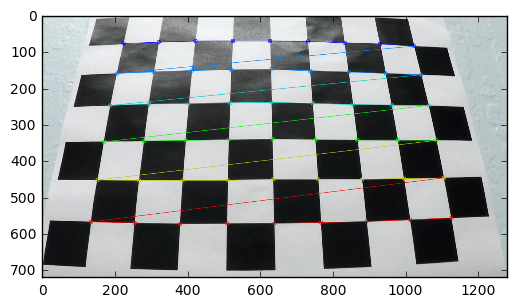

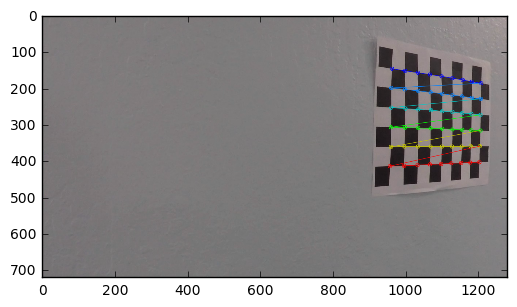

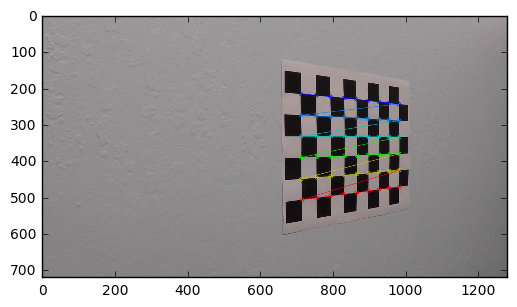

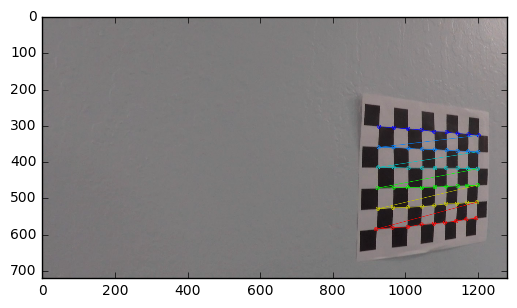

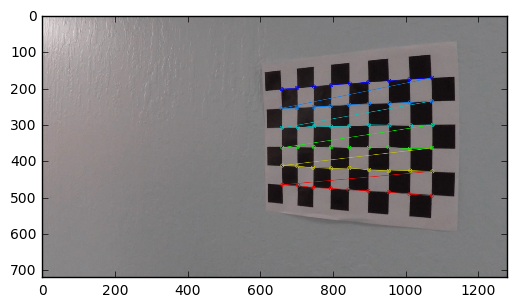

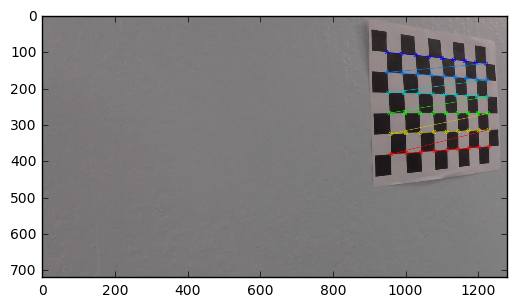

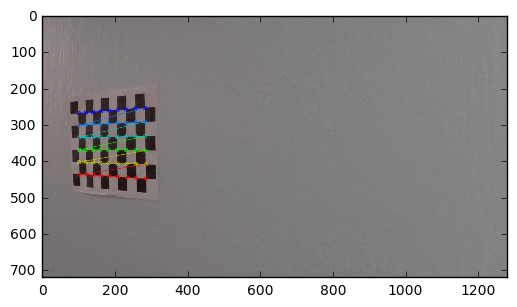

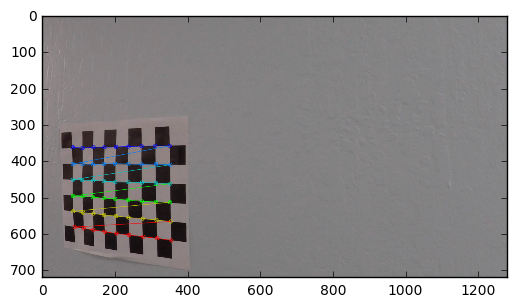

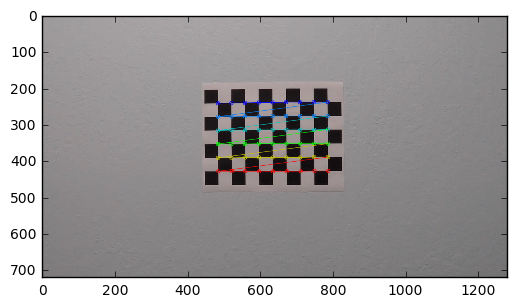

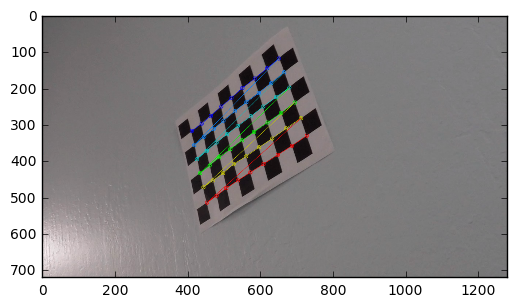

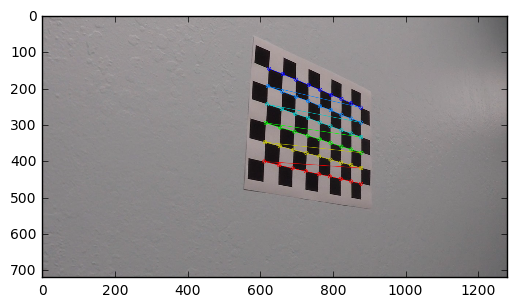

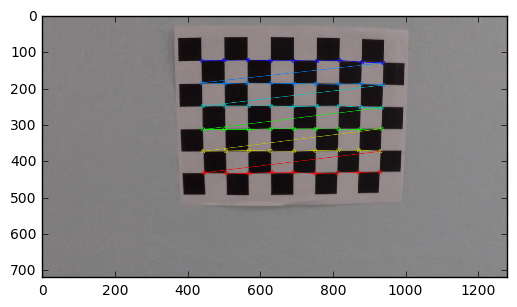

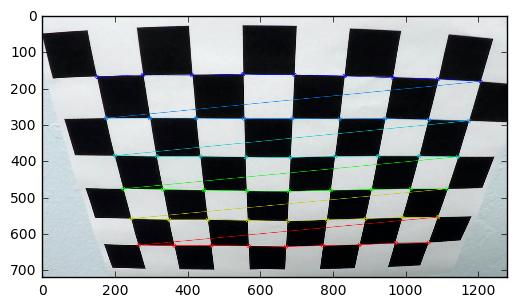

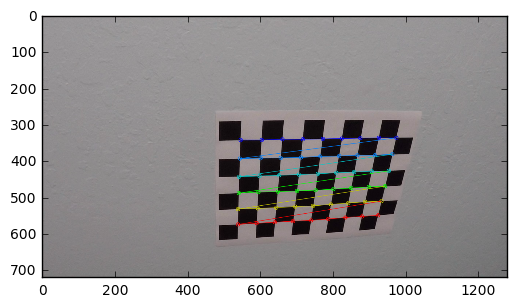

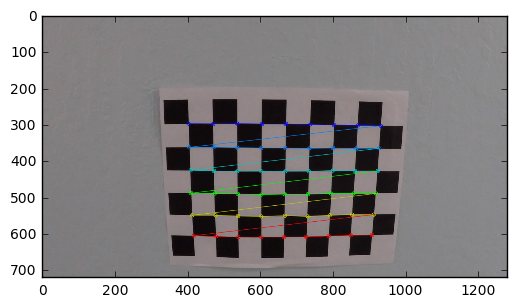

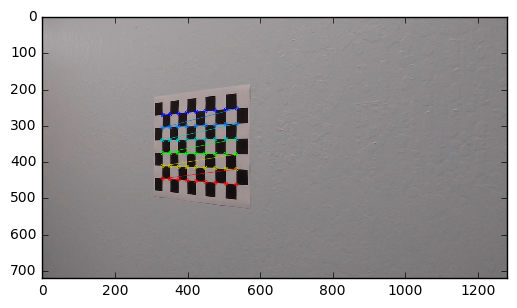

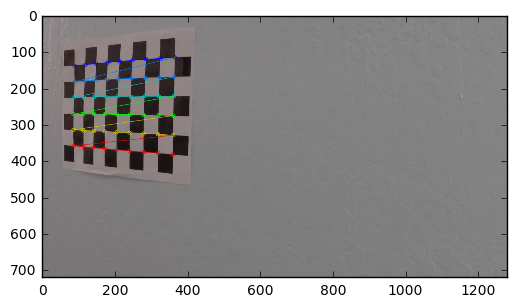

In [2]:

# prepare object points, (Actual coordinates of corners on a chess-board)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        plt.show()
        

ret, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
def cal_undistort(img, cameraMatrix, distCoeffs):
    # Use cv2.calibrateCamera() and cv2.undistort()
    undist = cv2.undistort(img, cameraMatrix, distCoeffs, None, cameraMatrix)
    return undist



# Pipeline (single images)

## 1. An example of a distortion-corrected image

You can notice how the distorsions are prominent next to the sides of the image.  

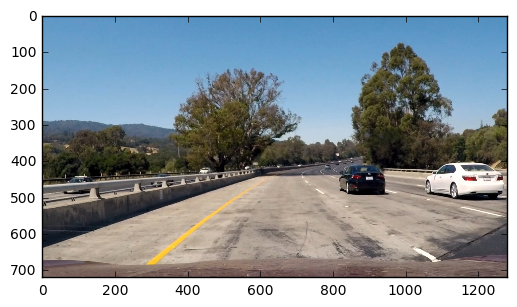

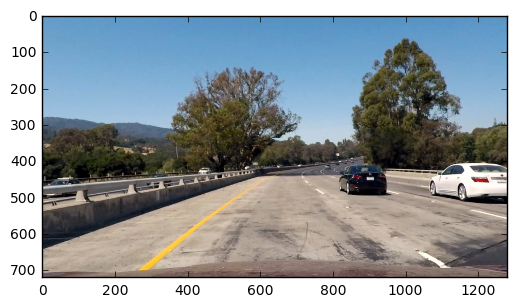

In [3]:
example_image = plt.imread('./test_images/test1.jpg')
plt.imshow(example_image)
plt.show()
img_undist = cal_undistort(example_image, cameraMatrix, distCoeffs)
plt.imshow(img_undist)
plt.show()

## 2. Creating a thresholded binary image.

In order to find appropriate threshold, I setup some sliders widgets to help calibrating the image processing parameters.

The widget elements can be found here. 
http://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Events.html

NOTE: This notebook can be ran without the ipywidgets package.

I created the WidgetCom class which allows me to store attribute references to the image processing pipeline parameters. Those references are globally accessible through the class namespace 'WidgetCom'. So, I can build callbacks on slider position change events to update the image by using the  WidgetCom attributes as a proxy.


In [4]:

class WidgetCom:
    """ Stores data for handling with interactive widget """
    value = dict()
    value['mutex'] = False # Attempt to reduce number of concurrent calls when using the widget 
    value['image'] = img_undist
    value['max_gradient'] = 512
WidgetCom.value['gray_min'] = 195
WidgetCom.value['sobel_angle_min'] = -15.0
WidgetCom.value['sobel_angle_max'] = 15.0
WidgetCom.value['sobel_mag'] = 70
WidgetCom.value['clipLimit'] = 2 # CLAHE histogram
WidgetCom.value['tileGridSize'] = 8 # CLAHE histogram
WidgetCom.value['sobel_mag'] = 70


In [5]:
# Building callbacks on slider move events to update the image with the new parameters  
        
def handle_slider_max_gradient_change(change):
    WidgetCom.value['max_gradient'] = change.new
    display_image()
    
def handle_slider_gray_min_change(change):
    WidgetCom.value['gray_min'] = change.new
    display_image()
    
def handle_slider_sobel_angle_min_change(change):
    WidgetCom.value['sobel_angle_min'] = change.new
    display_image()
    
def handle_slider_sobel_angle_max_change(change):
    WidgetCom.value['sobel_angle_max'] = change.new
    display_image()
    
def handle_slider_sobel_mag_change(change):
    WidgetCom.value['sobel_mag'] = change.new
    display_image()
    
def handle_slider_clipLimit_clahe_change(change):
    WidgetCom.value['clipLimit'] = change.new
    display_image()
    
def handle_slider_tileGridSize_clahe_change(change):
    WidgetCom.value['tileGridSize'] = change.new
    display_image()
try:
    from ipywidgets import widgets
    slider_grad_max = widgets.FloatSlider(min=0, max=512, value=WidgetCom.value['max_gradient'], description='H max')
    slider_gray_min = widgets.IntSlider(min=0, max=255, value=WidgetCom.value['gray_min'], description='gray')
    slider_sobel_angle_min = widgets.FloatSlider(min=-45, max=45, value=WidgetCom.value['sobel_angle_min'], description='sobel angle min')
    slider_sobel_angle_max = widgets.FloatSlider(min=-45, max=45, value=WidgetCom.value['sobel_angle_max'], description='sobel angle max')
    slider_sobel_mag = widgets.FloatSlider(min=0.1, max=100, value=WidgetCom.value['sobel_mag'], description='sobel mag')
    slider_tileGridSize_clahe_mag = widgets.IntSlider(min=8, max=512, value=WidgetCom.value['tileGridSize'], description='tileGridSize')
    slider_clipLimit_clahe_mag = widgets.IntSlider(min=1, max=256.0, value=WidgetCom.value['clipLimit'], description='clipLimit')

    slider_grad_max.observe(handle_slider_max_gradient_change, names='value')
    slider_gray_min.observe(handle_slider_gray_min_change, names='value')
    slider_sobel_angle_min.observe(handle_slider_sobel_angle_min_change, names='value')
    slider_sobel_angle_max.observe(handle_slider_sobel_angle_max_change, names='value')
    slider_sobel_mag.observe(handle_slider_sobel_mag_change, names='value')
    slider_tileGridSize_clahe_mag.observe(handle_slider_tileGridSize_clahe_change, names='value')
    slider_clipLimit_clahe_mag.observe(handle_slider_tileGridSize_clahe_change, names='value')
except Exception as err:
        print('Exception called, ipywidgets is not installed. That''s OK, we will do without!\n' + str(err))

In order to retrieve the marking lanes, I focused on three aspects: brightness compensation, image segmentation and edge filtering.

Please note that this pipeline is applied on the "bird-view" (perspective transformed) image and not the original image.


### Brightness compensation

Different tarmac/macadam surfaces has different levels of brightness. This variation in brightness impacts negatively the image processing pipeline.

I choose to use the CLAHE image compensation in order to reduce the variance in brightess in different locations whithin a single frame. 

I also implemented a simple scheme to compensate the brightess level globally in a frame.

Reference: see function **segment_image**



### Image segmentation 
Road markings are designed to stand out in brightness and color. Image segmentation is using the lane color and brightness properties to find appropriate lane marquing pixel candidates in the image.
I explored several approaches. 

**a. Color and Brightness segmentation**

In the project lane markings have two colors : yellow and white.
The idea of this approach was to find yellow pixels and white pixels in the image.

I extracted the H channel (hue) from the HSV colorspace to extract yellow pixels and I collected Y channel (brightness component) from the YUV colorspace to find the white pixels.

Using some min and max threshold values on H, S V, and Y, I could extract a good proportion of candidates pixels. 

**b. Value channel pixels segmentation (HSV colorspace) **  

This second approach was inspired by the fact that the yellow and white lanes pixel have a high value in the V channel from the (HSV colorspace).

Using **one** min threshold values on just **one** channel (V), I could extract a proportion of candidates pixels. 

Reference: see function **segment_image**



###  Edge filtering

The image returned by the segmentation may return blob of pixels which may not be aligned with the road.
The purpose of this step is to filter edges in the image as a function of their orientation.
Because the vehicle is travelling in a direction parallel to the lines, we can use the "bird-view" perspective on the road to filter-in the lines that are parallel to the camera view. 


Reference: see function **sobel_angle_image**

In [6]:
# Let's segment the image  the yellow in the image
def segment_image(img_undist, gray_min):
    # Let's perform some histogram based brightness compensation
    V = cv2.cvtColor(img_undist, cv2.COLOR_RGB2HSV)[:,:,2]
    clahe = cv2.createCLAHE(clipLimit=WidgetCom.value['clipLimit'], 
                            tileGridSize=(WidgetCom.value['tileGridSize'] ,WidgetCom.value['tileGridSize'] ))
    
    # Local brightness compensation inside single frame
    V_clahe = clahe.apply(V)
    gray_mean = np.mean(V_clahe)
    
    #Offset depending on global brightness of image
    gray_min = gray_min + ((gray_mean - 80)*2/3) 
    mask = np.uint8(V_clahe>gray_min)*255
    im_segmented = cv2.bitwise_and(V, V, mask= mask)
    return np.dstack((im_segmented, im_segmented, im_segmented))

def sobel_angle_image(img, thresh_min, thresh_max, mag_thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mask_mag = np.zeros_like(gradmag).astype('uint8')
    mask_mag[gradmag >= mag_thresh] = 1
    mask_mag[gradmag >= WidgetCom.value['max_gradient'] ] = 0
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    absgraddir = np.float32(absgraddir)*180.0/np.pi
    #binary_output =  np.zeros_like(absgraddir).astype('uint8')
    direction_im = np.bitwise_and((absgraddir>thresh_min).astype('uint8'),
                                   (absgraddir<thresh_max).astype('uint8')).astype('uint8')
    
    binary_output = cv2.bitwise_and(direction_im,mask_mag, mask=mask_mag)
    return binary_output*1.0

import time
from IPython import display
def compute_image(image):
    gray_min =   WidgetCom.value['gray_min']
    thresh_min = WidgetCom.value['sobel_angle_min']
    thresh_max = WidgetCom.value['sobel_angle_max']
    mag_thresh = WidgetCom.value['sobel_mag']
    img = segment_image(image, gray_min)
    edge_img = sobel_angle_image(img, thresh_min, thresh_max, mag_thresh)
    return img, edge_img
        
def display_image():
    if WidgetCom.value['mutex'] == False:
        WidgetCom.value['mutex'] = True
        
        img, edge_img = compute_image(WidgetCom.value['image'])

        fig = plt.figure(figsize=(8, 5))
        ax = fig.add_subplot(2, 3, 1)
        plt.title('Original Image')
        ax.imshow(WidgetCom.value['image'])
        ax = fig.add_subplot(2, 3, 2)
        plt.title('Masked Image')
        ax.imshow(img)
        ax = fig.add_subplot(2, 3, 3)
        ax.imshow(edge_img, cmap='gray')
        plt.title('Edges')
        
        plt.show()
        plt.close(fig)
        display.clear_output(wait=True)
        WidgetCom.value['mutex'] = False
    
    

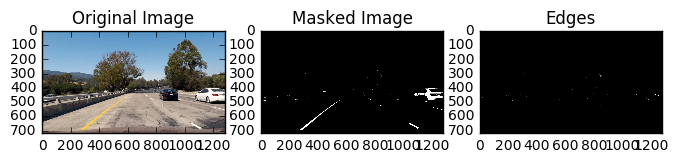

In [7]:
try:
    # Display interactive sliders
    from IPython import display
    from ipywidgets import HBox

    display.display(HBox([slider_grad_max, slider_tileGridSize_clahe_mag, slider_clipLimit_clahe_mag]))
    display.display(HBox([slider_sobel_angle_min, slider_gray_min, ]))
    display.display(HBox([slider_sobel_angle_max, slider_sobel_mag]))
except Exception as err:
        print('Exception called, ipywidgets is not installed. That''s OK, we will do without!\n' + str(err))
finally:
    display_image()

## 3. Apply a perspective transform to rectify binary image ("birds-eye view").

The approach followed here is very simple.
The objective of this stage to create a perspective transform that would allow for a 'natural' understanding of the road from a "from-above" view.
This view allows us to perform Euclidian calculations very easily.

In order to accomplish this, I choose to have the persoective destination points having the length of X unit equal Y axis unit. In fact I designed the transformation so that 1 pixel in the wraped image is 10 centimeters in this projection.

We use lane corners as a reference to get the actual dimensions in space. The breakdown for the different positions in described in the following table :


| Lateral position   | Longitudinal position   |
|:-------------:|:-------------:| 
|center_of_car-lane_width/2  | pt_distance_to_car |
|center_of_car-lane_width/2  | pt_distance_to_car+dash_line_len|
|center_of_car+lane_width/2  | pt_distance_to_car |
|center_of_car+lane_width/2  | pt_distance_to_car+dash_line_len|



The minimum lane width is 12 feet (3.7 m). Each dashed line measures 10 feet (3.0 m), and the empty spaces in-between measure 30 feet (9.0m). This results in the following source and destination points:
    

| Source (pixels)| Destination (x10 cm)| 
|:-------------:|:--------------:| 
| 436, 560      | 81.5,   40.   | 
| 540, 488      | 81.5,  130.   |
| 856, 560      | 118.5,   40.0 |
| 746, 488      | 118.5,  130.  |


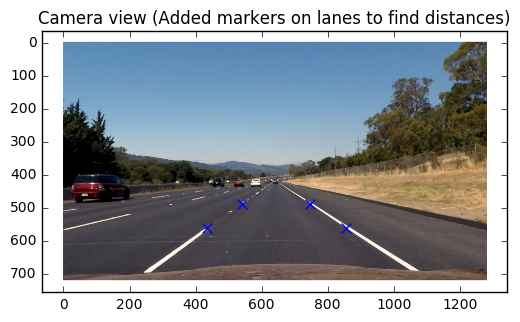

Destination points: 
 [[  81.5   40. ]
 [  81.5  130. ]
 [ 118.5   40. ]
 [ 118.5  130. ]]

Transformation matrix: 
 [[ -2.97321429e-02  -2.37600446e-01   1.18513214e+02]
 [ -4.00287442e-16   1.11383929e-01  -7.58750000e+01]
 [ -9.53928505e-18  -2.38839286e-03   1.00000000e+00]]

Transformation matrix inverse: 
 [[ -3.36336336e+01  -2.18920452e+01   2.32497110e+03]
 [  5.41371989e-13  -1.43193895e+01  -1.08648368e+03]
 [  9.72168173e-16  -3.42003276e-02  -1.59494986e+00]]


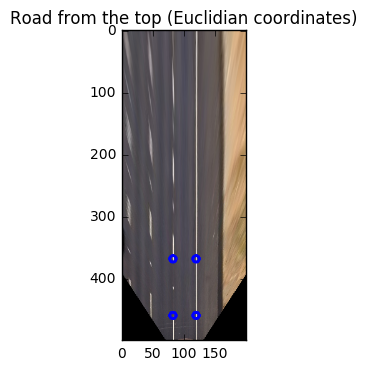

In [8]:
# Find PROJECTIVE transform for the road to find better masking region
# Minimum lane width of 12 feet (3.7 m)
# Each dashed line measures 10 feet (3.0 m), and the empty spaces in-between measure 30 feet (9.0m).


example_image = plt.imread('./test_images/straight_lines2.jpg')
#plt.imshow(example_image)
#plt.show()
img_undist = cal_undistort(example_image, cameraMatrix, distCoeffs)
plt.imshow(img_undist)

image_proj_work = img_undist.copy()
plt.imshow(image_proj_work)
plt.title('Camera view (Added markers on lanes to find distances)')

# Mark known points in image
points_px = np.float32( [ [436, 560], [540, 488],   [856, 560], [746, 488] ] )
plt.scatter(points_px[0][0], points_px[0][1], s=50, c='blue', marker='x')
plt.scatter(points_px[1][0], points_px[1][1], s=50, c='blue', marker='x')
plt.scatter(points_px[2][0], points_px[2][1], s=50, c='blue', marker='x')
plt.scatter(points_px[3][0], points_px[3][1], s=50, c='blue', marker='x')
plt.show()

# Points in meters
pt_distance_to_car = 4.0
dash_line_len = 9.0
lane_width = 3.7
center_of_car = 10
points_dest_px = np.float32( [ [center_of_car-lane_width/2, pt_distance_to_car],
                        [center_of_car-lane_width/2, pt_distance_to_car+dash_line_len],
                        [center_of_car+lane_width/2, pt_distance_to_car],
                        [center_of_car+lane_width/2, pt_distance_to_car+dash_line_len] ] )
meters_to_px = 10.0
points_m = meters_to_px * points_dest_px
print('Destination points: \n',points_m )

transfM = cv2.getPerspectiveTransform(points_px,points_m)
print('\nTransformation matrix: \n', transfM)

transfMInv = np.linalg.inv(transfM)
print('\nTransformation matrix inverse: \n', transfMInv)

wrappedIm = cv2.warpPerspective(image_proj_work, transfM, (center_of_car*2*int(meters_to_px),500))


plt.imshow(wrappedIm)
plt.title('Road from the top (Euclidian coordinates)')

#cv2.imwrite('foo.png',wrappedIm)
radius = 5
color_circle = (0,0,255)
thickness = 4
wrappedIm_copy = wrappedIm.copy()

for line in range(points_px.shape[0]):
    points_dest_px2 = np.matmul(transfM, np.concatenate((points_px[line],[1]), axis=0)[np.newaxis].T)
    points_dest_px2 = points_dest_px2/points_dest_px2[2]
    wrappedIm = cv2.circle(wrappedIm, tuple(points_dest_px2[0:2]), radius, color_circle,thickness)

wrappedIm = cv2.flip(wrappedIm,0) #Vertical flip

plt.imshow(wrappedIm)
plt.show()


In [9]:
# Saving calibration data in "static" object for kater global access
class CameraCalibration:
    """
    Saving calibration data in "static" object for kater global access.
    Description of the dictionary field 'value' 
        cameraMatrix: camera matrix
        distCoeffs : camera distorsion coefficients
        transfM : transformation matrix (from pixels to 0.1 meters on the road), use on undistorted image
        transfMInv : transformation matrix inverse (from pixels to 0.1 meters on the road)
        center_of_car : Lateral position of car in the lane
    """
    value = dict()
    def undistort(img):
        """
        Undistort image using the cameraMatrix and the distorsion coefficients
        """
        undist = cv2.undistort(img, CameraCalibration.value['cameraMatrix'], 
                               CameraCalibration.value['distCoeffs'], None,
                               CameraCalibration.value['cameraMatrix'])
        return undist
    def birdview(img):
        """
        Apply wrap perspective transform to undistorted image
        """
        wrappedIm = cv2.warpPerspective(img, CameraCalibration.value['transfM'], 
                                        (CameraCalibration.value['center_of_car'] * 
                                         2*int(CameraCalibration.value['meters_to_px']),500))
        return wrappedIm

# Initialize camera calibration parameter (see parameter definitions above)
CameraCalibration.value['cameraMatrix'] = cameraMatrix
CameraCalibration.value['distCoeffs'] = distCoeffs
CameraCalibration.value['transfM'] = transfM
CameraCalibration.value['transfMInv'] = transfMInv
CameraCalibration.value['center_of_car'] = center_of_car 
CameraCalibration.value['meters_to_px'] = meters_to_px 


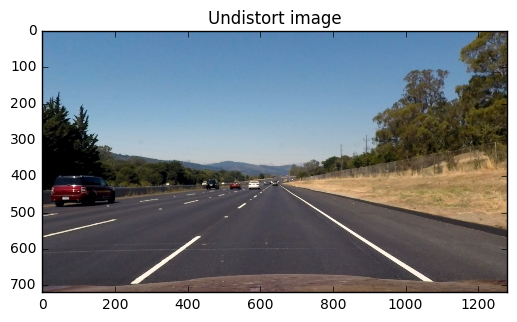

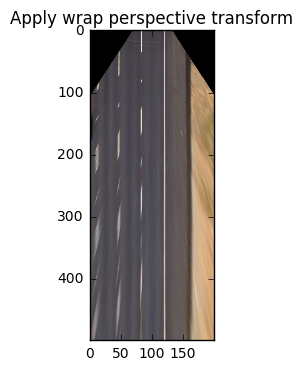

In [10]:
# Testing undistort function
plt.imshow(CameraCalibration.undistort(example_image))
plt.title('Undistort image')
plt.show()
plt.imshow(CameraCalibration.birdview(CameraCalibration.undistort(example_image)))
plt.title('Apply wrap perspective transform')
plt.show()

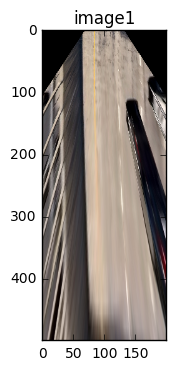

corec -41.8962066667


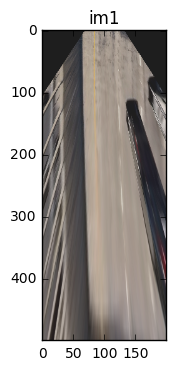

mean1: 126.82649
meanref: 78.47935
std1: 71.3381826533
stdref: 37.0378173436


In [11]:
example_image1 = CameraCalibration.birdview(CameraCalibration.undistort(plt.imread('./test_images/test1.jpg')))
image_ref = CameraCalibration.birdview(CameraCalibration.undistort(plt.imread('./test_images/test2.jpg')))
plt.imshow(example_image1)
plt.title('image1')
plt.show()
im1 = example_image1.astype('float32')
imref = image_ref.astype('float32')
correc = np.mean(image_ref) - np.mean(example_image1)
im1 = np.clip((im1 - correc)*(np.std(image_ref)/np.std(im1))**.5,0,255).astype('uint8')
print('corec',correc)
plt.imshow(im1)
plt.title('im1')
plt.show()


#WidgetCom.value['image'] = CameraCalibration.birdview(CameraCalibration.undistort(image))
#img, edge_img = compute_image(WidgetCom.value['image'])

example1V = cv2.cvtColor(example_image1, cv2.COLOR_RGB2HSV)[:,:,2]
image_refV = cv2.cvtColor(image_ref, cv2.COLOR_RGB2HSV)[:,:,2]
print('mean1:',np.mean(example1V))
print('meanref:',np.mean(image_refV))
print('std1:',np.std(example1V))
print('stdref:',np.std(image_refV))

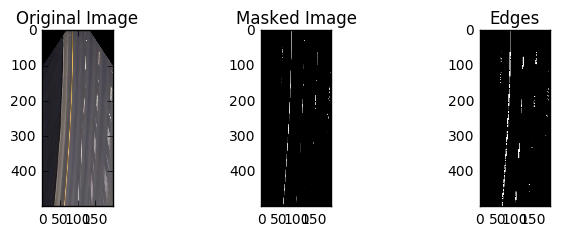

In [12]:
example_image = plt.imread('./test_images/test2.jpg')
try:
    from ipywidgets import HBox
    WidgetCom.value['image'] = CameraCalibration.birdview(CameraCalibration.undistort(example_image))
    boxColor = HBox([slider_grad_max, slider_tileGridSize_clahe_mag, slider_clipLimit_clahe_mag])
    boxSV = HBox([slider_sobel_angle_min,slider_gray_min])
    boxSobel = HBox([slider_sobel_angle_max, slider_sobel_mag])
    display.display(boxColor,boxSV, boxSobel)

except Exception as err:
        print(str(err))
finally:
    display_image()


./test_images/straight_lines2.jpg


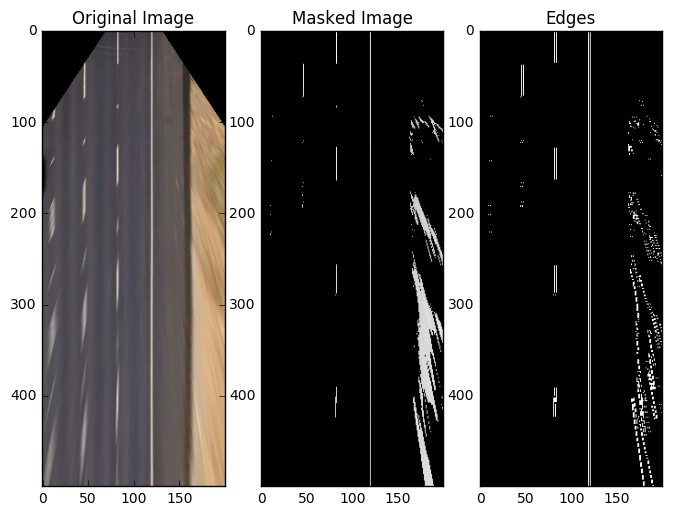



./test_images/test1.jpg


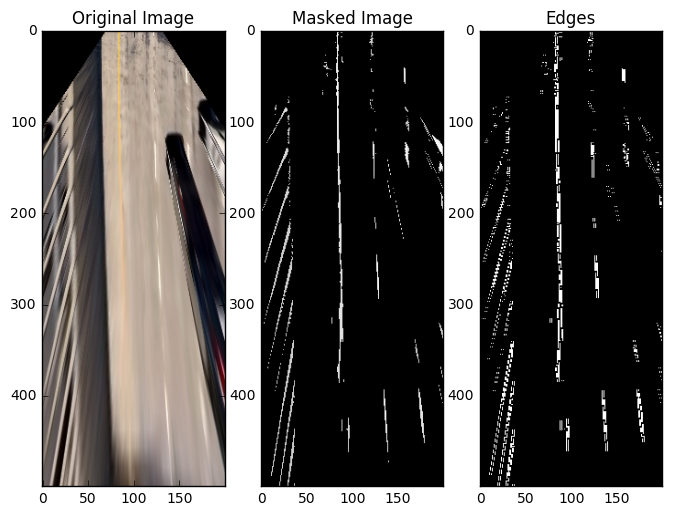



./test_images/test6.jpg


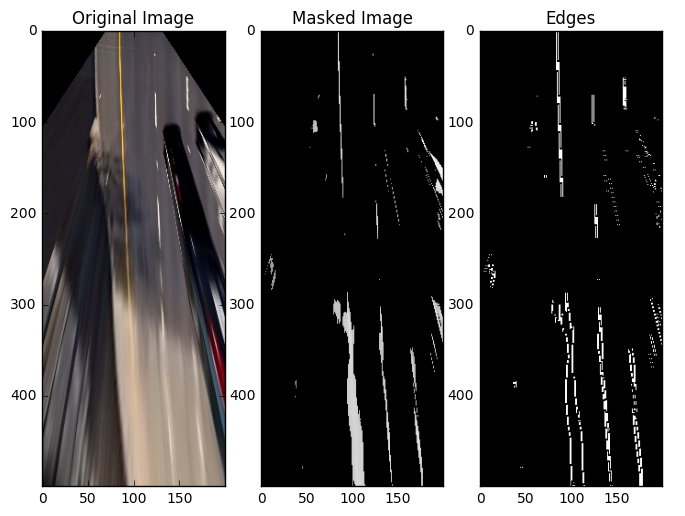



./test_images/test3.jpg


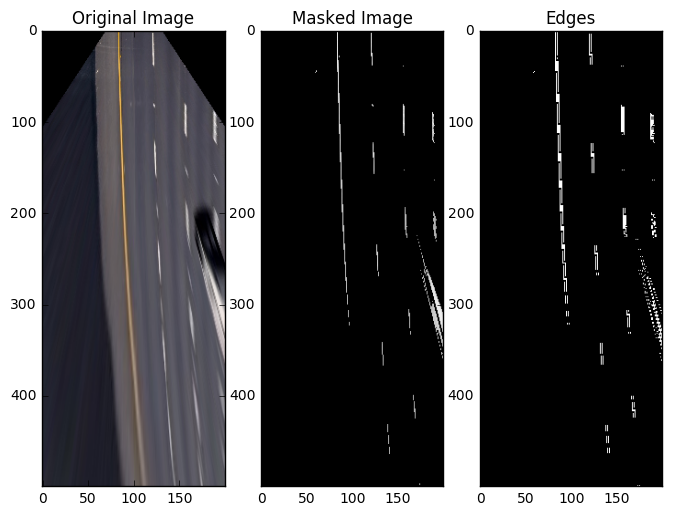



./test_images/test2.jpg


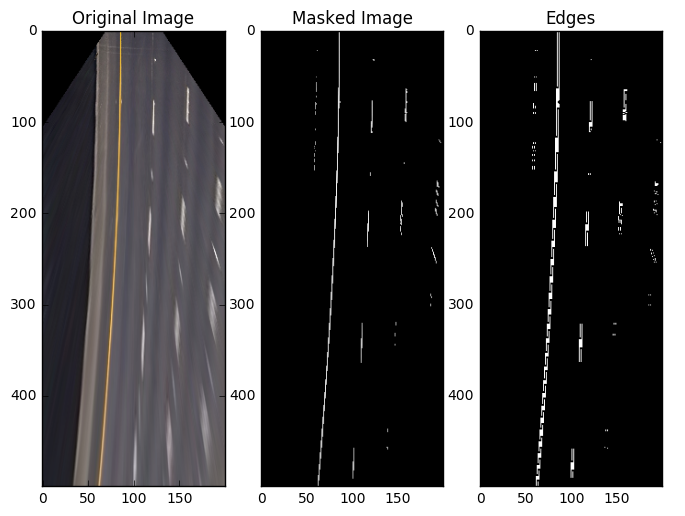



./test_images/test5.jpg


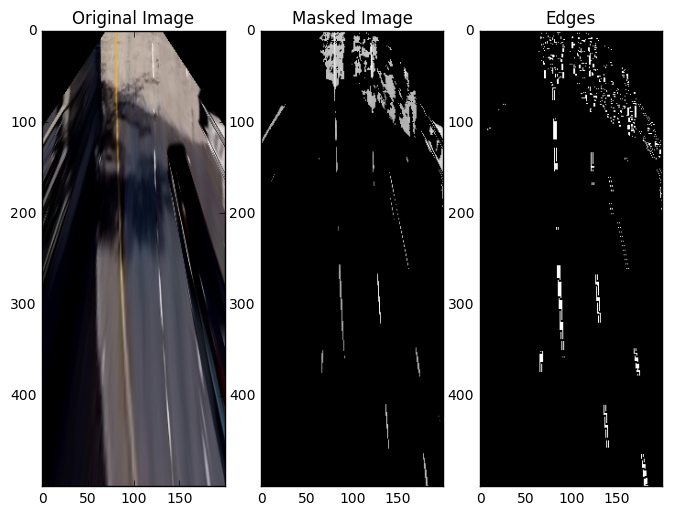



./test_images/test4.jpg


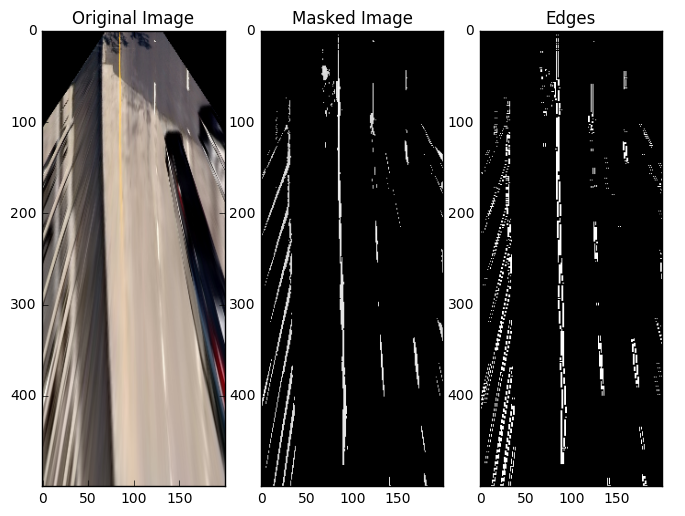



./test_images/straight_lines1.jpg


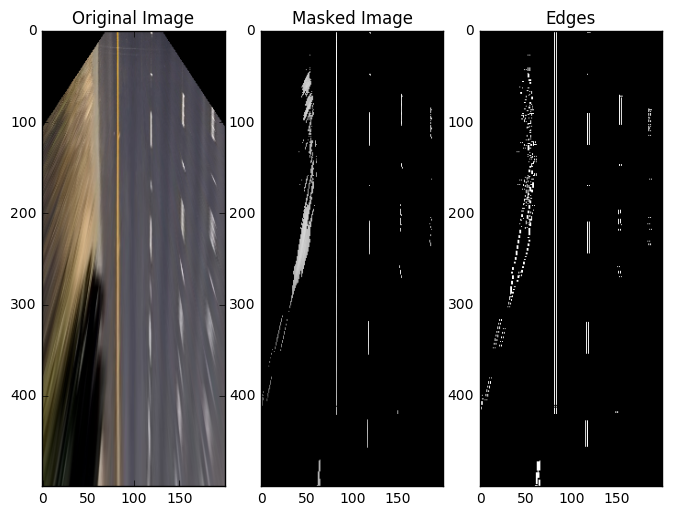

In [13]:
## Display all test images
list_images = glob.glob('./test_images/*.jpg')

for image_file in list_images:
    print(image_file)
    image = plt.imread(image_file)
    WidgetCom.value['image'] = CameraCalibration.birdview(CameraCalibration.undistort(image))
    img, edge_img = compute_image(WidgetCom.value['image'])

    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(1, 3, 1)
    plt.title('Original Image')
    ax.imshow(WidgetCom.value['image'])
    ax = fig.add_subplot(1, 3, 2)
    plt.title('Masked Image')
    ax.imshow(img)
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(edge_img, cmap='gray')
    plt.title('Edges')
    
    plt.show()
    plt.close(fig)
    
    print('')
    print('')
    

## 3. Detect lane pixels and fit to find the lane boundary.

### Find lane peaks

The first step is to get a histogram of the lateral lane pixel candidate distribution the bottom half of the image.
I then used a bi-modal gaussian distribution around the center of the camera, representing the probability of finding the lateral lane position to find the lane position.
The Gaussian mean is 1.5 m on the left of the camera and 1.5 m on the right of the camera.
I chose a standard deviation of 1 m around the mean of the distribution.  



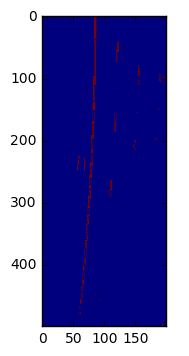

Image shape: (500, 200)


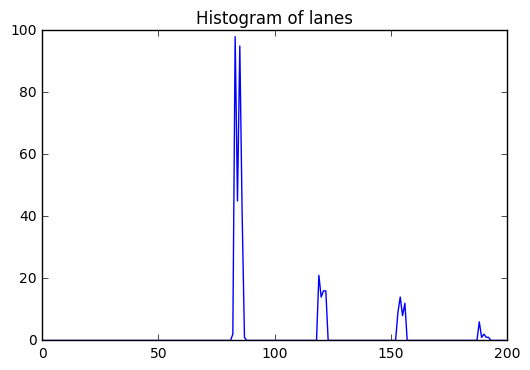

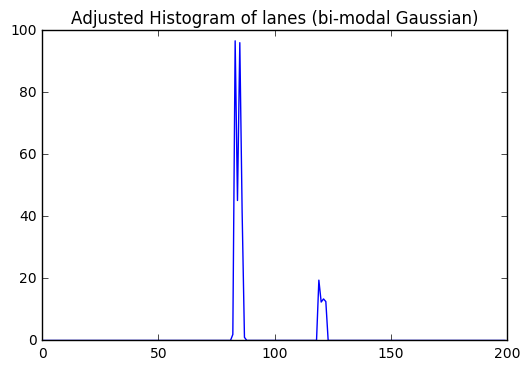

Left lane position : 83
Right lane position : 119


In [14]:

# Extract difficult image from extra challenge
from moviepy.editor import VideoFileClip
clip1 = VideoFileClip("project_video.mp4")
image = clip1.get_frame(5)
#image = plt.imread('./test_images/test6.jpg')

birdview_img = CameraCalibration.birdview(CameraCalibration.undistort(image))
img, edge_img = compute_image(birdview_img)

def find_lanes_peaks(edge_img,debug=False):
    binary_warped = edge_img.astype('uint8')
    # Take a histogram of the lateral lane pixel candidate distribution the bottom half of the image
    histogram = np.sum(binary_warped[:binary_warped.shape[1]//2,:], axis=0)

    
    if debug:
        plt.imshow(binary_warped)
        plt.show()
        print('Image shape:',binary_warped.shape)
        plt.plot(histogram)
        plt.title('Histogram of lanes')
        plt.show()
        
    x = np.arange(histogram.shape[0])

    def gaussian(x, mu, sig):
        return np.exp(-np.square(x - mu) / (2 * np.square(sig)))

    histogram_gauss = histogram*( (gaussian(x,histogram.shape[0]/2+15,10)) + (gaussian(x,histogram.shape[0]/2-15,10)) )

    if debug:
        plt.plot(x,histogram_gauss)
        plt.title('Adjusted Histogram of lanes (bi-modal Gaussian)')
        plt.show()

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram_gauss.shape[0]/2)
    leftx_base = np.argmax(histogram_gauss[:midpoint])
    rightx_base = np.argmax(histogram_gauss[midpoint:]) + midpoint
    if debug:
        print('Left lane position :',leftx_base)
        print('Right lane position :',rightx_base)
    
    return binary_warped, leftx_base, rightx_base, histogram_gauss

binary_warped,leftx_base, rightx_base, histogram_gauss = find_lanes_peaks(edge_img,debug=True)


### Lane sliding window algorithm 

We then apply a sliding window algorithm. The sliding window algorithm finds pixels attempts to find the pixel lanes to exclude outliers. The result is a number of pixels following a candidate curve.

This algorithm works without retaining a previous value of a successful search. So this sliding window algorithm works better when as an initial estimation of the lane position. 

The algorithm then performs a polynomial fit of the left pixel candidates and then a polynomial fit of the right pixel candidates.


[ -8.66471929e-05  -9.44112225e-03   8.49736791e+01]
[ -1.03755848e-04  -1.40646644e-02   1.21662645e+02]
[ -8.66471929e-05  -9.44112225e-03   8.49736791e+01]
[ -1.03755848e-04  -1.40646644e-02   1.21662645e+02]


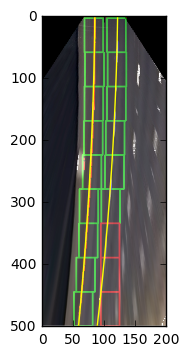

In [29]:

def lane_sliding_window(binary_warped,leftx_base, rightx_base, histogram_gauss, debug=True):
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 15
    # Set minimum number of pixels found to recenter window
    minpix = 20
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Window color
    found_lane_color =  (0,255,0)
    no_lane_color =  (255,0,0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Step through the windows one by one
    for window in range(nwindows, -1, -1):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)


        left_window_color =  right_window_color = no_lane_color
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            left_window_color = found_lane_color
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            right_window_color = found_lane_color
            
        # Draw the windows on the visualization image
        out_img = cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),left_window_color, 2) 
        out_img = cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),right_window_color, 2) 

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if debug:
        print(left_fit)
        print(right_fit)

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    out_img = cv2.addWeighted(out_img,0.5,birdview_img,0.9,0)

    
    return left_fit, right_fit, out_img, leftx, lefty, rightx, righty



def generate_plot_points(binary_warped, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx

left_fit, right_fit,  out_img, leftx, lefty, rightx, righty = lane_sliding_window(binary_warped,leftx_base, rightx_base, histogram_gauss)
ploty, left_fitx, right_fitx = generate_plot_points(binary_warped, left_fit, right_fit)
print(left_fit)
print(right_fit)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, binary_warped.shape[1] )
plt.ylim(binary_warped.shape[0], 0)
plt.show()

### Polynomial envelope search algorithm 

The Polynomial envelope search algorithm role is also to find the pixel lanes to exclude outliers.

But this algorithm relies on a previous value of a successful search and create a envelope arount a previously successful search. So this sliding window algorithm works better when we have confidence in the quality of a previous search.

The algorithm then outputs a polynomial fit of the left pixel candidates and then a polynomial fit of the right pixel candidates.

In [30]:
def poly_envelope_lane_search(binary_warped, left_fit, right_fit):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    margin = 10
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty, left_fitx, right_fitx = generate_plot_points(binary_warped, left_fit, right_fit)
    return left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds

left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds = poly_envelope_lane_search(binary_warped, left_fit, right_fit)

print(left_lane_inds.shape[0]) (1103,)
print(right_lane_inds.shape[0]) (193,)


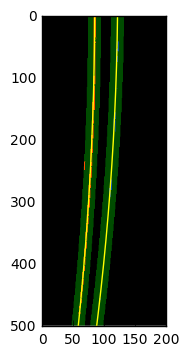

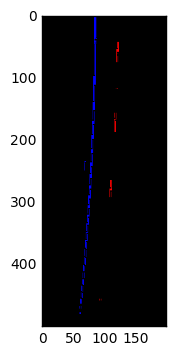

In [31]:
# DEBUG ONLY: Create an image to draw on and an image to show the selection window
def draw_poly_search_debug (binary_warped, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty, debug=False):
    out_img_binary = np.zeros_like(binary_warped)
    out_img = np.dstack((out_img_binary, out_img_binary, out_img_binary))
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty,rightx] = [0, 0, 255]
    out_img

    # Draw the lane onto the warped blank image
    if debug:
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        margin = 10
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, binary_warped.shape[1] )
        plt.ylim(binary_warped.shape[0], 0)
        plt.show()
    return out_img

print('print(left_lane_inds.shape[0])', leftx.shape)
print('print(right_lane_inds.shape[0])', rightx.shape)

draw_poly_search_debug(binary_warped, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty, debug=True)

# Create an image to draw on and an image to show the selection window
def draw_poly_search(binary_warped, leftx, lefty, rightx, righty):
    out_img_binary = np.zeros_like(binary_warped)
    lane_pixels = np.dstack((out_img_binary, out_img_binary, out_img_binary))
    window_img = np.zeros_like(out_img)
    lane_pixels[lefty, leftx] = [0, 0, 255]
    lane_pixels[righty,rightx] = [255, 0, 0]
    return lane_pixels

lane_pixels = draw_poly_search (binary_warped, leftx, lefty, rightx, righty)
plt.imshow(lane_pixels)
plt.show()

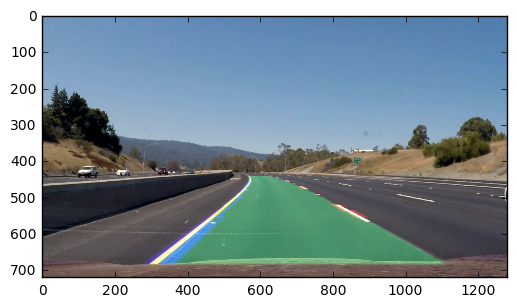

In [32]:
def add_overlay_on_frame(image, binary_warped, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))*0
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    overlay_color = (0,255, 100)
    color_warp = cv2.fillPoly(color_warp, np.int_([pts]), overlay_color)
    
    lane_pixels = draw_poly_search (binary_warped, leftx, lefty, rightx, righty)
    
    # Warp the blank back to original image space using inverse perspective matrix
    lane_road = cv2.warpPerspective(color_warp, CameraCalibration.value['transfMInv'], (image.shape[1], image.shape[0])) 
    lane_pixels = cv2.warpPerspective(lane_pixels, CameraCalibration.value['transfMInv'], (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    image = cv2.addWeighted(image, 1, lane_road, 0.3, 0)
    image = cv2.addWeighted(image, 1, lane_pixels, 0.5, 0)
    
    return image
    
result = add_overlay_on_frame(image, binary_warped, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty)

plt.imshow(result)
plt.show()

### Filtering the calculated output

An important aspect of this algorithm aims at adding some robustness to the calculated lane curves. Lighting for example can negatively the quality of the lane curve estimation.
We will use two simple [finite impulse response filters](https://en.wikipedia.org/wiki/Finite_impulse_response) in order to stabilize the lane curves.


The filters have a depth of 3, but implement two different set of coefficients.


coeffs_stable : coefficients when we estimate that the quality of the curve estimation is high an we can quicky update the curve parameters.

coeffs_unstable : coefficients when we estimate that the quality of the curve estimation is low an we should slowly update the curve parameters.


## 6. Road curvature calculation
The member function of the class Filter name "radius" calculates the radius of the curved road.

In [33]:
class Filter:
    """
    
    This class is a static class. 
    Just one instance of the parameters is needed.
    """
    value = dict()
    
    def apply_coef(left_fit, right_fit):
        if abs(np.sum(Filter.value['coeffs_stable'])-1.0)>1e-5:
            raise Exception('Sum of coefficients in filter coeffs_stable should equal 1.0')
        elif abs(np.sum(Filter.value['coeffs_unstable'])-1.0)>1e-5:
            raise Exception('Sum of coefficients in filter coeffs_unstable should equal 1.0')
            
        Filter.value['left_fit_list'].append(left_fit)
        Filter.value['right_fit_list'].append(right_fit)
        coeffs = Filter.value['coeffs_stable'] if Filter.is_stable() else Filter.value['coeffs_unstable']
        #print('In = :', left_fit)
        if len(Filter.value['left_fit_list'])>len(coeffs):
            del Filter.value['left_fit_list'][0]
            del Filter.value['right_fit_list'][0]
            left_fit = np.zeros(3)
            right_fit = np.zeros(3)
            for lfit, rfit, coeff in zip(Filter.value['left_fit_list'], Filter.value['right_fit_list'], coeffs):
                left_fit  = left_fit + lfit*coeff
                right_fit = right_fit + rfit*coeff
        
        #print('Out = :', left_fit)
        return left_fit, right_fit
    
    def save_fit(left_fit, right_fit):
        Filter.value['left_fit_list'][-1] = left_fit
        Filter.value['right_fit_list'][-1] = right_fit  
    
    def radius(left_fit, right_fit):
        y_eval = 40 # Evaluate curvature at 20 meters
        left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        left_curverad = left_curverad/CameraCalibration.value['meters_to_px']
        right_curverad = right_curverad/CameraCalibration.value['meters_to_px']
        return left_curverad, right_curverad
    
    def save_radius(left_curverad, right_curverad):
        Filter.value['left_radius'].append(left_curverad)
        Filter.value['right_radius'].append(right_curverad)
        
        if len(Filter.value['left_radius'])>len(Filter.value['coeffs_stable']):
            del Filter.value['left_radius'][0]
            del Filter.value['right_radius'][0]
    
    def is_stable():
        stable = False
        if len(Filter.value['left_radius'])>=2 and len(Filter.value['left_fit_list'])>=2:
            difference = Filter.value['left_radius'][-1] - Filter.value['left_radius'][-2]
            relative_diff = difference/(Filter.value['left_radius'][-1] + 0.1)
            stable = True if relative_diff<0.05 else False
        return stable
    
    def are_lanes_parallel(left_curverad, right_curverad):
        difference = left_curverad-right_curverad
        relative_diff = difference/(left_curverad + 0.1)
        parallel = True if relative_diff<0.35 else False
        
        return parallel
            
Filter.value['left_fit_list'] = list()
Filter.value['right_fit_list'] = list()
Filter.value['left_radius'] = list()
Filter.value['right_radius'] = list()
Filter.value['coeffs_stable'] = [0.3,0.2, 0.5]
Filter.value['coeffs_unstable'] = [0.6,0.3, 0.1]


## Top processing function. 
This function chooses which lane finding algorithm to use as a function of the estimated quality of the algorithm.
The function choose between lane_sliding_window and poly_envelope_lane_search.


In [41]:

# Define callback for processing image
def process_image(image):
    minpix = 1500
    image = CameraCalibration.undistort(image)
    birdview_img = CameraCalibration.birdview(image)
    img, edge_img = compute_image(birdview_img)
    edge_img = edge_img.astype('uint8')
    
    try:
        # Evaluate quality and stability of radius:
        # testing if the radius fairly similar and have we got a history of previous fits 
        if len(Filter.value['left_radius'])>1 and Filter.are_lanes_parallel(Filter.value['left_radius'][-1], 
                                     Filter.value['right_radius'][-1]) and len(Filter.value['left_fit_list'])>1:
            left_fit =  Filter.value['left_fit_list'][-1]
            right_fit = Filter.value['right_fit_list'][-1]
            
            print('Try using use poly envelope')
            poly_out  = poly_envelope_lane_search(edge_img, left_fit, right_fit)
            left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds = poly_out
            print('leftx.shape', leftx.shape)
            print('righty.shape', rightx.shape)
            if leftx.shape[0] + rightx.shape[0]<minpix:
                print('Not enough pixels: Using sliding window')
                _ ,leftx_base, rightx_base, histogram_gauss = find_lanes_peaks(edge_img,debug=False)
                left_fit, right_fit,  out_img, leftx, lefty, rightx, righty = lane_sliding_window(edge_img,leftx_base, rightx_base, histogram_gauss,debug=False)
                
        else:
            print('Unstable geometry: Using sliding window')
            _ ,leftx_base, rightx_base, histogram_gauss = find_lanes_peaks(edge_img,debug=False)
            left_fit, right_fit,  out_img, leftx, lefty, rightx, righty = lane_sliding_window(edge_img,leftx_base, rightx_base, histogram_gauss,debug=False)
        
        
    except Exception as err:
        if len(Filter.value['left_fit_list'])>0:
            left_fit =  Filter.value['left_fit_list'][-1]
            right_fit = Filter.value['right_fit_list'][-1]
            print('Exception called :' + str(err))
        else:
            print('Exception called :' + str(err))
            return image
        
    if len(left_fit)>0 and len(right_fit)>0:
        left_fit, right_fit = Filter.apply_coef(left_fit, right_fit)
        Filter.save_fit(left_fit, right_fit)
        
    ploty, left_fitx, right_fitx = generate_plot_points(edge_img, left_fit, right_fit)
    
    # Calculate vehicle lateral position
    position_y = 1
    leftx_base = left_fit[0]*position_y**2 + left_fit[1]*position_y + left_fit[2]
    print('leftx_base',leftx_base)
    rightx_base = right_fit[0]*position_y**2 + right_fit[1]*position_y + right_fit[2]
    print('rightx_base',rightx_base)
    lateral_center = (rightx_base+leftx_base)/2
    vehicle_center = edge_img.shape[1]//2
    vehicle_later_position =  (vehicle_center - lateral_center)/CameraCalibration.value['meters_to_px']
    try: 
        result = add_overlay_on_frame(image, binary_warped, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty)
    except :
        result = add_overlay_on_frame_debug(image, binary_warped, left_fitx, right_fitx, ploty)
        
    left_curverad, right_curverad = Filter.radius(left_fit, right_fit)
    Filter.save_radius(left_curverad, right_curverad)
    
    left_curverad_str = 'straight' if left_curverad>3000 else '{:6.0f}'.format(left_curverad)
    right_curverad_str = 'straight' if right_curverad>3000 else '{:6.0f}'.format(right_curverad) 
    text_color = (51, 255, 0)
    cv2.putText(result,'left curve radius  : {} m'.format(left_curverad_str),
                (10,50), cv2.FONT_HERSHEY_PLAIN, 3, text_color, 2, cv2.LINE_AA)
    cv2.putText(result,'right curve radius : {} m'.format(right_curverad_str) ,
                (10,90), cv2.FONT_HERSHEY_PLAIN, 3, text_color, 2, cv2.LINE_AA)
    #cv2.putText(result,'stable : {} '.format(Filter.is_stable()) ,
    #            (10,130), cv2.FONT_HERSHEY_PLAIN, 3, text_color, 2, cv2.LINE_AA)
    #cv2.putText(result,'parallel lanes : {} '.format(Filter.are_lanes_parallel(left_curverad, right_curverad)) ,
    #            (10,170), cv2.FONT_HERSHEY_PLAIN, 3, text_color, 2, cv2.LINE_AA)
    cv2.putText(result,'lateral position : {:1.2f} m'.format(vehicle_later_position) ,
                (10,130), cv2.FONT_HERSHEY_PLAIN, 3, text_color, 2, cv2.LINE_AA)
    
    return result


## 6. Example image of the result plotted back down onto the road such 
Notice how the road is clearly marked.

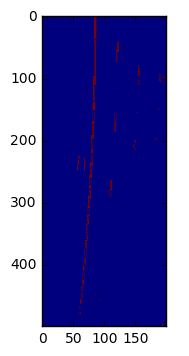

Unstable geometry: Using sliding window
leftx_base 84.2488644244
rightx_base 120.864858003


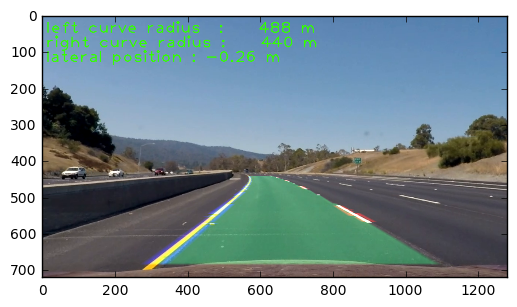

In [51]:
# Extract difficult image from project video
from moviepy.editor import VideoFileClip
clip1 = VideoFileClip("project_video.mp4")

Filter.value['left_fit_list'] = list()
Filter.value['right_fit_list'] = list()

image = clip1.get_frame(4.5)
#image = plt.imread('./test_images/test6.jpg')
plt.clf()
plt.imshow((edge_img))
plt.show()
result = process_image(image)
plt.clf()
plt.imshow(result)
plt.show()

# Pipeline (video)
You may find the link to processed project video uploaded to YouTube [here](https://youtu.be/B3v2JnefhOc).

In [50]:
from moviepy.editor import VideoFileClip
clip1 = VideoFileClip("project_video.mp4")
video_output = './output_images/project_video.mp4'

Filter.value['left_fit_list'] = list()
Filter.value['right_fit_list'] = list()
Filter.value['coeffs_stable'] = [0.4, 0.3, 0.3]
Filter.value['coeffs_unstable'] = [0.7, 0.2, 0.1]
white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(video_output, audio=False)

Unstable geometry: Using sliding window
leftx_base 85.2659852941
rightx_base 122.856571586
[MoviePy] >>>> Building video ./output_images/project_video.mp4
[MoviePy] Writing video ./output_images/project_video.mp4



  0%|          | 2/1261 [00:00<01:17, 16.34it/s]

Unstable geometry: Using sliding window
leftx_base 85.2659852941
rightx_base 122.856571586
Try using use poly envelope
leftx.shape (1295,)
righty.shape (324,)
leftx_base 85.2659852941
rightx_base 122.856571586
Try using use poly envelope
leftx.shape (1248,)
righty.shape (307,)
leftx_base 85.2659852941
rightx_base 122.856571586



  0%|          | 4/1261 [00:00<01:16, 16.40it/s]

Try using use poly envelope
leftx.shape (1224,)
righty.shape (313,)
leftx_base 85.2659852941
rightx_base 122.856571586



  0%|          | 6/1261 [00:00<01:16, 16.38it/s]

Try using use poly envelope
leftx.shape (1233,)
righty.shape (289,)
leftx_base 85.2659852941
rightx_base 122.856571586
Try using use poly envelope
leftx.shape (1214,)
righty.shape (267,)
Not enough pixels: Using sliding window
leftx_base 85.2428208119
rightx_base 122.690756586
Try using use poly envelope
leftx.shape (1191,)
righty.shape (229,)
Not enough pixels: Using sliding window
leftx_base 85.2223193731
rightx_base 122.649763807


Try using use poly envelope
leftx.shape (1136,)
righty.shape (214,)
Not enough pixels: Using sliding window
leftx_base 85.1592630361
rightx_base 122.636282123



  1%|          | 10/1261 [00:00<01:18, 15.98it/s]

Try using use poly envelope
leftx.shape (1153,)
righty.shape (230,)
Not enough pixels: Using sliding window
leftx_base 85.101115109
rightx_base 122.649113327
Try using use poly envelope
leftx.shape (1173,)
righty.shape (228,)
Not enough pixels: Using sliding window
leftx_base 85.00691807
rightx_base 122.618224042
Try using use poly envelope
leftx.shape (1157,)
righty.shape (271,)
Not enough pixels: Using sliding window
leftx_base 84.9141897753
rightx_base 122.578893129



  1%|          | 12/1261 [00:00<01:15, 16.58it/s]

Try using use poly envelope
leftx.shape (1239,)
righty.shape (290,)
leftx_base 84.9512810932
rightx_base 122.594625494



  1%|          | 14/1261 [00:00<01:12, 17.29it/s]

Try using use poly envelope
leftx.shape (1221,)
righty.shape (254,)
Not enough pixels: Using sliding window
leftx_base 84.6916179052
rightx_base 122.545730472
Try using use poly envelope
leftx.shape (1178,)
righty.shape (265,)
Not enough pixels: Using sliding window
leftx_base 84.5688801029
rightx_base 122.605157745
Try using use poly envelope
leftx.shape (1135,)
righty.shape (246,)
Not enough pixels: Using sliding window
leftx_base 84.3194335531
rightx_base 122.491063345


Try using use poly envelope
leftx.shape (1151,)
righty.shape (227,)
Not enough pixels: Using sliding window
leftx_base 84.1866115508
rightx_base 122.453644531



  1%|▏         | 18/1261 [00:01<01:16, 16.15it/s]

Try using use poly envelope
leftx.shape (1136,)
righty.shape (246,)
Not enough pixels: Using sliding window
leftx_base 83.9395583764
rightx_base 122.351884512
Try using use poly envelope
leftx.shape (1118,)
righty.shape (228,)
Not enough pixels: Using sliding window
leftx_base 83.7305096164
rightx_base 122.29687033
Try using use poly envelope
leftx.shape (1138,)
righty.shape (218,)
Not enough pixels: Using sliding window
leftx_base 83.543425282
rightx_base 122.169899249


Try using use poly envelope
leftx.shape (1154,)
righty.shape (229,)
Not enough pixels: Using sliding window
leftx_base 83.0497686536
rightx_base 121.98805526



  2%|▏         | 22/1261 [00:01<01:15, 16.34it/s]

Try using use poly envelope
leftx.shape (1156,)
righty.shape (244,)
Not enough pixels: Using sliding window
leftx_base 82.7952217417
rightx_base 121.848799609
Try using use poly envelope
leftx.shape (1170,)
righty.shape (270,)
Not enough pixels: Using sliding window
leftx_base 82.4514012784
rightx_base 121.783723656


Try using use poly envelope
leftx.shape (1201,)
righty.shape (286,)
Not enough pixels: Using sliding window
leftx_base 81.8326925287
rightx_base 121.742071141
Try using use poly envelope
leftx.shape (1191,)
righty.shape (248,)
Not enough pixels: Using sliding window
leftx_base 81.9858084117
rightx_base 121.744056125



  2%|▏         | 26/1261 [00:01<01:13, 16.79it/s]

Try using use poly envelope
leftx.shape (1179,)
righty.shape (264,)
Not enough pixels: Using sliding window
leftx_base 82.162452291
rightx_base 121.722798948
Try using use poly envelope
leftx.shape (1179,)
righty.shape (277,)
Not enough pixels: Using sliding window
leftx_base 82.4558862645
rightx_base 121.713867211



  2%|▏         | 28/1261 [00:01<01:14, 16.47it/s]

Try using use poly envelope
leftx.shape (1189,)
righty.shape (264,)
Not enough pixels: Using sliding window
leftx_base 82.7366241895
rightx_base 121.755265868
Try using use poly envelope
leftx.shape (1218,)
righty.shape (304,)
leftx_base 82.6243290195
rightx_base 121.738706405



  2%|▏         | 30/1261 [00:01<01:13, 16.84it/s]

Try using use poly envelope
leftx.shape (1193,)
righty.shape (317,)
leftx_base 82.6692470875
rightx_base 121.74533019
Try using use poly envelope
leftx.shape (1160,)
righty.shape (262,)
Not enough pixels: Using sliding window
leftx_base 82.9842257962
rightx_base 121.85531629


Try using use poly envelope
leftx.shape (1158,)
righty.shape (307,)
Not enough pixels: Using sliding window
leftx_base 83.1294599098
rightx_base 121.859938617



  3%|▎         | 32/1261 [00:01<01:22, 14.86it/s]

Try using use poly envelope
leftx.shape (1110,)
righty.shape (224,)
Not enough pixels: Using sliding window
leftx_base 83.3198076642
rightx_base 121.879180937
Try using use poly envelope
leftx.shape (1111,)
righty.shape (232,)
Not enough pixels: Using sliding window
leftx_base 83.4536574627
rightx_base 121.737811055



  3%|▎         | 34/1261 [00:02<01:28, 13.84it/s]

Try using use poly envelope
leftx.shape (1094,)
righty.shape (244,)
Not enough pixels: Using sliding window
leftx_base 83.593619251
rightx_base 121.721789796



  3%|▎         | 36/1261 [00:02<01:34, 12.91it/s]

Try using use poly envelope
leftx.shape (1086,)
righty.shape (246,)
Not enough pixels: Using sliding window
leftx_base 83.7218027828
rightx_base 121.709984996
Try using use poly envelope
leftx.shape (1049,)
righty.shape (266,)
Not enough pixels: Using sliding window
leftx_base 83.8132328068
rightx_base 121.714097063


Try using use poly envelope
leftx.shape (1057,)
righty.shape (229,)
Not enough pixels: Using sliding window
leftx_base 83.9250901348
rightx_base 121.735447186



  3%|▎         | 38/1261 [00:02<01:30, 13.50it/s]

Try using use poly envelope
leftx.shape (1041,)
righty.shape (219,)
Not enough pixels: Using sliding window
leftx_base 84.0122873848
rightx_base 121.746791184
Try using use poly envelope
leftx.shape (1056,)
righty.shape (220,)
Not enough pixels: Using sliding window
leftx_base 84.1195889551
rightx_base 121.749177897
Try using use poly envelope
leftx.shape (1077,)
righty.shape (248,)
Not enough pixels: Using sliding window
leftx_base 84.2001055601
rightx_base 121.728089975



  3%|▎         | 40/1261 [00:02<01:25, 14.22it/s]

Try using use poly envelope
leftx.shape (1057,)
righty.shape (244,)
Not enough pixels: Using sliding window
leftx_base 84.2609302327
rightx_base 121.696032431



  3%|▎         | 42/1261 [00:02<01:20, 15.20it/s]

Try using use poly envelope
leftx.shape (1057,)
righty.shape (254,)
Not enough pixels: Using sliding window
leftx_base 84.3759023534
rightx_base 121.733865124
Try using use poly envelope
leftx.shape (1069,)
righty.shape (237,)
Not enough pixels: Using sliding window
leftx_base 84.4919679525
rightx_base 121.813342751
Try using use poly envelope
leftx.shape (1123,)
righty.shape (282,)
Not enough pixels: Using sliding window
leftx_base 84.5682213081
rightx_base 121.872800562



  4%|▎         | 46/1261 [00:03<01:24, 14.41it/s]

Try using use poly envelope
leftx.shape (1119,)
righty.shape (231,)
Not enough pixels: Using sliding window
leftx_base 84.6479710137
rightx_base 121.918563424
Try using use poly envelope
leftx.shape (1117,)
righty.shape (258,)
Not enough pixels: Using sliding window
leftx_base 84.6989898393
rightx_base 122.024308736


Try using use poly envelope
leftx.shape (1128,)
righty.shape (257,)
Not enough pixels: Using sliding window
leftx_base 84.7208116427
rightx_base 122.059712206



  4%|▍         | 48/1261 [00:03<01:27, 13.86it/s]

Try using use poly envelope
leftx.shape (1140,)
righty.shape (239,)
Not enough pixels: Using sliding window
leftx_base 84.7628485304
rightx_base 122.104253487
Try using use poly envelope
leftx.shape (1152,)
righty.shape (274,)
Not enough pixels: Using sliding window
leftx_base 84.7593232987
rightx_base 122.157643947



  4%|▍         | 50/1261 [00:03<01:29, 13.56it/s]

Try using use poly envelope
leftx.shape (1143,)
righty.shape (271,)
Not enough pixels: Using sliding window
leftx_base 84.7964558214
rightx_base 122.172760406



  4%|▍         | 52/1261 [00:03<01:26, 13.93it/s]

Try using use poly envelope
leftx.shape (1134,)
righty.shape (262,)
Not enough pixels: Using sliding window
leftx_base 84.7967726208
rightx_base 122.142497934
Try using use poly envelope
leftx.shape (1127,)
righty.shape (266,)
Not enough pixels: Using sliding window
leftx_base 84.8171333879
rightx_base 122.05713271


Try using use poly envelope
leftx.shape (1148,)
righty.shape (256,)
Not enough pixels: Using sliding window
leftx_base 84.8164380755
rightx_base 121.987358684



  4%|▍         | 54/1261 [00:03<01:33, 12.89it/s]

Try using use poly envelope
leftx.shape (1136,)
righty.shape (242,)
Not enough pixels: Using sliding window
leftx_base 84.7672262644
rightx_base 121.979562994
Try using use poly envelope
leftx.shape (1139,)
righty.shape (281,)
Not enough pixels: Using sliding window
leftx_base 84.7479839335
rightx_base 121.952499083



  4%|▍         | 56/1261 [00:03<01:33, 12.85it/s]

Try using use poly envelope
leftx.shape (1129,)
righty.shape (220,)
Not enough pixels: Using sliding window
leftx_base 84.695473599
rightx_base 122.025379681



  5%|▍         | 58/1261 [00:03<01:37, 12.36it/s]

Try using use poly envelope
leftx.shape (1124,)
righty.shape (229,)
Not enough pixels: Using sliding window
leftx_base 84.6469308196
rightx_base 121.970208713
Try using use poly envelope
leftx.shape (1129,)
righty.shape (206,)
Not enough pixels: Using sliding window
leftx_base 84.5685428997
rightx_base 121.82424595


Try using use poly envelope
leftx.shape (1073,)
righty.shape (199,)
Not enough pixels: Using sliding window
leftx_base 84.5158255137
rightx_base 121.668437514



  5%|▍         | 60/1261 [00:04<01:38, 12.21it/s]

Try using use poly envelope
leftx.shape (1028,)
righty.shape (201,)
Not enough pixels: Using sliding window
leftx_base 84.4681412527
rightx_base 121.614533971
Try using use poly envelope
leftx.shape (1007,)
righty.shape (227,)
Not enough pixels: Using sliding window
leftx_base 84.3961444672
rightx_base 121.51131378



  5%|▍         | 62/1261 [00:04<01:40, 11.98it/s]

Try using use poly envelope
leftx.shape (997,)
righty.shape (206,)
Not enough pixels: Using sliding window
leftx_base 84.316489655
rightx_base 121.314259456



  5%|▌         | 64/1261 [00:04<01:35, 12.48it/s]

Try using use poly envelope
leftx.shape (1005,)
righty.shape (219,)
Not enough pixels: Using sliding window
leftx_base 84.230399595
rightx_base 121.267592865
Try using use poly envelope
leftx.shape (986,)
righty.shape (208,)
Not enough pixels: Using sliding window
leftx_base 84.1527274282
rightx_base 121.18275998


Try using use poly envelope
leftx.shape (1002,)
righty.shape (208,)
Not enough pixels: Using sliding window
leftx_base 84.081245746
rightx_base 121.210647634
Try using use poly envelope
leftx.shape (1001,)
righty.shape (218,)
Not enough pixels: Using sliding window
leftx_base 84.0026176958
rightx_base 121.144931497



  5%|▌         | 66/1261 [00:04<01:30, 13.22it/s]

Try using use poly envelope
leftx.shape (1031,)
righty.shape (197,)
Not enough pixels: Using sliding window
leftx_base 83.9549900025
rightx_base 121.156720539



  5%|▌         | 68/1261 [00:04<01:31, 13.03it/s]

Try using use poly envelope
leftx.shape (1034,)
righty.shape (211,)
Not enough pixels: Using sliding window
leftx_base 83.9012011884
rightx_base 121.106994976
Try using use poly envelope
leftx.shape (1030,)
righty.shape (193,)
Not enough pixels: Using sliding window
leftx_base 83.83756154
rightx_base 121.050239526



  6%|▌         | 70/1261 [00:04<01:32, 12.93it/s]

Try using use poly envelope
leftx.shape (1070,)
righty.shape (190,)
Not enough pixels: Using sliding window
leftx_base 83.7905710142
rightx_base 120.85869387



  6%|▌         | 72/1261 [00:05<01:32, 12.84it/s]

Try using use poly envelope
leftx.shape (1060,)
righty.shape (174,)
Not enough pixels: Using sliding window
leftx_base 83.7506015692
rightx_base 120.552580618
Try using use poly envelope
leftx.shape (1084,)
righty.shape (207,)
Not enough pixels: Using sliding window
leftx_base 83.7126182447
rightx_base 120.450127522


Try using use poly envelope
leftx.shape (1096,)
righty.shape (234,)
Not enough pixels: Using sliding window
leftx_base 83.6527452784
rightx_base 120.37412617



  6%|▌         | 74/1261 [00:05<01:35, 12.45it/s]

Try using use poly envelope
leftx.shape (1124,)
righty.shape (234,)
Not enough pixels: Using sliding window
leftx_base 83.5951577123
rightx_base 120.293603723
Try using use poly envelope
leftx.shape (1160,)
righty.shape (256,)
Not enough pixels: Using sliding window
leftx_base 83.518083489
rightx_base 120.271817797



  6%|▌         | 76/1261 [00:05<01:29, 13.21it/s]

Try using use poly envelope
leftx.shape (1181,)
righty.shape (212,)
Not enough pixels: Using sliding window
leftx_base 83.4627439136
rightx_base 120.306706015



  6%|▌         | 78/1261 [00:05<01:31, 12.96it/s]

Try using use poly envelope
leftx.shape (1183,)
righty.shape (284,)
Not enough pixels: Using sliding window
leftx_base 83.362594776
rightx_base 120.361341592
Try using use poly envelope
leftx.shape (1201,)
righty.shape (285,)
Not enough pixels: Using sliding window
leftx_base 83.261376801
rightx_base 120.329088566


Try using use poly envelope
leftx.shape (1195,)
righty.shape (310,)
leftx_base 83.301863991
rightx_base 120.341989776



  6%|▋         | 80/1261 [00:05<01:33, 12.57it/s]

Try using use poly envelope
leftx.shape (1206,)
righty.shape (299,)
leftx_base 83.285669115
rightx_base 120.336829292
Try using use poly envelope
leftx.shape (1174,)
righty.shape (285,)
Not enough pixels: Using sliding window
leftx_base 83.0789122094
rightx_base 120.357792215



  7%|▋         | 82/1261 [00:05<01:31, 12.93it/s]

Try using use poly envelope
leftx.shape (1172,)
righty.shape (246,)
Not enough pixels: Using sliding window
leftx_base 82.9937197811
rightx_base 120.367213404


Try using use poly envelope
leftx.shape (1206,)
righty.shape (266,)
Not enough pixels: Using sliding window
leftx_base 82.8548940293
rightx_base 120.513946182
Try using use poly envelope
leftx.shape (1260,)
righty.shape (282,)
leftx_base 82.91042433
rightx_base 120.455253071



  7%|▋         | 84/1261 [00:06<01:35, 12.26it/s]

Try using use poly envelope
leftx.shape (1254,)
righty.shape (247,)
leftx_base 82.8882122098
rightx_base 120.478730315



  7%|▋         | 86/1261 [00:06<01:42, 11.46it/s]

Try using use poly envelope
leftx.shape (1296,)
righty.shape (255,)
leftx_base 82.8970970579
rightx_base 120.469339418
Try using use poly envelope
leftx.shape (1197,)
righty.shape (240,)
Not enough pixels: Using sliding window
leftx_base 82.6752496144
rightx_base 120.485950956



  7%|▋         | 88/1261 [00:06<01:40, 11.64it/s]

Try using use poly envelope
leftx.shape (1211,)
righty.shape (221,)
Not enough pixels: Using sliding window
leftx_base 82.6128872374
rightx_base 120.478920409



  7%|▋         | 90/1261 [00:06<01:42, 11.47it/s]

Try using use poly envelope
leftx.shape (1148,)
righty.shape (222,)
Not enough pixels: Using sliding window
leftx_base 82.5348712571
rightx_base 120.479787218
Try using use poly envelope
leftx.shape (1057,)
righty.shape (198,)
Not enough pixels: Using sliding window
leftx_base 82.3902710927
rightx_base 120.451444958


Try using use poly envelope
leftx.shape (1083,)
righty.shape (228,)
Not enough pixels: Using sliding window
leftx_base 82.4381424262
rightx_base 120.446084814



  7%|▋         | 92/1261 [00:06<01:40, 11.68it/s]

Try using use poly envelope
leftx.shape (1067,)
righty.shape (245,)
Not enough pixels: Using sliding window
leftx_base 82.4419368151
rightx_base 120.368823102
Try using use poly envelope
leftx.shape (1008,)
righty.shape (208,)
Not enough pixels: Using sliding window
leftx_base 82.420648495
rightx_base 120.315221026



  7%|▋         | 94/1261 [00:06<01:40, 11.59it/s]

Try using use poly envelope
leftx.shape (1002,)
righty.shape (201,)
Not enough pixels: Using sliding window
leftx_base 82.4739732704
rightx_base 120.228800318



  8%|▊         | 96/1261 [00:07<01:40, 11.61it/s]

Try using use poly envelope
leftx.shape (1074,)
righty.shape (198,)
Not enough pixels: Using sliding window
leftx_base 82.4476173285
rightx_base 120.158070723
Try using use poly envelope
leftx.shape (1072,)
righty.shape (186,)
Not enough pixels: Using sliding window
leftx_base 82.4854119481
rightx_base 119.898517527


Try using use poly envelope
leftx.shape (1067,)
righty.shape (209,)
Not enough pixels: Using sliding window
leftx_base 82.4884622576
rightx_base 119.749061051



  8%|▊         | 98/1261 [00:07<01:40, 11.54it/s]

Try using use poly envelope
leftx.shape (1144,)
righty.shape (220,)
Not enough pixels: Using sliding window
leftx_base 82.5114511369
rightx_base 119.776124347
Try using use poly envelope
leftx.shape (1109,)
righty.shape (200,)
Not enough pixels: Using sliding window
leftx_base 82.5439074801
rightx_base 119.901687161



  8%|▊         | 100/1261 [00:07<01:35, 12.20it/s]

Try using use poly envelope
leftx.shape (1135,)
righty.shape (236,)
Not enough pixels: Using sliding window
leftx_base 82.5664892307
rightx_base 119.756545715



  8%|▊         | 102/1261 [00:07<01:34, 12.20it/s]

Try using use poly envelope
leftx.shape (1085,)
righty.shape (241,)
Not enough pixels: Using sliding window
leftx_base 82.5919876784
rightx_base 119.850422315
Try using use poly envelope
leftx.shape (1037,)
righty.shape (221,)
Not enough pixels: Using sliding window
leftx_base 82.6017865485
rightx_base 119.795335249


Try using use poly envelope
leftx.shape (1085,)
righty.shape (209,)
Not enough pixels: Using sliding window
leftx_base 82.6261780168
rightx_base 120.009274099



  8%|▊         | 104/1261 [00:07<01:33, 12.34it/s]

Try using use poly envelope
leftx.shape (1151,)
righty.shape (225,)
Not enough pixels: Using sliding window
leftx_base 82.765033781
rightx_base 119.963614268
Try using use poly envelope
leftx.shape (1178,)
righty.shape (259,)
Not enough pixels: Using sliding window
leftx_base 82.8241709087
rightx_base 119.99867934



  8%|▊         | 106/1261 [00:07<01:34, 12.21it/s]

Try using use poly envelope
leftx.shape (1180,)
righty.shape (273,)
Not enough pixels: Using sliding window
leftx_base 82.9060186569
rightx_base 120.047202634



  9%|▊         | 108/1261 [00:08<01:29, 12.93it/s]

Try using use poly envelope
leftx.shape (1208,)
righty.shape (276,)
Not enough pixels: Using sliding window
leftx_base 82.9657144051
rightx_base 120.257057467
Try using use poly envelope
leftx.shape (1182,)
righty.shape (250,)
Not enough pixels: Using sliding window
leftx_base 83.095493117
rightx_base 120.166917267


Try using use poly envelope
leftx.shape (1170,)
righty.shape (230,)
Not enough pixels: Using sliding window
leftx_base 83.1615169881
rightx_base 120.182108249



  9%|▊         | 110/1261 [00:08<01:26, 13.23it/s]

Try using use poly envelope
leftx.shape (1190,)
righty.shape (246,)
Not enough pixels: Using sliding window
leftx_base 83.237031489
rightx_base 120.244350148
Try using use poly envelope
leftx.shape (1174,)
righty.shape (232,)
Not enough pixels: Using sliding window
leftx_base 83.3660615273
rightx_base 120.283354887



  9%|▉         | 112/1261 [00:08<01:30, 12.69it/s]

Try using use poly envelope
leftx.shape (1180,)
righty.shape (264,)
Not enough pixels: Using sliding window
leftx_base 83.3731720458
rightx_base 120.359809956



  9%|▉         | 114/1261 [00:08<01:30, 12.61it/s]

Try using use poly envelope
leftx.shape (1187,)
righty.shape (240,)
Not enough pixels: Using sliding window
leftx_base 83.5756291371
rightx_base 120.390474675
Try using use poly envelope
leftx.shape (1178,)
righty.shape (228,)
Not enough pixels: Using sliding window
leftx_base 83.6966168868
rightx_base 120.520523786


Try using use poly envelope
leftx.shape (1122,)
righty.shape (243,)
Not enough pixels: Using sliding window
leftx_base 83.8350534864
rightx_base 120.59026112



  9%|▉         | 116/1261 [00:08<01:29, 12.79it/s]

Try using use poly envelope
leftx.shape (1094,)
righty.shape (235,)
Not enough pixels: Using sliding window
leftx_base 83.9387941621
rightx_base 120.691289161
Try using use poly envelope
leftx.shape (1076,)
righty.shape (224,)
Not enough pixels: Using sliding window
leftx_base 84.0220242859
rightx_base 120.782647684



  9%|▉         | 118/1261 [00:08<01:27, 13.04it/s]

Try using use poly envelope
leftx.shape (1083,)
righty.shape (234,)
Not enough pixels: Using sliding window
leftx_base 84.0863711405
rightx_base 120.843033174



 10%|▉         | 120/1261 [00:08<01:28, 12.93it/s]

Try using use poly envelope
leftx.shape (1073,)
righty.shape (207,)
Not enough pixels: Using sliding window
leftx_base 84.1953259237
rightx_base 120.89243948
Try using use poly envelope
leftx.shape (998,)
righty.shape (189,)
Not enough pixels: Using sliding window
leftx_base 84.284261203
rightx_base 120.967197518


Try using use poly envelope
leftx.shape (1060,)
righty.shape (187,)
Not enough pixels: Using sliding window
leftx_base 84.3917761162
rightx_base 120.946241656



 10%|▉         | 122/1261 [00:09<01:28, 12.85it/s]

Try using use poly envelope
leftx.shape (1023,)
righty.shape (217,)
Not enough pixels: Using sliding window
leftx_base 84.4293383003
rightx_base 121.120170426
Try using use poly envelope
leftx.shape (995,)
righty.shape (194,)
Not enough pixels: Using sliding window
leftx_base 84.5189431306
rightx_base 121.152994596
Try using use poly envelope
leftx.shape (1050,)
righty.shape (167,)
Not enough pixels: Using sliding window
leftx_base 84.5776089394
rightx_base 121.220828411



 10%|▉         | 124/1261 [00:09<01:37, 11.67it/s]

Try using use poly envelope
leftx.shape (1074,)
righty.shape (183,)
Not enough pixels: Using sliding window
leftx_base 84.6472893625
rightx_base 121.225372328



 10%|▉         | 126/1261 [00:09<01:41, 11.17it/s]

Try using use poly envelope
leftx.shape (1099,)
righty.shape (193,)
Not enough pixels: Using sliding window
leftx_base 84.714475771
rightx_base 121.35048601
Try using use poly envelope
leftx.shape (1059,)
righty.shape (213,)
Not enough pixels: Using sliding window
leftx_base 84.8291036355
rightx_base 121.437330936



 10%|█         | 128/1261 [00:09<01:37, 11.63it/s]

Try using use poly envelope
leftx.shape (1085,)
righty.shape (199,)
Not enough pixels: Using sliding window
leftx_base 84.8698881473
rightx_base 121.488244808



 10%|█         | 130/1261 [00:09<01:37, 11.59it/s]

Try using use poly envelope
leftx.shape (1016,)
righty.shape (180,)
Not enough pixels: Using sliding window
leftx_base 85.0098411245
rightx_base 121.476875232
Try using use poly envelope
leftx.shape (1056,)
righty.shape (230,)
Not enough pixels: Using sliding window
leftx_base 85.0323034605
rightx_base 121.433943477


Try using use poly envelope
leftx.shape (1033,)
righty.shape (180,)
Not enough pixels: Using sliding window
leftx_base 85.108784171
rightx_base 121.395454741



 10%|█         | 132/1261 [00:10<01:37, 11.63it/s]

Try using use poly envelope
leftx.shape (986,)
righty.shape (173,)
Not enough pixels: Using sliding window
leftx_base 85.1426354172
rightx_base 121.393492944
Try using use poly envelope
leftx.shape (1003,)
righty.shape (183,)
Not enough pixels: Using sliding window
leftx_base 85.1608136492
rightx_base 121.507985757



 11%|█         | 134/1261 [00:10<01:31, 12.28it/s]

Try using use poly envelope
leftx.shape (1002,)
righty.shape (188,)
Not enough pixels: Using sliding window
leftx_base 85.1643417105
rightx_base 121.546138022


Try using use poly envelope
leftx.shape (994,)
righty.shape (176,)
Not enough pixels: Using sliding window
leftx_base 85.147703308
rightx_base 121.58047351
Try using use poly envelope
leftx.shape (1015,)
righty.shape (171,)
Not enough pixels: Using sliding window
leftx_base 85.1039319311
rightx_base 121.643605775



 11%|█         | 136/1261 [00:10<01:37, 11.53it/s]

Try using use poly envelope
leftx.shape (1005,)
righty.shape (200,)
Not enough pixels: Using sliding window



 11%|█         | 138/1261 [00:10<01:36, 11.68it/s]

leftx_base 85.0266833075
rightx_base 121.736463881
Try using use poly envelope
leftx.shape (1046,)
righty.shape (230,)
Not enough pixels: Using sliding window
leftx_base 84.9040155004
rightx_base 121.78585243
Try using use poly envelope
leftx.shape (1048,)
righty.shape (240,)
Not enough pixels: Using sliding window
leftx_base 84.8273442049
rightx_base 121.788190481



 11%|█         | 140/1261 [00:10<01:39, 11.23it/s]

Try using use poly envelope
leftx.shape (1083,)
righty.shape (297,)
Not enough pixels: Using sliding window
leftx_base 84.6410447608
rightx_base 121.874370024
Try using use poly envelope
leftx.shape (1099,)
righty.shape (262,)
Not enough pixels: Using sliding window
leftx_base 84.5123358958
rightx_base 121.941927895



 11%|█▏        | 144/1261 [00:11<01:36, 11.52it/s]

Try using use poly envelope
leftx.shape (1131,)
righty.shape (278,)
Not enough pixels: Using sliding window
leftx_base 84.3329566981
rightx_base 121.995734796
Try using use poly envelope
leftx.shape (1069,)
righty.shape (242,)
Not enough pixels: Using sliding window
leftx_base 84.1232556676
rightx_base 122.029637048
Try using use poly envelope
leftx.shape (1084,)
righty.shape (225,)
Not enough pixels: Using sliding window
leftx_base 83.8948267711
rightx_base 122.029948403



 12%|█▏        | 146/1261 [00:11<01:35, 11.70it/s]

Try using use poly envelope
leftx.shape (1065,)
righty.shape (221,)
Not enough pixels: Using sliding window
leftx_base 83.6174938019
rightx_base 121.967911637
Try using use poly envelope
leftx.shape (1034,)
righty.shape (192,)
Not enough pixels: Using sliding window
leftx_base 83.5583998403
rightx_base 121.827729651
Try using use poly envelope
leftx.shape (1043,)
righty.shape (184,)
Not enough pixels: Using sliding window
leftx_base 83.2984336973
rightx_base 121.814735307
Try using use poly envelope



 12%|█▏        | 150/1261 [00:11<01:33, 11.91it/s]

leftx.shape (955,)
righty.shape (161,)
Not enough pixels: Using sliding window
leftx_base 83.0016980995
rightx_base 121.584789264
Try using use poly envelope
leftx.shape (984,)
righty.shape (170,)
Not enough pixels: Using sliding window
leftx_base 82.7702481317
rightx_base 121.607422999
Try using use poly envelope
leftx.shape (1008,)
righty.shape (194,)
Not enough pixels: Using sliding window
leftx_base 82.4593250793
rightx_base 121.61150035



 12%|█▏        | 152/1261 [00:11<01:29, 12.36it/s]

Try using use poly envelope
leftx.shape (1034,)
righty.shape (178,)
Not enough pixels: Using sliding window
leftx_base 82.0129781001
rightx_base 121.645773774
Try using use poly envelope
leftx.shape (1037,)
righty.shape (205,)
Not enough pixels: Using sliding window
leftx_base 81.9644642979
rightx_base 121.616949746
Try using use poly envelope
leftx.shape (977,)
righty.shape (181,)
Not enough pixels: Using sliding window
leftx_base 81.4840945588
rightx_base 121.573413701



 12%|█▏        | 156/1261 [00:12<01:25, 12.93it/s]

Try using use poly envelope
leftx.shape (1019,)
righty.shape (220,)
Not enough pixels: Using sliding window
leftx_base 81.8855870342
rightx_base 121.571166659
Try using use poly envelope
leftx.shape (1030,)
righty.shape (250,)
Not enough pixels: Using sliding window
leftx_base 81.7450136457
rightx_base 121.599131355
Try using use poly envelope
leftx.shape (1013,)
righty.shape (248,)
Not enough pixels: Using sliding window
leftx_base 82.5036354279
rightx_base 121.593611647



 13%|█▎        | 158/1261 [00:12<01:25, 12.90it/s]

Try using use poly envelope
leftx.shape (978,)
righty.shape (188,)
Not enough pixels: Using sliding window
leftx_base 82.1228637672
rightx_base 121.611597412
Try using use poly envelope
leftx.shape (934,)
righty.shape (151,)
Not enough pixels: Using sliding window
leftx_base 82.8203953565
rightx_base 121.518609307
Try using use poly envelope
leftx.shape (920,)
righty.shape (174,)
Not enough pixels: Using sliding window
leftx_base 82.4329449982
rightx_base 121.49141117



 13%|█▎        | 162/1261 [00:12<01:25, 12.83it/s]

Try using use poly envelope
leftx.shape (888,)
righty.shape (168,)
Not enough pixels: Using sliding window
leftx_base 82.9967551029
rightx_base 121.417234791
Try using use poly envelope
leftx.shape (965,)
righty.shape (185,)
Not enough pixels: Using sliding window
leftx_base 82.6718628962
rightx_base 121.420188722
Try using use poly envelope
leftx.shape (974,)
righty.shape (232,)
Not enough pixels: Using sliding window
leftx_base 83.0930083531
rightx_base 121.270337209



 13%|█▎        | 164/1261 [00:12<01:26, 12.72it/s]

Try using use poly envelope
leftx.shape (1023,)
righty.shape (216,)
Not enough pixels: Using sliding window
leftx_base 83.0827886846
rightx_base 121.373337629
Try using use poly envelope
leftx.shape (921,)
righty.shape (196,)
Not enough pixels: Using sliding window
leftx_base 83.2850174463
rightx_base 121.347770441
Try using use poly envelope
leftx.shape (859,)
righty.shape (182,)
Not enough pixels: Using sliding window
leftx_base 83.3495403781
rightx_base 121.400269774



 13%|█▎        | 168/1261 [00:13<01:33, 11.66it/s]

Try using use poly envelope
leftx.shape (858,)
righty.shape (179,)
Not enough pixels: Using sliding window
leftx_base 83.4391369332
rightx_base 121.447716185
Try using use poly envelope
leftx.shape (820,)
righty.shape (180,)
Not enough pixels: Using sliding window
leftx_base 83.4918288376
rightx_base 121.362106323
Try using use poly envelope
leftx.shape (856,)
righty.shape (204,)
Not enough pixels: Using sliding window
leftx_base 83.5118790577
rightx_base 121.372583324



 13%|█▎        | 170/1261 [00:13<01:30, 12.12it/s]

Try using use poly envelope
leftx.shape (898,)
righty.shape (195,)
Not enough pixels: Using sliding window
leftx_base 83.5200711797
rightx_base 121.287164816
Try using use poly envelope
leftx.shape (970,)
righty.shape (215,)
Not enough pixels: Using sliding window
leftx_base 83.4824121154
rightx_base 121.291773359
Try using use poly envelope
leftx.shape (950,)
righty.shape (162,)
Not enough pixels: Using sliding window
leftx_base 83.4494786534
rightx_base 120.672731147



 14%|█▍        | 174/1261 [00:13<01:27, 12.44it/s]

Try using use poly envelope
leftx.shape (958,)
righty.shape (199,)
Not enough pixels: Using sliding window
leftx_base 83.4198399465
rightx_base 120.669799654
Try using use poly envelope
leftx.shape (923,)
righty.shape (196,)
Not enough pixels: Using sliding window
leftx_base 83.3854692945
rightx_base 120.403885269
Try using use poly envelope
leftx.shape (853,)
righty.shape (174,)
Not enough pixels: Using sliding window
leftx_base 83.3688926434
rightx_base 120.375940066



 14%|█▍        | 176/1261 [00:13<01:29, 12.17it/s]

Try using use poly envelope
leftx.shape (852,)
righty.shape (176,)
Not enough pixels: Using sliding window
leftx_base 83.3217107591
rightx_base 120.336627865
Try using use poly envelope
leftx.shape (834,)
righty.shape (177,)
Not enough pixels: Using sliding window
leftx_base 83.2770121639
rightx_base 120.329906673
Try using use poly envelope
leftx.shape (855,)
righty.shape (205,)
Not enough pixels: Using sliding window
leftx_base 83.1900931371
rightx_base 120.307932017



 14%|█▍        | 180/1261 [00:13<01:27, 12.34it/s]

Try using use poly envelope
leftx.shape (870,)
righty.shape (221,)
Not enough pixels: Using sliding window
leftx_base 83.0735663273
rightx_base 120.458050432
Try using use poly envelope
leftx.shape (898,)
righty.shape (216,)
Not enough pixels: Using sliding window
leftx_base 83.047033876
rightx_base 120.628126121
Try using use poly envelope
leftx.shape (893,)
righty.shape (213,)
Not enough pixels: Using sliding window
leftx_base 82.9619696212
rightx_base 120.71370392



 14%|█▍        | 182/1261 [00:14<01:25, 12.55it/s]

Try using use poly envelope
leftx.shape (881,)
righty.shape (191,)
Not enough pixels: Using sliding window
leftx_base 82.9235423025
rightx_base 120.799437868
Try using use poly envelope
leftx.shape (956,)
righty.shape (164,)
Not enough pixels: Using sliding window
leftx_base 82.8531453264
rightx_base 120.864613099
Try using use poly envelope
leftx.shape (861,)
righty.shape (149,)
Not enough pixels: Using sliding window
leftx_base 82.8273112994
rightx_base 121.039851275



 15%|█▍        | 186/1261 [00:14<01:24, 12.70it/s]

Try using use poly envelope
leftx.shape (851,)
righty.shape (157,)
Not enough pixels: Using sliding window
leftx_base 82.7978769527
rightx_base 121.310945914
Try using use poly envelope
leftx.shape (802,)
righty.shape (145,)
Not enough pixels: Using sliding window
leftx_base 82.816757014
rightx_base 121.402654342
Try using use poly envelope
leftx.shape (736,)
righty.shape (126,)
Not enough pixels: Using sliding window
leftx_base 82.7753996214
rightx_base 121.37759207



 15%|█▍        | 188/1261 [00:14<01:21, 13.09it/s]

Try using use poly envelope
leftx.shape (739,)
righty.shape (133,)
Not enough pixels: Using sliding window
leftx_base 82.7739059345
rightx_base 121.43295415
Try using use poly envelope
leftx.shape (854,)
righty.shape (143,)
Not enough pixels: Using sliding window
leftx_base 82.8734752758
rightx_base 121.926519786
Try using use poly envelope
leftx.shape (829,)
righty.shape (151,)
Not enough pixels: Using sliding window
leftx_base 82.9877673713
rightx_base 121.620468955



 15%|█▌        | 192/1261 [00:14<01:21, 13.07it/s]

Try using use poly envelope
leftx.shape (772,)
righty.shape (168,)
Not enough pixels: Using sliding window
leftx_base 83.1714755139
rightx_base 121.736908018
Try using use poly envelope
leftx.shape (749,)
righty.shape (162,)
Not enough pixels: Using sliding window
leftx_base 83.2787230466
rightx_base 121.602125878
Try using use poly envelope
leftx.shape (772,)
righty.shape (169,)
Not enough pixels: Using sliding window
leftx_base 83.3969822621
rightx_base 121.575565652



 15%|█▌        | 194/1261 [00:15<01:25, 12.52it/s]

Try using use poly envelope
leftx.shape (737,)
righty.shape (170,)
Not enough pixels: Using sliding window
leftx_base 83.4654418225
rightx_base 121.88325304
Try using use poly envelope
leftx.shape (751,)
righty.shape (156,)
Not enough pixels: Using sliding window
leftx_base 83.5395908041
rightx_base 121.542612037
Try using use poly envelope
leftx.shape (749,)
righty.shape (144,)
Not enough pixels: Using sliding window
leftx_base 83.5968217338
rightx_base 121.612643783



 16%|█▌        | 196/1261 [00:15<01:28, 12.05it/s]

Try using use poly envelope
leftx.shape (879,)
righty.shape (194,)
Not enough pixels: Using sliding window
leftx_base 83.6769400605
rightx_base 121.456312303
Try using use poly envelope
leftx.shape (986,)
righty.shape (238,)
Not enough pixels: Using sliding window
leftx_base 83.7217230324
rightx_base 121.539603748



 16%|█▌        | 200/1261 [00:15<01:28, 11.98it/s]

Try using use poly envelope
leftx.shape (1069,)
righty.shape (281,)
Not enough pixels: Using sliding window
leftx_base 83.7591860109
rightx_base 121.552692581
Try using use poly envelope
leftx.shape (1115,)
righty.shape (279,)
Not enough pixels: Using sliding window
leftx_base 83.7327068866
rightx_base 121.58929576
Try using use poly envelope
leftx.shape (1110,)
righty.shape (282,)
Not enough pixels: Using sliding window
leftx_base 83.7084133652
rightx_base 121.717240334



 16%|█▌        | 202/1261 [00:15<01:36, 10.95it/s]

Try using use poly envelope
leftx.shape (1150,)
righty.shape (308,)
Not enough pixels: Using sliding window
leftx_base 83.6995188133
rightx_base 121.650615022
Try using use poly envelope
leftx.shape (1100,)
righty.shape (298,)
Not enough pixels: Using sliding window
leftx_base 83.605283762
rightx_base 121.741420281
Try using use poly envelope
leftx.shape (1071,)
righty.shape (266,)
Not enough pixels: Using sliding window
leftx_base 83.6346051737
rightx_base 121.672083248



 16%|█▋        | 206/1261 [00:16<01:27, 12.11it/s]

Try using use poly envelope
leftx.shape (1087,)
righty.shape (265,)
Not enough pixels: Using sliding window
leftx_base 83.4917568375
rightx_base 121.71079981
Try using use poly envelope
leftx.shape (1030,)
righty.shape (252,)
Not enough pixels: Using sliding window
leftx_base 83.5571117565
rightx_base 121.66407933
Try using use poly envelope
leftx.shape (1032,)
righty.shape (230,)
Not enough pixels: Using sliding window
leftx_base 83.4309990064
rightx_base 121.622898002



 16%|█▋        | 208/1261 [00:16<01:29, 11.72it/s]

Try using use poly envelope
leftx.shape (967,)
righty.shape (170,)
Not enough pixels: Using sliding window
leftx_base 83.488852651
rightx_base 121.513071686
Try using use poly envelope
leftx.shape (906,)
righty.shape (182,)
Not enough pixels: Using sliding window
leftx_base 83.4877012056
rightx_base 121.511641334
Try using use poly envelope
leftx.shape (939,)
righty.shape (207,)
Not enough pixels: Using sliding window
leftx_base 83.5071360868
rightx_base 121.43607725



 17%|█▋        | 210/1261 [00:16<01:25, 12.25it/s]

Try using use poly envelope
leftx.shape (991,)
righty.shape (228,)
Not enough pixels: Using sliding window
leftx_base 83.5044412013
rightx_base 121.550884089
Try using use poly envelope
leftx.shape (1046,)
righty.shape (243,)
Not enough pixels: Using sliding window
leftx_base 83.4961638055
rightx_base 121.557425516
Try using use poly envelope
leftx.shape (1018,)
righty.shape (232,)
Not enough pixels: Using sliding window



 17%|█▋        | 212/1261 [00:16<01:32, 11.36it/s]

leftx_base 83.5052377146
rightx_base 121.612950703
Try using use poly envelope
leftx.shape (1039,)
righty.shape (256,)
Not enough pixels: Using sliding window
leftx_base 83.492951026
rightx_base 121.621951254
Try using use poly envelope
leftx.shape (1036,)
righty.shape (260,)
Not enough pixels: Using sliding window
leftx_base 83.4631796985
rightx_base 121.605658293



 17%|█▋        | 216/1261 [00:16<01:29, 11.66it/s]

Try using use poly envelope
leftx.shape (1040,)
righty.shape (259,)
Not enough pixels: Using sliding window
leftx_base 83.4330057448
rightx_base 121.573632858
Try using use poly envelope
leftx.shape (994,)
righty.shape (275,)
Not enough pixels: Using sliding window
leftx_base 83.3944136579
rightx_base 121.48714024
Try using use poly envelope
leftx.shape (989,)
righty.shape (244,)
Not enough pixels: Using sliding window
leftx_base 83.3613852693
rightx_base 121.424199236



 17%|█▋        | 220/1261 [00:17<01:23, 12.45it/s]

Try using use poly envelope
leftx.shape (1059,)
righty.shape (238,)
Not enough pixels: Using sliding window
leftx_base 83.3439934586
rightx_base 121.329924886
Try using use poly envelope
leftx.shape (1000,)
righty.shape (220,)
Not enough pixels: Using sliding window
leftx_base 83.2942696878
rightx_base 121.215786168
Try using use poly envelope
leftx.shape (1044,)
righty.shape (225,)
Not enough pixels: Using sliding window
leftx_base 83.2907702484
rightx_base 120.892065377



 18%|█▊        | 222/1261 [00:17<01:25, 12.13it/s]

Try using use poly envelope
leftx.shape (1030,)
righty.shape (243,)
Not enough pixels: Using sliding window
leftx_base 83.2699910859
rightx_base 120.926554181
Try using use poly envelope
leftx.shape (1052,)
righty.shape (238,)
Not enough pixels: Using sliding window
leftx_base 83.2511087707
rightx_base 120.645578958
Try using use poly envelope
leftx.shape (1050,)
righty.shape (249,)
Not enough pixels: Using sliding window
leftx_base 83.2305452477
rightx_base 120.654080131



 18%|█▊        | 226/1261 [00:17<01:20, 12.83it/s]

Try using use poly envelope
leftx.shape (1000,)
righty.shape (251,)
Not enough pixels: Using sliding window
leftx_base 83.1947503638
rightx_base 120.510722086
Try using use poly envelope
leftx.shape (988,)
righty.shape (236,)
Not enough pixels: Using sliding window
leftx_base 83.1669970893
rightx_base 120.50870294
Try using use poly envelope
leftx.shape (955,)
righty.shape (232,)
Not enough pixels: Using sliding window
leftx_base 83.1351004103
rightx_base 120.424675235



 18%|█▊        | 228/1261 [00:17<01:20, 12.89it/s]

Try using use poly envelope
leftx.shape (972,)
righty.shape (217,)
Not enough pixels: Using sliding window
leftx_base 83.1018194924
rightx_base 120.397314664
Try using use poly envelope
leftx.shape (951,)
righty.shape (241,)
Not enough pixels: Using sliding window
leftx_base 83.0773813864
rightx_base 120.338998426
Try using use poly envelope
leftx.shape (966,)
righty.shape (253,)
Not enough pixels: Using sliding window
leftx_base 83.0422736679
rightx_base 120.289308902



 18%|█▊        | 232/1261 [00:18<01:18, 13.05it/s]

Try using use poly envelope
leftx.shape (1029,)
righty.shape (228,)
Not enough pixels: Using sliding window
leftx_base 82.9936480392
rightx_base 120.211792004
Try using use poly envelope
leftx.shape (993,)
righty.shape (205,)
Not enough pixels: Using sliding window
leftx_base 82.9476602829
rightx_base 120.146584803
Try using use poly envelope
leftx.shape (1030,)
righty.shape (208,)
Not enough pixels: Using sliding window
leftx_base 82.8793601489
rightx_base 119.980546515
Try using use poly envelope
leftx.shape (1072,)
righty.shape (237,)
Not enough pixels: Using sliding window
leftx_base 82.7903369975
rightx_base 119.688241306



 19%|█▊        | 236/1261 [00:18<01:13, 13.96it/s]

Try using use poly envelope
leftx.shape (1031,)
righty.shape (216,)
Not enough pixels: Using sliding window
leftx_base 82.6942901594
rightx_base 119.660387124
Try using use poly envelope
leftx.shape (1036,)
righty.shape (227,)
Not enough pixels: Using sliding window
leftx_base 82.5818299035
rightx_base 119.417366507
Try using use poly envelope
leftx.shape (1021,)
righty.shape (213,)
Not enough pixels: Using sliding window
leftx_base 82.4747973672
rightx_base 119.408342963



 19%|█▉        | 238/1261 [00:18<01:15, 13.61it/s]

Try using use poly envelope
leftx.shape (1029,)
righty.shape (214,)
Not enough pixels: Using sliding window
leftx_base 82.344344066
rightx_base 119.433495081
Try using use poly envelope
leftx.shape (967,)
righty.shape (210,)
Not enough pixels: Using sliding window
leftx_base 82.242168464
rightx_base 119.951295911
Try using use poly envelope
leftx.shape (936,)
righty.shape (213,)
Not enough pixels: Using sliding window
leftx_base 82.1070928015
rightx_base 119.599115979



 19%|█▉        | 242/1261 [00:18<01:13, 13.82it/s]

Try using use poly envelope
leftx.shape (931,)
righty.shape (197,)
Not enough pixels: Using sliding window
leftx_base 82.0169650362
rightx_base 120.406443257
Try using use poly envelope
leftx.shape (996,)
righty.shape (221,)
Not enough pixels: Using sliding window
leftx_base 81.9260013814
rightx_base 120.391599117
Try using use poly envelope
leftx.shape (1029,)
righty.shape (232,)
Not enough pixels: Using sliding window
leftx_base 81.8567028959
rightx_base 120.195212732



 19%|█▉        | 244/1261 [00:19<01:18, 12.89it/s]

Try using use poly envelope
leftx.shape (967,)
righty.shape (198,)
Not enough pixels: Using sliding window
leftx_base 81.8101472686
rightx_base 121.289077096
Try using use poly envelope
leftx.shape (1001,)
righty.shape (175,)
Not enough pixels: Using sliding window
leftx_base 81.7728663235
rightx_base 122.136308233
Try using use poly envelope
leftx.shape (966,)
righty.shape (187,)
Not enough pixels: Using sliding window
leftx_base 81.7154782618
rightx_base 120.706652



 20%|█▉        | 248/1261 [00:19<01:19, 12.68it/s]

Try using use poly envelope
leftx.shape (999,)
righty.shape (192,)
Not enough pixels: Using sliding window
leftx_base 81.6896466779
rightx_base 120.75672009
Try using use poly envelope
leftx.shape (957,)
righty.shape (183,)
Not enough pixels: Using sliding window
leftx_base 81.6619493563
rightx_base 123.449583678
Try using use poly envelope
leftx.shape (950,)
righty.shape (179,)
Not enough pixels: Using sliding window
leftx_base 81.6371204954
rightx_base 123.098499176



 20%|█▉        | 250/1261 [00:19<01:15, 13.31it/s]

Try using use poly envelope
leftx.shape (1015,)
righty.shape (209,)
Not enough pixels: Using sliding window
leftx_base 81.6374147376
rightx_base 121.996128679
Try using use poly envelope
leftx.shape (992,)
righty.shape (240,)
Not enough pixels: Using sliding window
leftx_base 81.6539352555
rightx_base 122.187290579
Try using use poly envelope
leftx.shape (992,)
righty.shape (219,)
Not enough pixels: Using sliding window
leftx_base 81.6635900118
rightx_base 121.235521805



 20%|█▉        | 252/1261 [00:19<01:17, 13.04it/s]

Try using use poly envelope
leftx.shape (1051,)
righty.shape (224,)
Not enough pixels: Using sliding window
leftx_base 81.6836742561
rightx_base 121.029129541
Try using use poly envelope
leftx.shape (1017,)
righty.shape (218,)
Not enough pixels: Using sliding window
leftx_base 81.6946835407
rightx_base 120.569415483
Try using use poly envelope
leftx.shape (1036,)
righty.shape (248,)
Not enough pixels: Using sliding window
leftx_base 81.7008491745
rightx_base 120.383528588



 20%|██        | 256/1261 [00:20<01:20, 12.47it/s]

Try using use poly envelope
leftx.shape (1023,)
righty.shape (229,)
Not enough pixels: Using sliding window
leftx_base 81.711256856
rightx_base 120.109514486
Try using use poly envelope
leftx.shape (1060,)
righty.shape (218,)
Not enough pixels: Using sliding window
leftx_base 81.71972087
rightx_base 120.00926665
Try using use poly envelope
leftx.shape (1056,)
righty.shape (215,)
Not enough pixels: Using sliding window
leftx_base 81.7479148115
rightx_base 122.652377863



 21%|██        | 260/1261 [00:20<01:19, 12.59it/s]

Try using use poly envelope
leftx.shape (1014,)
righty.shape (186,)
Not enough pixels: Using sliding window
leftx_base 81.7847325597
rightx_base 123.679845078
Try using use poly envelope
leftx.shape (1036,)
righty.shape (187,)
Not enough pixels: Using sliding window
leftx_base 81.8138043402
rightx_base 124.111277238
Try using use poly envelope
leftx.shape (989,)
righty.shape (210,)
Not enough pixels: Using sliding window
leftx_base 81.8392890835
rightx_base 124.266551458


Try using use poly envelope
leftx.shape (1057,)
righty.shape (250,)
Not enough pixels: Using sliding window
leftx_base 81.8766605344
rightx_base 122.790204074
Try using use poly envelope
leftx.shape (1048,)
righty.shape (261,)
Not enough pixels: Using sliding window
leftx_base 81.885854923
rightx_base 122.415603057



 21%|██        | 264/1261 [00:20<01:42,  9.73it/s]

Try using use poly envelope
leftx.shape (1080,)
righty.shape (276,)
Not enough pixels: Using sliding window
leftx_base 81.9127032054
rightx_base 121.754401262
Try using use poly envelope
leftx.shape (1088,)
righty.shape (279,)
Not enough pixels: Using sliding window
leftx_base 81.9257718241
rightx_base 121.360386123
Try using use poly envelope
leftx.shape (1092,)
righty.shape (278,)
Not enough pixels: Using sliding window
leftx_base 81.9670194529
rightx_base 121.024056374



 21%|██▏       | 268/1261 [00:21<01:30, 10.94it/s]

Try using use poly envelope
leftx.shape (1098,)
righty.shape (298,)
Not enough pixels: Using sliding window
leftx_base 81.9859356286
rightx_base 120.889859129
Try using use poly envelope
leftx.shape (1120,)
righty.shape (286,)
Not enough pixels: Using sliding window
leftx_base 82.0276292473
rightx_base 120.726474398
Try using use poly envelope
leftx.shape (1174,)
righty.shape (262,)
Not enough pixels: Using sliding window
leftx_base 82.0567102924
rightx_base 120.577233359



 21%|██▏       | 270/1261 [00:21<01:27, 11.31it/s]

Try using use poly envelope
leftx.shape (1222,)
righty.shape (260,)
Not enough pixels: Using sliding window
leftx_base 82.0794145222
rightx_base 120.491020625
Try using use poly envelope
leftx.shape (1230,)
righty.shape (225,)
Not enough pixels: Using sliding window
leftx_base 82.0984902688
rightx_base 122.048676927
Try using use poly envelope
leftx.shape (1176,)
righty.shape (229,)
Not enough pixels: Using sliding window
leftx_base 82.1124985747
rightx_base 121.757932451



 22%|██▏       | 274/1261 [00:21<01:22, 11.94it/s]

Try using use poly envelope
leftx.shape (1153,)
righty.shape (246,)
Not enough pixels: Using sliding window
leftx_base 82.1456017363
rightx_base 121.410605793
Try using use poly envelope
leftx.shape (1145,)
righty.shape (215,)
Not enough pixels: Using sliding window
leftx_base 82.1654628294
rightx_base 122.546622401
Try using use poly envelope
leftx.shape (1145,)
righty.shape (236,)
Not enough pixels: Using sliding window
leftx_base 82.1705470066
rightx_base 121.342744597



 22%|██▏       | 276/1261 [00:21<01:22, 11.94it/s]

Try using use poly envelope
leftx.shape (1155,)
righty.shape (272,)
Not enough pixels: Using sliding window
leftx_base 82.1945353225
rightx_base 121.488889359
Try using use poly envelope
leftx.shape (1137,)
righty.shape (272,)
Not enough pixels: Using sliding window
leftx_base 82.1939704318
rightx_base 121.091666411



 22%|██▏       | 278/1261 [00:22<01:29, 11.02it/s]

Try using use poly envelope
leftx.shape (1130,)
righty.shape (270,)
Not enough pixels: Using sliding window
leftx_base 82.2273649768
rightx_base 120.999256455
Try using use poly envelope
leftx.shape (1140,)
righty.shape (265,)
Not enough pixels: Using sliding window
leftx_base 82.2369028157
rightx_base 120.775255519
Try using use poly envelope
leftx.shape (1262,)
righty.shape (256,)
leftx_base 82.2330876801
rightx_base 120.864855893



 22%|██▏       | 282/1261 [00:22<01:27, 11.18it/s]

Try using use poly envelope
leftx.shape (1280,)
righty.shape (224,)
leftx_base 82.2346137343
rightx_base 120.829015744
Try using use poly envelope
leftx.shape (1189,)
righty.shape (231,)
Not enough pixels: Using sliding window
leftx_base 82.4673425797
rightx_base 120.806448994
Try using use poly envelope
leftx.shape (1174,)
righty.shape (222,)
Not enough pixels: Using sliding window
leftx_base 82.3753804674
rightx_base 120.942157321



 23%|██▎       | 284/1261 [00:22<01:21, 12.01it/s]

Try using use poly envelope
leftx.shape (1192,)
righty.shape (231,)
Not enough pixels: Using sliding window
leftx_base 82.6510726108
rightx_base 121.110576357
Try using use poly envelope
leftx.shape (1184,)
righty.shape (269,)
Not enough pixels: Using sliding window
leftx_base 82.5167786155
rightx_base 121.467777233
Try using use poly envelope
leftx.shape (1246,)
righty.shape (271,)
leftx_base 82.5704962136
rightx_base 121.324896883



 23%|██▎       | 288/1261 [00:22<01:21, 11.96it/s]

Try using use poly envelope
leftx.shape (1298,)
righty.shape (304,)
leftx_base 82.5490091744
rightx_base 121.382049023
Try using use poly envelope
leftx.shape (1313,)
righty.shape (269,)
leftx_base 82.5576039901
rightx_base 121.359188167
Try using use poly envelope
leftx.shape (1345,)
righty.shape (279,)
leftx_base 82.5541660638
rightx_base 121.368332509



 23%|██▎       | 290/1261 [00:23<01:23, 11.56it/s]

Try using use poly envelope
leftx.shape (1313,)
righty.shape (316,)
leftx_base 82.5555412343
rightx_base 121.364674772
Try using use poly envelope
leftx.shape (1378,)
righty.shape (288,)
leftx_base 82.5549911661
rightx_base 121.366137867
Try using use poly envelope
leftx.shape (1314,)
righty.shape (242,)
leftx_base 82.5552111934
rightx_base 121.365552629



 23%|██▎       | 294/1261 [00:23<01:21, 11.88it/s]

Try using use poly envelope
leftx.shape (1310,)
righty.shape (240,)
leftx_base 82.5551231825
rightx_base 121.365786724
Try using use poly envelope
leftx.shape (1322,)
righty.shape (234,)
leftx_base 82.5551583868
rightx_base 121.365693086
Try using use poly envelope
leftx.shape (1395,)
righty.shape (226,)
leftx_base 82.5551443051
rightx_base 121.365730541



 23%|██▎       | 296/1261 [00:23<01:17, 12.52it/s]

Try using use poly envelope
leftx.shape (1419,)
righty.shape (215,)
leftx_base 82.5551499378
rightx_base 121.365715559
Try using use poly envelope
leftx.shape (1406,)
righty.shape (231,)
leftx_base 82.5551476847
rightx_base 121.365721552
Try using use poly envelope
leftx.shape (1390,)
righty.shape (240,)
leftx_base 82.5551485859
rightx_base 121.365719155



 24%|██▍       | 300/1261 [00:23<01:18, 12.30it/s]

Try using use poly envelope
leftx.shape (1317,)
righty.shape (234,)
leftx_base 82.5551482254
rightx_base 121.365720114
Try using use poly envelope
leftx.shape (1326,)
righty.shape (245,)
leftx_base 82.5551483696
rightx_base 121.36571973
Try using use poly envelope
leftx.shape (1330,)
righty.shape (303,)
leftx_base 82.555148312
rightx_base 121.365719884



 24%|██▍       | 302/1261 [00:24<01:17, 12.42it/s]

Try using use poly envelope
leftx.shape (1358,)
righty.shape (313,)
leftx_base 82.555148335
rightx_base 121.365719822
Try using use poly envelope
leftx.shape (1351,)
righty.shape (291,)
leftx_base 82.5551483258
rightx_base 121.365719847
Try using use poly envelope
leftx.shape (1382,)
righty.shape (276,)
leftx_base 82.5551483295
rightx_base 121.365719837



 24%|██▍       | 306/1261 [00:24<01:15, 12.58it/s]

Try using use poly envelope
leftx.shape (1335,)
righty.shape (264,)
leftx_base 82.555148328
rightx_base 121.365719841
Try using use poly envelope
leftx.shape (1389,)
righty.shape (243,)
leftx_base 82.5551483286
rightx_base 121.36571984
Try using use poly envelope
leftx.shape (1185,)
righty.shape (237,)
Not enough pixels: Using sliding window
leftx_base 82.853158437
rightx_base 121.467599542



 24%|██▍       | 308/1261 [00:24<01:20, 11.78it/s]

Try using use poly envelope
leftx.shape (1392,)
righty.shape (237,)
leftx_base 82.6445513611
rightx_base 121.39628375
Try using use poly envelope
leftx.shape (1318,)
righty.shape (201,)
leftx_base 82.7279941915
rightx_base 121.424810067
Try using use poly envelope
leftx.shape (1322,)
righty.shape (270,)
leftx_base 82.6695842102
rightx_base 121.404841645



 25%|██▍       | 310/1261 [00:24<01:20, 11.86it/s]

Try using use poly envelope
leftx.shape (1231,)
righty.shape (256,)
Not enough pixels: Using sliding window
leftx_base 83.0775987127
rightx_base 121.465302225
Try using use poly envelope
leftx.shape (1195,)
righty.shape (251,)
Not enough pixels: Using sliding window
leftx_base 82.9078162835
rightx_base 121.404993891



 25%|██▍       | 312/1261 [00:24<01:24, 11.16it/s]

Try using use poly envelope
leftx.shape (1311,)
righty.shape (269,)
leftx_base 82.9757292552
rightx_base 121.429117224
Try using use poly envelope
leftx.shape (1141,)
righty.shape (250,)
Not enough pixels: Using sliding window
leftx_base 83.0501493392
rightx_base 121.398480353
Try using use poly envelope
leftx.shape (1174,)
righty.shape (214,)
Not enough pixels: Using sliding window
leftx_base 83.3365254542
rightx_base 121.32999904



 25%|██▌       | 316/1261 [00:25<01:23, 11.30it/s]

Try using use poly envelope
leftx.shape (1181,)
righty.shape (250,)
Not enough pixels: Using sliding window
leftx_base 83.2186139312
rightx_base 121.349535371
Try using use poly envelope
leftx.shape (1285,)
righty.shape (192,)
Not enough pixels: Using sliding window
leftx_base 83.4589023859
rightx_base 121.174754918
Try using use poly envelope
leftx.shape (1296,)
righty.shape (228,)
leftx_base 83.2907004676
rightx_base 121.297101235



 25%|██▌       | 320/1261 [00:25<01:16, 12.37it/s]

Try using use poly envelope
leftx.shape (885,)
righty.shape (214,)
Not enough pixels: Using sliding window
leftx_base 83.5289972457
rightx_base 121.169579851
Unstable geometry: Using sliding window
leftx_base 83.3944895411
rightx_base 121.24573444
Try using use poly envelope
leftx.shape (1097,)
righty.shape (212,)
Not enough pixels: Using sliding window
leftx_base 83.5655366319
rightx_base 121.125901805



 26%|██▌       | 322/1261 [00:25<01:11, 13.17it/s]

Unstable geometry: Using sliding window
leftx_base 83.4521431022
rightx_base 121.131506147
Unstable geometry: Using sliding window
leftx_base 83.6716831594
rightx_base 120.950108932
Unstable geometry: Using sliding window
leftx_base 83.5422672251
rightx_base 121.063861003



 26%|██▌       | 326/1261 [00:26<01:13, 12.65it/s]

Unstable geometry: Using sliding window
leftx_base 83.7300157233
rightx_base 121.068899387
Unstable geometry: Using sliding window
leftx_base 83.6222958253
rightx_base 121.074067316
Unstable geometry: Using sliding window
leftx_base 83.7664452663
rightx_base 121.083457961



 26%|██▌       | 328/1261 [00:26<01:15, 12.36it/s]

Unstable geometry: Using sliding window
leftx_base 83.6905905172
rightx_base 121.083911898
Unstable geometry: Using sliding window
leftx_base 83.8187284848
rightx_base 120.99634975
Unstable geometry: Using sliding window
leftx_base 83.7230646431
rightx_base 121.188236209



 26%|██▋       | 332/1261 [00:26<01:13, 12.72it/s]

Unstable geometry: Using sliding window
leftx_base 83.8504979722
rightx_base 121.516509181
Unstable geometry: Using sliding window
leftx_base 83.7819825699
rightx_base 121.328571111
Unstable geometry: Using sliding window
leftx_base 83.8851219003
rightx_base 121.332693762



 26%|██▋       | 334/1261 [00:26<01:12, 12.77it/s]

Unstable geometry: Using sliding window
leftx_base 83.8160033866
rightx_base 121.283390978
Unstable geometry: Using sliding window
leftx_base 83.8733778715
rightx_base 121.3272315
Unstable geometry: Using sliding window
leftx_base 83.9188673864
rightx_base 121.403567468
Unstable geometry: Using sliding window
leftx_base 83.9049344441
rightx_base 121.323524486



 27%|██▋       | 338/1261 [00:26<01:09, 13.26it/s]

Unstable geometry: Using sliding window
leftx_base 83.919035263
rightx_base 121.356300707
Unstable geometry: Using sliding window
leftx_base 83.9286577318
rightx_base 121.239768024
Unstable geometry: Using sliding window
leftx_base 83.9345108098
rightx_base 121.20119341



 27%|██▋       | 342/1261 [00:27<01:11, 12.91it/s]

Unstable geometry: Using sliding window
leftx_base 83.9804744739
rightx_base 121.140011194
Unstable geometry: Using sliding window
leftx_base 83.9952766107
rightx_base 120.917460751
Unstable geometry: Using sliding window
leftx_base 84.0345862579
rightx_base 121.01685292



 27%|██▋       | 344/1261 [00:27<01:09, 13.26it/s]

Unstable geometry: Using sliding window
leftx_base 84.0871995987
rightx_base 120.905709451
Unstable geometry: Using sliding window
leftx_base 84.065674084
rightx_base 121.055843687
Unstable geometry: Using sliding window
leftx_base 84.1101880192
rightx_base 121.133876463



 27%|██▋       | 346/1261 [00:27<01:08, 13.37it/s]

Unstable geometry: Using sliding window
leftx_base 84.0964762612
rightx_base 121.112542422
Unstable geometry: Using sliding window
leftx_base 84.1081050706
rightx_base 121.150872694
Unstable geometry: Using sliding window
leftx_base 84.1309496952
rightx_base 121.117846066



 28%|██▊       | 350/1261 [00:27<01:14, 12.21it/s]

Unstable geometry: Using sliding window
leftx_base 84.1297144383
rightx_base 121.128546895
Try using use poly envelope
leftx.shape (1168,)
righty.shape (393,)
leftx_base 84.1302085411
rightx_base 121.124266563
Try using use poly envelope
leftx.shape (1076,)
righty.shape (420,)
Not enough pixels: Using sliding window
leftx_base 84.1480561619
rightx_base 121.143576283
Try using use poly envelope
leftx.shape (1068,)
righty.shape (401,)
Not enough pixels: Using sliding window
leftx_base 84.1654250377
rightx_base 121.358630308



 28%|██▊       | 354/1261 [00:28<01:11, 12.61it/s]

Try using use poly envelope
leftx.shape (1097,)
righty.shape (289,)
Not enough pixels: Using sliding window
leftx_base 84.2343447366
rightx_base 121.344228797
Try using use poly envelope
leftx.shape (1002,)
righty.shape (300,)
Not enough pixels: Using sliding window
leftx_base 84.212375632
rightx_base 121.36791735
Try using use poly envelope
leftx.shape (1104,)
righty.shape (306,)
Not enough pixels: Using sliding window
leftx_base 84.2523588562
rightx_base 121.422134902



 28%|██▊       | 358/1261 [00:28<01:10, 12.74it/s]

Try using use poly envelope
leftx.shape (1088,)
righty.shape (340,)
Not enough pixels: Using sliding window
leftx_base 84.2157064431
rightx_base 121.40076547
Try using use poly envelope
leftx.shape (1180,)
righty.shape (312,)
Not enough pixels: Using sliding window
leftx_base 84.2339585092
rightx_base 121.384089157
Try using use poly envelope
leftx.shape (1160,)
righty.shape (326,)
Not enough pixels: Using sliding window
leftx_base 84.2262847545
rightx_base 121.352575038



 29%|██▊       | 360/1261 [00:28<01:10, 12.84it/s]

Try using use poly envelope
leftx.shape (1263,)
righty.shape (306,)
leftx_base 84.2293542564
rightx_base 121.365180685
Try using use poly envelope
leftx.shape (1264,)
righty.shape (346,)
leftx_base 84.2281264556
rightx_base 121.360138426
Try using use poly envelope
leftx.shape (1262,)
righty.shape (362,)
leftx_base 84.2286175759
rightx_base 121.36215533



 29%|██▉       | 364/1261 [00:28<01:08, 13.06it/s]

Try using use poly envelope
leftx.shape (1306,)
righty.shape (330,)
leftx_base 84.2284211278
rightx_base 121.361348569
Try using use poly envelope
leftx.shape (1258,)
righty.shape (344,)
leftx_base 84.2284997071
rightx_base 121.361671273
Try using use poly envelope
leftx.shape (1128,)
righty.shape (252,)
Not enough pixels: Using sliding window
leftx_base 84.2620461677
rightx_base 121.283219321



 29%|██▉       | 366/1261 [00:29<01:11, 12.54it/s]

Try using use poly envelope
leftx.shape (1288,)
righty.shape (335,)
leftx_base 84.2486275834
rightx_base 121.314600102
Try using use poly envelope
leftx.shape (1226,)
righty.shape (329,)
leftx_base 84.2539950171
rightx_base 121.302047789
Try using use poly envelope
leftx.shape (1222,)
righty.shape (306,)
leftx_base 84.2518480437
rightx_base 121.307068714



 29%|██▉       | 370/1261 [00:29<01:09, 12.89it/s]

Try using use poly envelope
leftx.shape (1070,)
righty.shape (294,)
Not enough pixels: Using sliding window
leftx_base 84.0280943699
rightx_base 121.375318017
Try using use poly envelope
leftx.shape (1029,)
righty.shape (282,)
Not enough pixels: Using sliding window
leftx_base 84.1308057547
rightx_base 121.368218417
Try using use poly envelope
leftx.shape (1094,)
righty.shape (266,)
Not enough pixels: Using sliding window
leftx_base 83.8688506632
rightx_base 121.375129069



 30%|██▉       | 372/1261 [00:29<01:13, 12.02it/s]

Try using use poly envelope
leftx.shape (1111,)
righty.shape (294,)
Not enough pixels: Using sliding window
leftx_base 84.0088089043
rightx_base 121.363532706
Try using use poly envelope
leftx.shape (1171,)
righty.shape (334,)
leftx_base 83.9528256079
rightx_base 121.368171251
Try using use poly envelope
leftx.shape (1142,)
righty.shape (375,)
leftx_base 83.9920139154
rightx_base 121.364924269



 30%|██▉       | 374/1261 [00:29<01:12, 12.25it/s]

Try using use poly envelope
leftx.shape (1110,)
righty.shape (303,)
Not enough pixels: Using sliding window
leftx_base 83.8314126659
rightx_base 121.294591922
Try using use poly envelope
leftx.shape (1104,)
righty.shape (264,)
Not enough pixels: Using sliding window
leftx_base 83.9093853181
rightx_base 121.325914501
Try using use poly envelope
leftx.shape (1062,)
righty.shape (284,)
Not enough pixels: Using sliding window
leftx_base 83.7405015139
rightx_base 121.213823864



 30%|██▉       | 378/1261 [00:30<01:13, 12.08it/s]

Try using use poly envelope
leftx.shape (1160,)
righty.shape (252,)
Not enough pixels: Using sliding window
leftx_base 83.8340000126
rightx_base 121.265911161
Try using use poly envelope
leftx.shape (1122,)
righty.shape (274,)
Not enough pixels: Using sliding window
leftx_base 83.7114910513
rightx_base 121.105718344
Unstable geometry: Using sliding window
leftx_base 83.7930750095
rightx_base 121.181023782



 30%|███       | 380/1261 [00:30<01:12, 12.14it/s]

Try using use poly envelope
leftx.shape (1189,)
righty.shape (390,)
leftx_base 83.7604414262
rightx_base 121.150901607
Try using use poly envelope
leftx.shape (1226,)
righty.shape (348,)
leftx_base 83.7832849345
rightx_base 121.171987129
Try using use poly envelope
leftx.shape (1118,)
righty.shape (346,)
Not enough pixels: Using sliding window
leftx_base 83.7018254541
rightx_base 121.265655721



 30%|███       | 384/1261 [00:30<01:19, 11.03it/s]

Try using use poly envelope
leftx.shape (1164,)
righty.shape (352,)
leftx_base 83.7588470904
rightx_base 121.200087707
Try using use poly envelope
leftx.shape (1159,)
righty.shape (358,)
leftx_base 83.7360384359
rightx_base 121.226314913
Unstable geometry: Using sliding window



 31%|███       | 386/1261 [00:30<01:25, 10.23it/s]

leftx_base 83.7602859621
rightx_base 121.202660232
Unstable geometry: Using sliding window
leftx_base 83.7328670748
rightx_base 121.166958069



 31%|███       | 388/1261 [00:31<01:25, 10.27it/s]

Try using use poly envelope
leftx.shape (1280,)
righty.shape (463,)
leftx_base 83.7438346297
rightx_base 121.181238934
Unstable geometry: Using sliding window
leftx_base 83.7471165209
rightx_base 121.179491835
Try using use poly envelope
leftx.shape (1037,)
righty.shape (366,)
Not enough pixels: Using sliding window
leftx_base 83.8093010896
rightx_base 121.298036167



 31%|███       | 392/1261 [00:31<01:15, 11.54it/s]

Try using use poly envelope
leftx.shape (1324,)
righty.shape (400,)
leftx_base 83.7657718915
rightx_base 121.215055135
Try using use poly envelope
leftx.shape (1402,)
righty.shape (370,)
leftx_base 83.7831835707
rightx_base 121.248247547
Try using use poly envelope
leftx.shape (1376,)
righty.shape (396,)
leftx_base 83.7709953953
rightx_base 121.225012858



 31%|███       | 394/1261 [00:31<01:13, 11.83it/s]

Try using use poly envelope
leftx.shape (1276,)
righty.shape (391,)
leftx_base 83.7758706655
rightx_base 121.234306734
Try using use poly envelope
leftx.shape (1394,)
righty.shape (339,)
leftx_base 83.7739205574
rightx_base 121.230589184
Try using use poly envelope
leftx.shape (1386,)
righty.shape (355,)
leftx_base 83.7747006006
rightx_base 121.232076204



 32%|███▏      | 398/1261 [00:31<01:07, 12.75it/s]

Try using use poly envelope
leftx.shape (1378,)
righty.shape (352,)
leftx_base 83.7743885833
rightx_base 121.231481396
Try using use poly envelope
leftx.shape (1393,)
righty.shape (366,)
leftx_base 83.7745133902
rightx_base 121.231719319
Try using use poly envelope
leftx.shape (1358,)
righty.shape (390,)
leftx_base 83.7744634675
rightx_base 121.23162415
Try using use poly envelope
leftx.shape (1347,)
righty.shape (370,)
leftx_base 83.7744834366
rightx_base 121.231662217



 32%|███▏      | 402/1261 [00:32<01:09, 12.29it/s]

Try using use poly envelope
leftx.shape (1262,)
righty.shape (356,)
leftx_base 83.7744754489
rightx_base 121.23164699
Try using use poly envelope
leftx.shape (1433,)
righty.shape (392,)
leftx_base 83.774478644
rightx_base 121.231653081
Try using use poly envelope
leftx.shape (1456,)
righty.shape (433,)
leftx_base 83.774477366
rightx_base 121.231650645



 32%|███▏      | 404/1261 [00:32<01:08, 12.48it/s]

Try using use poly envelope
leftx.shape (1300,)
righty.shape (340,)
leftx_base 83.7744778772
rightx_base 121.231651619
Try using use poly envelope
leftx.shape (1434,)
righty.shape (440,)
leftx_base 83.7744776727
rightx_base 121.23165123
Try using use poly envelope
leftx.shape (1290,)
righty.shape (400,)
leftx_base 83.7744777545
rightx_base 121.231651386



 32%|███▏      | 408/1261 [00:32<01:06, 12.91it/s]

Try using use poly envelope
leftx.shape (1482,)
righty.shape (452,)
leftx_base 83.7744777218
rightx_base 121.231651323
Try using use poly envelope
leftx.shape (1553,)
righty.shape (453,)
leftx_base 83.7744777349
rightx_base 121.231651348
Try using use poly envelope
leftx.shape (1531,)
righty.shape (434,)
leftx_base 83.7744777296
rightx_base 121.231651338



 33%|███▎      | 410/1261 [00:32<01:06, 12.89it/s]

Try using use poly envelope
leftx.shape (1544,)
righty.shape (447,)
leftx_base 83.7744777317
rightx_base 121.231651342
Try using use poly envelope
leftx.shape (1424,)
righty.shape (404,)
leftx_base 83.7744777309
rightx_base 121.231651341
Try using use poly envelope
leftx.shape (1536,)
righty.shape (340,)
leftx_base 83.7744777312
rightx_base 121.231651341



 33%|███▎      | 414/1261 [00:33<01:08, 12.28it/s]

Try using use poly envelope
leftx.shape (1508,)
righty.shape (358,)
leftx_base 83.7744777311
rightx_base 121.231651341
Try using use poly envelope
leftx.shape (1462,)
righty.shape (334,)
leftx_base 83.7744777311
rightx_base 121.231651341
Try using use poly envelope
leftx.shape (1428,)
righty.shape (335,)
leftx_base 83.7744777311
rightx_base 121.231651341



 33%|███▎      | 416/1261 [00:33<01:10, 11.99it/s]

Try using use poly envelope
leftx.shape (1172,)
righty.shape (344,)
leftx_base 83.7744777311
rightx_base 121.231651341
Try using use poly envelope
leftx.shape (1440,)
righty.shape (322,)
leftx_base 83.7744777311
rightx_base 121.231651341
Try using use poly envelope
leftx.shape (1341,)
righty.shape (342,)
leftx_base 83.7744777311
rightx_base 121.231651341



 33%|███▎      | 420/1261 [00:33<01:04, 12.95it/s]

Try using use poly envelope
leftx.shape (1396,)
righty.shape (350,)
leftx_base 83.7744777311
rightx_base 121.231651341
Try using use poly envelope
leftx.shape (1412,)
righty.shape (312,)
leftx_base 83.7744777311
rightx_base 121.231651341
Try using use poly envelope
leftx.shape (1264,)
righty.shape (371,)
leftx_base 83.7744777311
rightx_base 121.231651341



 33%|███▎      | 422/1261 [00:33<01:04, 12.97it/s]

Try using use poly envelope
leftx.shape (1325,)
righty.shape (410,)
leftx_base 83.7744777311
rightx_base 121.231651341
Try using use poly envelope
leftx.shape (1218,)
righty.shape (348,)
leftx_base 83.7744777311
rightx_base 121.231651341
Try using use poly envelope
leftx.shape (1180,)
righty.shape (353,)
leftx_base 83.7744777311
rightx_base 121.231651341



 34%|███▎      | 424/1261 [00:33<01:03, 13.09it/s]

Try using use poly envelope
leftx.shape (1338,)
righty.shape (359,)
leftx_base 83.7744777311
rightx_base 121.231651341
Try using use poly envelope
leftx.shape (1425,)
righty.shape (354,)
leftx_base 83.7744777311
rightx_base 121.231651341
Try using use poly envelope
leftx.shape (1232,)
righty.shape (377,)
leftx_base 83.7744777311
rightx_base 121.231651341



 34%|███▍      | 428/1261 [00:34<01:05, 12.65it/s]

Try using use poly envelope
leftx.shape (1432,)
righty.shape (325,)
leftx_base 83.7744777311
rightx_base 121.231651341
Try using use poly envelope
leftx.shape (1319,)
righty.shape (330,)
leftx_base 83.7744777311
rightx_base 121.231651341
Try using use poly envelope
leftx.shape (1176,)
righty.shape (343,)
leftx_base 83.7744777311
rightx_base 121.231651341



 34%|███▍      | 432/1261 [00:34<01:05, 12.62it/s]

Try using use poly envelope
leftx.shape (1202,)
righty.shape (333,)
leftx_base 83.7744777311
rightx_base 121.231651341
Try using use poly envelope
leftx.shape (1103,)
righty.shape (380,)
Not enough pixels: Using sliding window
leftx_base 83.377638821
rightx_base 120.759325944
Try using use poly envelope
leftx.shape (1305,)
righty.shape (406,)
leftx_base 83.5363743851
rightx_base 120.948256103



 34%|███▍      | 434/1261 [00:34<01:03, 13.06it/s]

Try using use poly envelope
leftx.shape (1200,)
righty.shape (350,)
leftx_base 83.4252594903
rightx_base 120.816004991
Try using use poly envelope
leftx.shape (1180,)
righty.shape (474,)
leftx_base 83.4697054482
rightx_base 120.868905436
Try using use poly envelope
leftx.shape (1198,)
righty.shape (381,)
leftx_base 83.4385932776
rightx_base 120.831875125



 35%|███▍      | 438/1261 [00:35<01:03, 12.93it/s]

Try using use poly envelope
leftx.shape (1370,)
righty.shape (388,)
leftx_base 83.4510381459
rightx_base 120.846687249
Try using use poly envelope
leftx.shape (1070,)
righty.shape (273,)
Not enough pixels: Using sliding window
leftx_base 83.2960049316
rightx_base 120.737997915
Try using use poly envelope
leftx.shape (1334,)
righty.shape (325,)
leftx_base 83.3580182173
rightx_base 120.781473649



 35%|███▍      | 440/1261 [00:35<01:03, 12.87it/s]

Try using use poly envelope
leftx.shape (1160,)
righty.shape (297,)
Not enough pixels: Using sliding window
leftx_base 83.1639306764
rightx_base 120.634689631
Try using use poly envelope
leftx.shape (1146,)
righty.shape (278,)
Not enough pixels: Using sliding window
leftx_base 82.7859535676
rightx_base 120.281020527
Unstable geometry: Using sliding window
leftx_base 82.9490123925
rightx_base 120.462078811



 35%|███▌      | 442/1261 [00:35<01:01, 13.33it/s]

Try using use poly envelope
leftx.shape (1154,)
righty.shape (328,)
Not enough pixels: Using sliding window
leftx_base 82.534891206
rightx_base 120.072171867
Try using use poly envelope
leftx.shape (1406,)
righty.shape (300,)
leftx_base 82.7005396806
rightx_base 120.228134645
Try using use poly envelope
leftx.shape (1550,)
righty.shape (335,)
leftx_base 82.5845857484
rightx_base 120.1189607



 35%|███▌      | 446/1261 [00:35<01:05, 12.36it/s]

Try using use poly envelope
leftx.shape (1450,)
righty.shape (375,)
leftx_base 82.6309673213
rightx_base 120.162630278
Try using use poly envelope
leftx.shape (1509,)
righty.shape (361,)
leftx_base 82.6124146921
rightx_base 120.145162447
Try using use poly envelope
leftx.shape (1210,)
righty.shape (342,)
leftx_base 82.6198357438
rightx_base 120.152149579
Try using use poly envelope
leftx.shape (1298,)
righty.shape (313,)
leftx_base 82.6168673231
rightx_base 120.149354726



 36%|███▌      | 450/1261 [00:35<01:00, 13.43it/s]

Try using use poly envelope
leftx.shape (1304,)
righty.shape (286,)
leftx_base 82.6180546914
rightx_base 120.150472668
Try using use poly envelope
leftx.shape (1302,)
righty.shape (282,)
leftx_base 82.6175797441
rightx_base 120.150025491
Try using use poly envelope
leftx.shape (1408,)
righty.shape (306,)
leftx_base 82.617769723
rightx_base 120.150204362



 36%|███▌      | 454/1261 [00:36<01:04, 12.45it/s]

Try using use poly envelope
leftx.shape (1294,)
righty.shape (306,)
leftx_base 82.6176937314
rightx_base 120.150132813
Try using use poly envelope
leftx.shape (1212,)
righty.shape (351,)
leftx_base 82.6177241281
rightx_base 120.150161433
Try using use poly envelope
leftx.shape (1397,)
righty.shape (319,)
leftx_base 82.6177119694
rightx_base 120.150149985



 36%|███▌      | 456/1261 [00:36<01:03, 12.76it/s]

Try using use poly envelope
leftx.shape (1387,)
righty.shape (360,)
leftx_base 82.6177168329
rightx_base 120.150154564
Try using use poly envelope
leftx.shape (1343,)
righty.shape (373,)
leftx_base 82.6177148875
rightx_base 120.150152733
Try using use poly envelope
leftx.shape (1266,)
righty.shape (332,)
leftx_base 82.6177156657
rightx_base 120.150153465



 36%|███▋      | 458/1261 [00:36<01:01, 12.99it/s]

Try using use poly envelope
leftx.shape (1288,)
righty.shape (390,)
leftx_base 82.6177153544
rightx_base 120.150153172
Try using use poly envelope
leftx.shape (1136,)
righty.shape (312,)
Not enough pixels: Using sliding window
leftx_base 82.3365583325
rightx_base 119.942155404
Unstable geometry: Using sliding window
leftx_base 82.4793447265
rightx_base 120.061514312



 37%|███▋      | 462/1261 [00:36<01:05, 12.25it/s]

Try using use poly envelope
leftx.shape (1338,)
righty.shape (271,)
leftx_base 82.4222301689
rightx_base 120.013770749
Unstable geometry: Using sliding window
leftx_base 82.4039890229
rightx_base 119.977692517
Unstable geometry: Using sliding window
leftx_base 82.2655943074
rightx_base 120.000520077



 37%|███▋      | 466/1261 [00:37<01:03, 12.56it/s]

Unstable geometry: Using sliding window
leftx_base 82.3242220627
rightx_base 119.864631172
Unstable geometry: Using sliding window
leftx_base 82.184652921
rightx_base 119.596713736
Unstable geometry: Using sliding window
leftx_base 82.2710045244
rightx_base 119.731780199



 37%|███▋      | 468/1261 [00:37<00:59, 13.44it/s]

Unstable geometry: Using sliding window
leftx_base 82.194477599
rightx_base 119.549393708
Unstable geometry: Using sliding window
leftx_base 82.1970400733
rightx_base 119.380359131
Unstable geometry: Using sliding window
leftx_base 82.2005783252
rightx_base 119.29034236



 37%|███▋      | 472/1261 [00:37<01:02, 12.64it/s]

Unstable geometry: Using sliding window
leftx_base 82.2064396862
rightx_base 119.376514618
Unstable geometry: Using sliding window
leftx_base 82.1640325072
rightx_base 119.309677696
Unstable geometry: Using sliding window
leftx_base 82.1988924202
rightx_base 119.351644922



 38%|███▊      | 474/1261 [00:37<01:02, 12.56it/s]

Unstable geometry: Using sliding window
leftx_base 82.1885255376
rightx_base 119.253322825
Try using use poly envelope
leftx.shape (1324,)
righty.shape (324,)
leftx_base 82.1926722906
rightx_base 119.292651664
Try using use poly envelope
leftx.shape (1576,)
righty.shape (416,)
leftx_base 82.1910135894
rightx_base 119.276920128



 38%|███▊      | 476/1261 [00:38<01:03, 12.40it/s]

Try using use poly envelope
leftx.shape (1611,)
righty.shape (401,)
leftx_base 82.1916770699
rightx_base 119.283212742
Try using use poly envelope
leftx.shape (1449,)
righty.shape (350,)
leftx_base 82.1914116777
rightx_base 119.280695697
Try using use poly envelope
leftx.shape (1425,)
righty.shape (484,)
leftx_base 82.1915178346
rightx_base 119.281702515



 38%|███▊      | 480/1261 [00:38<01:03, 12.22it/s]

Try using use poly envelope
leftx.shape (1337,)
righty.shape (402,)
leftx_base 82.1914753718
rightx_base 119.281299788
Try using use poly envelope
leftx.shape (1305,)
righty.shape (360,)
leftx_base 82.1914923569
rightx_base 119.281460878
Try using use poly envelope
leftx.shape (1436,)
righty.shape (430,)
leftx_base 82.1914855629
rightx_base 119.281396442



 38%|███▊      | 484/1261 [00:38<01:01, 12.59it/s]

Try using use poly envelope
leftx.shape (1388,)
righty.shape (380,)
leftx_base 82.1914882805
rightx_base 119.281422217
Try using use poly envelope
leftx.shape (1666,)
righty.shape (402,)
leftx_base 82.1914871935
rightx_base 119.281411907
Try using use poly envelope
leftx.shape (1162,)
righty.shape (347,)
leftx_base 82.1914876283
rightx_base 119.281416031



 39%|███▊      | 486/1261 [00:38<01:02, 12.40it/s]

Try using use poly envelope
leftx.shape (1158,)
righty.shape (399,)
leftx_base 82.1914874544
rightx_base 119.281414381
Try using use poly envelope
leftx.shape (1348,)
righty.shape (321,)
leftx_base 82.1914875239
rightx_base 119.281415041
Try using use poly envelope
leftx.shape (1318,)
righty.shape (336,)
leftx_base 82.1914874961
rightx_base 119.281414777



 39%|███▉      | 490/1261 [00:39<01:03, 12.15it/s]

Try using use poly envelope
leftx.shape (1324,)
righty.shape (312,)
leftx_base 82.1914875072
rightx_base 119.281414883
Try using use poly envelope
leftx.shape (1203,)
righty.shape (444,)
leftx_base 82.1914875028
rightx_base 119.28141484
Try using use poly envelope
leftx.shape (1235,)
righty.shape (388,)
leftx_base 82.1914875046
rightx_base 119.281414857



 39%|███▉      | 492/1261 [00:39<01:00, 12.72it/s]

Try using use poly envelope
leftx.shape (1206,)
righty.shape (445,)
leftx_base 82.1914875038
rightx_base 119.281414851
Try using use poly envelope
leftx.shape (1311,)
righty.shape (380,)
leftx_base 82.1914875041
rightx_base 119.281414853
Try using use poly envelope
leftx.shape (1284,)
righty.shape (394,)
leftx_base 82.191487504
rightx_base 119.281414852



 39%|███▉      | 496/1261 [00:39<01:00, 12.72it/s]

Try using use poly envelope
leftx.shape (1240,)
righty.shape (392,)
leftx_base 82.1914875041
rightx_base 119.281414853
Try using use poly envelope
leftx.shape (1366,)
righty.shape (336,)
leftx_base 82.191487504
rightx_base 119.281414852
Try using use poly envelope
leftx.shape (1338,)
righty.shape (373,)
leftx_base 82.1914875041
rightx_base 119.281414852



 39%|███▉      | 498/1261 [00:39<01:02, 12.18it/s]

Try using use poly envelope
leftx.shape (1336,)
righty.shape (388,)
leftx_base 82.1914875041
rightx_base 119.281414852
Try using use poly envelope
leftx.shape (1100,)
righty.shape (446,)
leftx_base 82.1914875041
rightx_base 119.281414852
Try using use poly envelope
leftx.shape (1196,)
righty.shape (432,)
leftx_base 82.1914875041
rightx_base 119.281414852



 40%|███▉      | 502/1261 [00:40<00:58, 12.87it/s]

Try using use poly envelope
leftx.shape (817,)
righty.shape (398,)
Not enough pixels: Using sliding window
leftx_base 82.1484107133
rightx_base 119.480203159
Unstable geometry: Using sliding window
leftx_base 82.1830544858
rightx_base 119.424307411
Try using use poly envelope
leftx.shape (1317,)
righty.shape (456,)
leftx_base 82.1691969768
rightx_base 119.44666571



 40%|███▉      | 504/1261 [00:40<00:57, 13.22it/s]

Unstable geometry: Using sliding window
leftx_base 82.183341707
rightx_base 119.535138162
Try using use poly envelope
leftx.shape (1055,)
righty.shape (556,)
leftx_base 82.1776838149
rightx_base 119.499749181
Try using use poly envelope
leftx.shape (1058,)
righty.shape (675,)
leftx_base 82.1816443394
rightx_base 119.524521468
Try using use poly envelope
leftx.shape (1060,)
righty.shape (662,)
leftx_base 82.1800601296
rightx_base 119.514612553



 40%|████      | 508/1261 [00:40<00:57, 13.10it/s]

Try using use poly envelope
leftx.shape (1188,)
righty.shape (568,)
leftx_base 82.1806938135
rightx_base 119.518576119
Try using use poly envelope
leftx.shape (1088,)
righty.shape (586,)
leftx_base 82.18044034
rightx_base 119.516990693
Try using use poly envelope
leftx.shape (1122,)
righty.shape (607,)
leftx_base 82.1805417294
rightx_base 119.517624863



 41%|████      | 512/1261 [00:40<00:54, 13.62it/s]

Try using use poly envelope
leftx.shape (1130,)
righty.shape (542,)
leftx_base 82.1805011736
rightx_base 119.517371195
Try using use poly envelope
leftx.shape (1184,)
righty.shape (587,)
leftx_base 82.1805173959
rightx_base 119.517472662
Try using use poly envelope
leftx.shape (1196,)
righty.shape (674,)
leftx_base 82.180510907
rightx_base 119.517432075



 41%|████      | 514/1261 [00:41<00:58, 12.69it/s]

Try using use poly envelope
leftx.shape (992,)
righty.shape (763,)
leftx_base 82.1805135026
rightx_base 119.51744831
Try using use poly envelope
leftx.shape (1154,)
righty.shape (708,)
leftx_base 82.1805124643
rightx_base 119.517441816
Try using use poly envelope
leftx.shape (1101,)
righty.shape (779,)
leftx_base 82.1805128796
rightx_base 119.517444414



 41%|████      | 518/1261 [00:41<00:58, 12.78it/s]

Try using use poly envelope
leftx.shape (1225,)
righty.shape (776,)
leftx_base 82.1805127135
rightx_base 119.517443375
Try using use poly envelope
leftx.shape (1201,)
righty.shape (828,)
leftx_base 82.18051278
rightx_base 119.51744379
Try using use poly envelope
leftx.shape (1222,)
righty.shape (811,)
leftx_base 82.1805127534
rightx_base 119.517443624
Try using use poly envelope
leftx.shape (1213,)
righty.shape (783,)
leftx_base 82.180512764
rightx_base 119.517443691



 41%|████▏     | 522/1261 [00:41<00:54, 13.45it/s]

Try using use poly envelope
leftx.shape (1021,)
righty.shape (742,)
leftx_base 82.1805127598
rightx_base 119.517443664
Try using use poly envelope
leftx.shape (1039,)
righty.shape (755,)
leftx_base 82.1805127615
rightx_base 119.517443675
Try using use poly envelope
leftx.shape (1044,)
righty.shape (708,)
leftx_base 82.1805127608
rightx_base 119.51744367



 42%|████▏     | 524/1261 [00:41<00:57, 12.88it/s]

Try using use poly envelope
leftx.shape (1099,)
righty.shape (745,)
leftx_base 82.1805127611
rightx_base 119.517443672
Try using use poly envelope
leftx.shape (1277,)
righty.shape (733,)
leftx_base 82.180512761
rightx_base 119.517443671
Try using use poly envelope
leftx.shape (1259,)
righty.shape (789,)
leftx_base 82.180512761
rightx_base 119.517443672
Try using use poly envelope
leftx.shape (1135,)
righty.shape (721,)
leftx_base 82.180512761
rightx_base 119.517443672



 42%|████▏     | 528/1261 [00:42<00:56, 12.86it/s]

Try using use poly envelope
leftx.shape (1094,)
righty.shape (802,)
leftx_base 82.180512761
rightx_base 119.517443672
Try using use poly envelope
leftx.shape (1163,)
righty.shape (734,)
leftx_base 82.180512761
rightx_base 119.517443672
Try using use poly envelope
leftx.shape (1230,)
righty.shape (797,)
leftx_base 82.180512761
rightx_base 119.517443672
Try using use poly envelope
leftx.shape (1380,)
righty.shape (752,)
leftx_base 82.180512761
rightx_base 119.517443672



 42%|████▏     | 532/1261 [00:42<01:02, 11.75it/s]

Try using use poly envelope
leftx.shape (1405,)
righty.shape (675,)
leftx_base 82.180512761
rightx_base 119.517443672
Try using use poly envelope
leftx.shape (1462,)
righty.shape (683,)
leftx_base 82.180512761
rightx_base 119.517443672
Try using use poly envelope
leftx.shape (1422,)
righty.shape (638,)
leftx_base 82.180512761
rightx_base 119.517443672



 43%|████▎     | 536/1261 [00:42<01:01, 11.81it/s]

Try using use poly envelope
leftx.shape (1457,)
righty.shape (687,)
leftx_base 82.180512761
rightx_base 119.517443672
Try using use poly envelope
leftx.shape (1412,)
righty.shape (654,)
leftx_base 82.180512761
rightx_base 119.517443672
Try using use poly envelope
leftx.shape (1414,)
righty.shape (679,)
leftx_base 82.180512761
rightx_base 119.517443672



 43%|████▎     | 538/1261 [00:42<00:58, 12.38it/s]

Try using use poly envelope
leftx.shape (1420,)
righty.shape (716,)
leftx_base 82.180512761
rightx_base 119.517443672
Try using use poly envelope
leftx.shape (1495,)
righty.shape (664,)
leftx_base 82.180512761
rightx_base 119.517443672
Try using use poly envelope
leftx.shape (1598,)
righty.shape (571,)
leftx_base 82.180512761
rightx_base 119.517443672



 43%|████▎     | 542/1261 [00:43<00:55, 12.91it/s]

Try using use poly envelope
leftx.shape (1602,)
righty.shape (616,)
leftx_base 82.180512761
rightx_base 119.517443672
Try using use poly envelope
leftx.shape (1593,)
righty.shape (673,)
leftx_base 82.180512761
rightx_base 119.517443672
Try using use poly envelope
leftx.shape (1604,)
righty.shape (640,)
leftx_base 82.180512761
rightx_base 119.517443672



 43%|████▎     | 544/1261 [00:43<00:55, 12.83it/s]

Try using use poly envelope
leftx.shape (1614,)
righty.shape (572,)
leftx_base 82.180512761
rightx_base 119.517443672
Try using use poly envelope
leftx.shape (1656,)
righty.shape (582,)
leftx_base 82.180512761
rightx_base 119.517443672
Try using use poly envelope
leftx.shape (1615,)
righty.shape (615,)
leftx_base 82.180512761
rightx_base 119.517443672



 43%|████▎     | 548/1261 [00:43<00:50, 14.05it/s]

Try using use poly envelope
leftx.shape (1589,)
righty.shape (592,)
leftx_base 82.180512761
rightx_base 119.517443672
Try using use poly envelope
leftx.shape (1667,)
righty.shape (570,)
leftx_base 82.180512761
rightx_base 119.517443672
Try using use poly envelope
leftx.shape (1693,)
righty.shape (541,)
leftx_base 82.180512761
rightx_base 119.517443672



 44%|████▎     | 550/1261 [00:43<00:53, 13.29it/s]

Try using use poly envelope
leftx.shape (1728,)
righty.shape (559,)
leftx_base 82.180512761
rightx_base 119.517443672
Try using use poly envelope
leftx.shape (1729,)
righty.shape (633,)
leftx_base 82.180512761
rightx_base 119.517443672



 44%|████▍     | 552/1261 [00:44<01:00, 11.74it/s]

Try using use poly envelope
leftx.shape (1777,)
righty.shape (612,)
leftx_base 82.180512761
rightx_base 119.517443672
Try using use poly envelope
leftx.shape (1759,)
righty.shape (614,)
leftx_base 82.180512761
rightx_base 119.517443672
Try using use poly envelope
leftx.shape (1732,)
righty.shape (561,)
leftx_base 82.180512761
rightx_base 119.517443672



 44%|████▍     | 556/1261 [00:44<00:58, 12.13it/s]

Try using use poly envelope
leftx.shape (1720,)
righty.shape (490,)
leftx_base 82.180512761
rightx_base 119.517443672
Try using use poly envelope
leftx.shape (1804,)
righty.shape (500,)
leftx_base 82.180512761
rightx_base 119.517443672
Try using use poly envelope
leftx.shape (1797,)
righty.shape (479,)
leftx_base 82.180512761
rightx_base 119.517443672



 44%|████▍     | 558/1261 [00:44<00:57, 12.24it/s]

Try using use poly envelope
leftx.shape (1725,)
righty.shape (487,)
leftx_base 82.180512761
rightx_base 119.517443672
Try using use poly envelope
leftx.shape (1752,)
righty.shape (458,)
leftx_base 82.180512761
rightx_base 119.517443672



 44%|████▍     | 560/1261 [00:44<01:00, 11.51it/s]

Try using use poly envelope
leftx.shape (1791,)
righty.shape (364,)
leftx_base 82.180512761
rightx_base 119.517443672
Try using use poly envelope
leftx.shape (1588,)
righty.shape (262,)
leftx_base 82.180512761
rightx_base 119.517443672



 45%|████▍     | 562/1261 [00:44<01:05, 10.73it/s]

Try using use poly envelope
leftx.shape (1329,)
righty.shape (222,)
leftx_base 82.180512761
rightx_base 119.517443672
Try using use poly envelope
leftx.shape (1029,)
righty.shape (216,)
Not enough pixels: Using sliding window
leftx_base 81.8037904654
rightx_base 120.269644337



 45%|████▍     | 564/1261 [00:45<01:15,  9.28it/s]

Try using use poly envelope
leftx.shape (1700,)
righty.shape (359,)
leftx_base 82.0674960723
rightx_base 119.743103871
Try using use poly envelope
leftx.shape (1478,)
righty.shape (329,)
leftx_base 81.9620138296
rightx_base 119.953720057



 45%|████▍     | 566/1261 [00:45<01:11,  9.74it/s]

Unstable geometry: Using sliding window
leftx_base 81.9967429431
rightx_base 119.851655787
Unstable geometry: Using sliding window
leftx_base 81.9825439519
rightx_base 120.278592416
Try using use poly envelope
leftx.shape (1211,)
righty.shape (322,)
leftx_base 81.9882235484
rightx_base 120.107817764



 45%|████▌     | 570/1261 [00:45<01:04, 10.76it/s]

Try using use poly envelope
leftx.shape (1391,)
righty.shape (340,)
leftx_base 81.9842478308
rightx_base 120.22736002
Try using use poly envelope
leftx.shape (1365,)
righty.shape (345,)
leftx_base 81.9858381179
rightx_base 120.179543118
Try using use poly envelope
leftx.shape (1360,)
righty.shape (395,)
leftx_base 81.985202003
rightx_base 120.198669879



 45%|████▌     | 572/1261 [00:45<01:03, 10.84it/s]

Try using use poly envelope
leftx.shape (1055,)
righty.shape (356,)
Not enough pixels: Using sliding window
leftx_base 81.9635399
rightx_base 120.42162865
Try using use poly envelope
leftx.shape (1204,)
righty.shape (372,)
leftx_base 81.9722047412
rightx_base 120.332445142
Try using use poly envelope
leftx.shape (1316,)
righty.shape (296,)
leftx_base 81.9661393523
rightx_base 120.394873598



 46%|████▌     | 574/1261 [00:46<01:02, 10.99it/s]

Try using use poly envelope
leftx.shape (1466,)
righty.shape (322,)
leftx_base 81.9685655079
rightx_base 120.369902215
Try using use poly envelope
leftx.shape (1511,)
righty.shape (308,)
leftx_base 81.966867199
rightx_base 120.387382183



 46%|████▌     | 576/1261 [00:46<01:04, 10.57it/s]

Try using use poly envelope
leftx.shape (1285,)
righty.shape (323,)
leftx_base 81.9675465226
rightx_base 120.380390196
Try using use poly envelope
leftx.shape (1435,)
righty.shape (319,)
leftx_base 81.9672747931
rightx_base 120.383186991



 46%|████▌     | 580/1261 [00:46<01:04, 10.51it/s]

Try using use poly envelope
leftx.shape (1307,)
righty.shape (290,)
leftx_base 81.9673834849
rightx_base 120.382068273
Try using use poly envelope
leftx.shape (1291,)
righty.shape (281,)
leftx_base 81.9673400082
rightx_base 120.38251576
Try using use poly envelope
leftx.shape (1330,)
righty.shape (308,)
leftx_base 81.9673573989
rightx_base 120.382336765



 46%|████▌     | 582/1261 [00:46<01:17,  8.75it/s]

Try using use poly envelope
leftx.shape (1266,)
righty.shape (332,)
leftx_base 81.9673504426
rightx_base 120.382408363
Try using use poly envelope
leftx.shape (1426,)
righty.shape (324,)
leftx_base 81.9673532251
rightx_base 120.382379724



 46%|████▋     | 585/1261 [00:47<01:10,  9.55it/s]

Try using use poly envelope
leftx.shape (1350,)
righty.shape (223,)
leftx_base 81.9673521121
rightx_base 120.382391179
Try using use poly envelope
leftx.shape (1263,)
righty.shape (304,)
leftx_base 81.9673525573
rightx_base 120.382386597
Try using use poly envelope
leftx.shape (1331,)
righty.shape (254,)
leftx_base 81.9673523792
rightx_base 120.38238843



 47%|████▋     | 587/1261 [00:47<01:12,  9.26it/s]

Try using use poly envelope
leftx.shape (1228,)
righty.shape (275,)
leftx_base 81.9673524505
rightx_base 120.382387697
Try using use poly envelope
leftx.shape (1217,)
righty.shape (268,)
Not enough pixels: Using sliding window
leftx_base 81.9004366509
rightx_base 120.541856083



 47%|████▋     | 589/1261 [00:47<01:08,  9.79it/s]

Unstable geometry: Using sliding window
leftx_base 81.9111278609
rightx_base 120.471368803
Unstable geometry: Using sliding window
leftx_base 81.8480712983
rightx_base 120.513804912
Unstable geometry: Using sliding window
leftx_base 81.5912488107
rightx_base 120.620786944



 47%|████▋     | 591/1261 [00:47<01:05, 10.16it/s]

Unstable geometry: Using sliding window
leftx_base 81.2252290788
rightx_base 120.709381664
Try using use poly envelope
leftx.shape (1121,)
righty.shape (250,)
Not enough pixels: Using sliding window
leftx_base 81.1687273447
rightx_base 120.708906715
Try using use poly envelope
leftx.shape (1084,)
righty.shape (269,)
Not enough pixels: Using sliding window



 47%|████▋     | 595/1261 [00:48<01:02, 10.59it/s]

leftx_base 80.835608286
rightx_base 120.695965441
Try using use poly envelope
leftx.shape (1054,)
righty.shape (303,)
Not enough pixels: Using sliding window
leftx_base 80.823339967
rightx_base 120.638586852
Try using use poly envelope
leftx.shape (1018,)
righty.shape (278,)
Not enough pixels: Using sliding window
leftx_base 80.7228623838
rightx_base 120.600628045



 47%|████▋     | 597/1261 [00:48<01:01, 10.82it/s]

Try using use poly envelope
leftx.shape (1026,)
righty.shape (304,)
Not enough pixels: Using sliding window
leftx_base 80.7690973494
rightx_base 120.595868811
Try using use poly envelope
leftx.shape (1068,)
righty.shape (309,)
Not enough pixels: Using sliding window
leftx_base 80.8547080424
rightx_base 120.600383432
Try using use poly envelope
leftx.shape (960,)
righty.shape (274,)
Not enough pixels: Using sliding window
leftx_base 80.8765823984
rightx_base 120.599436387



 48%|████▊     | 599/1261 [00:48<00:59, 11.06it/s]

Try using use poly envelope
leftx.shape (961,)
righty.shape (260,)
Not enough pixels: Using sliding window
leftx_base 81.0920347095
rightx_base 120.645302776
Unstable geometry: Using sliding window
leftx_base 80.9883881949
rightx_base 120.680596492
Try using use poly envelope
leftx.shape (914,)
righty.shape (270,)
Not enough pixels: Using sliding window
leftx_base 81.1242544274
rightx_base 121.049880104



 48%|████▊     | 603/1261 [00:48<01:00, 10.91it/s]

Unstable geometry: Using sliding window
leftx_base 81.0586596346
rightx_base 120.858234566
Unstable geometry: Using sliding window
leftx_base 80.9405049482
rightx_base 121.176618122



 48%|████▊     | 605/1261 [00:49<01:00, 10.86it/s]

Unstable geometry: Using sliding window
leftx_base 81.0155250039
rightx_base 121.017332328
Unstable geometry: Using sliding window
leftx_base 81.1176135408
rightx_base 121.192634499
Unstable geometry: Using sliding window
leftx_base 81.1197229945
rightx_base 121.075837022



 48%|████▊     | 607/1261 [00:49<00:55, 11.75it/s]

Unstable geometry: Using sliding window
leftx_base 81.1467019823
rightx_base 121.093870118
Unstable geometry: Using sliding window
leftx_base 81.4201300029
rightx_base 120.832027448
Try using use poly envelope
leftx.shape (677,)
righty.shape (204,)
Not enough pixels: Using sliding window
leftx_base 81.7558832061
rightx_base 120.706687814



 48%|████▊     | 611/1261 [00:49<01:01, 10.62it/s]

Try using use poly envelope
leftx.shape (634,)
righty.shape (214,)
Not enough pixels: Using sliding window
leftx_base 81.4265400694
rightx_base 120.671440003
Try using use poly envelope
leftx.shape (621,)
righty.shape (198,)
Not enough pixels: Using sliding window
leftx_base 81.6427228308
rightx_base 120.647610737



 49%|████▊     | 613/1261 [00:49<01:00, 10.67it/s]

Try using use poly envelope
leftx.shape (591,)
righty.shape (231,)
Not enough pixels: Using sliding window
leftx_base 81.5433045898
rightx_base 119.68488008
Try using use poly envelope
leftx.shape (596,)
righty.shape (208,)
Not enough pixels: Using sliding window
leftx_base 81.381476172
rightx_base 119.227221416
Try using use poly envelope
leftx.shape (555,)
righty.shape (196,)
Not enough pixels: Using sliding window
leftx_base 80.9017239253
rightx_base 117.45696658



 49%|████▉     | 615/1261 [00:50<00:57, 11.18it/s]

Try using use poly envelope
leftx.shape (541,)
righty.shape (184,)
Not enough pixels: Using sliding window
leftx_base 80.7842887886
rightx_base 116.666234484
Try using use poly envelope
leftx.shape (557,)
righty.shape (171,)
Not enough pixels: Using sliding window
leftx_base 79.8184110486
rightx_base 115.589079628



 49%|████▉     | 619/1261 [00:50<01:00, 10.66it/s]

Try using use poly envelope
leftx.shape (527,)
righty.shape (144,)
Not enough pixels: Using sliding window
leftx_base 79.8961931325
rightx_base 116.835709188
Try using use poly envelope
leftx.shape (576,)
righty.shape (156,)
Not enough pixels: Using sliding window
leftx_base 79.0195027774
rightx_base 116.708275949
Try using use poly envelope
leftx.shape (496,)
righty.shape (153,)
Not enough pixels: Using sliding window
leftx_base 79.434625358
rightx_base 116.989640605



 49%|████▉     | 621/1261 [00:50<00:52, 12.17it/s]

Try using use poly envelope
leftx.shape (516,)
righty.shape (168,)
Not enough pixels: Using sliding window
leftx_base 77.5820334584
rightx_base 117.377714647
Try using use poly envelope
leftx.shape (514,)
righty.shape (162,)
Not enough pixels: Using sliding window
leftx_base 78.8328142054
rightx_base 117.243572733
Try using use poly envelope
leftx.shape (527,)
righty.shape (189,)
Not enough pixels: Using sliding window
leftx_base 77.5448152753
rightx_base 117.717003589
Try using use poly envelope
leftx.shape (553,)
righty.shape (210,)
Not enough pixels: Using sliding window
leftx_base 78.6821531803
rightx_base 117.483285269



 50%|████▉     | 625/1261 [00:50<00:48, 13.04it/s]

Try using use poly envelope
leftx.shape (544,)
righty.shape (213,)
Not enough pixels: Using sliding window
leftx_base 78.7178287647
rightx_base 117.956804173
Try using use poly envelope
leftx.shape (483,)
righty.shape (184,)
Not enough pixels: Using sliding window
leftx_base 78.9112045127
rightx_base 117.72631378
Try using use poly envelope
leftx.shape (507,)
righty.shape (182,)
Not enough pixels: Using sliding window
leftx_base 79.4825957642
rightx_base 118.209313793



 50%|████▉     | 629/1261 [00:51<00:51, 12.25it/s]

Try using use poly envelope
leftx.shape (483,)
righty.shape (166,)
Not enough pixels: Using sliding window
leftx_base 79.2455507107
rightx_base 117.9595001
Try using use poly envelope
leftx.shape (445,)
righty.shape (144,)
Not enough pixels: Using sliding window
leftx_base 80.0244300458
rightx_base 118.386376389
Try using use poly envelope
leftx.shape (454,)
righty.shape (158,)
Not enough pixels: Using sliding window
leftx_base 79.6193929849
rightx_base 118.266361908



 50%|█████     | 631/1261 [00:51<00:51, 12.31it/s]

Try using use poly envelope
leftx.shape (578,)
righty.shape (186,)
Not enough pixels: Using sliding window
leftx_base 80.1323616304
rightx_base 118.874910465
Try using use poly envelope
leftx.shape (716,)
righty.shape (225,)
Not enough pixels: Using sliding window
leftx_base 79.8186666311
rightx_base 118.584632531
Try using use poly envelope
leftx.shape (758,)
righty.shape (249,)
Not enough pixels: Using sliding window
leftx_base 80.144814492
rightx_base 119.221643614



 50%|█████     | 635/1261 [00:51<00:50, 12.50it/s]

Try using use poly envelope
leftx.shape (806,)
righty.shape (246,)
Not enough pixels: Using sliding window
leftx_base 79.9382748886
rightx_base 118.858746306
Try using use poly envelope
leftx.shape (718,)
righty.shape (232,)
Not enough pixels: Using sliding window
leftx_base 80.1904526898
rightx_base 119.42566594
Try using use poly envelope
leftx.shape (630,)
righty.shape (215,)
Not enough pixels: Using sliding window
leftx_base 80.0709553427
rightx_base 119.059533146



 51%|█████     | 637/1261 [00:51<00:52, 11.99it/s]

Try using use poly envelope
leftx.shape (589,)
righty.shape (205,)
Not enough pixels: Using sliding window
leftx_base 80.4326330747
rightx_base 119.523419184
Try using use poly envelope
leftx.shape (470,)
righty.shape (200,)
Not enough pixels: Using sliding window
leftx_base 80.3011859094
rightx_base 119.150912475
Try using use poly envelope
leftx.shape (495,)
righty.shape (204,)
Not enough pixels: Using sliding window
leftx_base 80.7697848006
rightx_base 119.265699416



 51%|█████     | 639/1261 [00:51<00:51, 12.06it/s]

Try using use poly envelope
leftx.shape (511,)
righty.shape (194,)
Not enough pixels: Using sliding window
leftx_base 80.5457669654
rightx_base 119.271568964
Try using use poly envelope
leftx.shape (636,)
righty.shape (213,)
Not enough pixels: Using sliding window
leftx_base 80.9887529962
rightx_base 119.482551383
Try using use poly envelope
leftx.shape (699,)
righty.shape (230,)
Not enough pixels: Using sliding window
leftx_base 80.7403479378
rightx_base 119.397921352



 51%|█████     | 643/1261 [00:52<00:53, 11.64it/s]

Try using use poly envelope
leftx.shape (728,)
righty.shape (221,)
Not enough pixels: Using sliding window
leftx_base 81.1203550402
rightx_base 119.661963593
Try using use poly envelope
leftx.shape (738,)
righty.shape (256,)
Not enough pixels: Using sliding window
leftx_base 80.9295807261
rightx_base 119.548590497
Try using use poly envelope
leftx.shape (672,)
righty.shape (221,)
Not enough pixels: Using sliding window
leftx_base 81.3596021953
rightx_base 119.795496336



 51%|█████▏    | 647/1261 [00:52<00:53, 11.52it/s]

Try using use poly envelope
leftx.shape (676,)
righty.shape (259,)
Not enough pixels: Using sliding window
leftx_base 81.1471319761
rightx_base 119.656705866
Try using use poly envelope
leftx.shape (619,)
righty.shape (225,)
Not enough pixels: Using sliding window
leftx_base 81.6603065742
rightx_base 119.973505051
Try using use poly envelope
leftx.shape (629,)
righty.shape (259,)
Not enough pixels: Using sliding window
leftx_base 81.4021519965
rightx_base 119.814471795



 51%|█████▏    | 649/1261 [00:52<00:52, 11.62it/s]

Try using use poly envelope
leftx.shape (656,)
righty.shape (260,)
Not enough pixels: Using sliding window
leftx_base 81.9223419211
rightx_base 120.137157971
Try using use poly envelope
leftx.shape (663,)
righty.shape (261,)
Not enough pixels: Using sliding window
leftx_base 81.6526527297
rightx_base 119.905502394
Try using use poly envelope
leftx.shape (697,)
righty.shape (282,)
Not enough pixels: Using sliding window
leftx_base 82.1389560209
rightx_base 120.059022301



 52%|█████▏    | 651/1261 [00:53<00:50, 12.12it/s]

Try using use poly envelope
leftx.shape (693,)
righty.shape (280,)
Not enough pixels: Using sliding window
leftx_base 81.8873641525
rightx_base 119.943785888
Try using use poly envelope
leftx.shape (707,)
righty.shape (253,)
Not enough pixels: Using sliding window
leftx_base 82.3457792729
rightx_base 120.011367934



 52%|█████▏    | 653/1261 [00:53<00:55, 10.96it/s]

Try using use poly envelope
leftx.shape (712,)
righty.shape (228,)
Not enough pixels: Using sliding window
leftx_base 82.4241526129
rightx_base 119.997218896
Try using use poly envelope
leftx.shape (714,)
righty.shape (217,)
Not enough pixels: Using sliding window
leftx_base 82.6702194193
rightx_base 120.074146952



 52%|█████▏    | 655/1261 [00:53<01:01,  9.92it/s]

Try using use poly envelope
leftx.shape (692,)
righty.shape (216,)
Not enough pixels: Using sliding window
leftx_base 82.8189621409
rightx_base 120.07691998
Try using use poly envelope
leftx.shape (698,)
righty.shape (217,)
Not enough pixels: Using sliding window
leftx_base 82.9862103712
rightx_base 120.145870034
Try using use poly envelope
leftx.shape (674,)
righty.shape (255,)
Not enough pixels: Using sliding window
leftx_base 83.1356948362
rightx_base 120.22868067



 52%|█████▏    | 659/1261 [00:53<00:58, 10.35it/s]

Try using use poly envelope
leftx.shape (664,)
righty.shape (256,)
Not enough pixels: Using sliding window
leftx_base 83.298927593
rightx_base 120.340556879
Try using use poly envelope
leftx.shape (698,)
righty.shape (257,)
Not enough pixels: Using sliding window
leftx_base 83.3573068681
rightx_base 120.409495232
Try using use poly envelope
leftx.shape (682,)
righty.shape (273,)
Not enough pixels: Using sliding window
leftx_base 83.4538355778
rightx_base 120.379584998



 52%|█████▏    | 661/1261 [00:54<00:58, 10.26it/s]

Try using use poly envelope
leftx.shape (742,)
righty.shape (270,)
Not enough pixels: Using sliding window
leftx_base 83.477306334
rightx_base 120.393295942
Try using use poly envelope
leftx.shape (745,)
righty.shape (317,)
Not enough pixels: Using sliding window
leftx_base 83.5211104449
rightx_base 120.402518984
Try using use poly envelope
leftx.shape (733,)
righty.shape (300,)
Not enough pixels: Using sliding window
leftx_base 83.5135313421
rightx_base 120.364355306



 53%|█████▎    | 665/1261 [00:54<00:58, 10.10it/s]

Try using use poly envelope
leftx.shape (777,)
righty.shape (289,)
Not enough pixels: Using sliding window
leftx_base 83.507233598
rightx_base 120.432112279
Try using use poly envelope
leftx.shape (761,)
righty.shape (272,)
Not enough pixels: Using sliding window
leftx_base 83.4917426441
rightx_base 120.395034352
Try using use poly envelope
leftx.shape (716,)
righty.shape (235,)
Not enough pixels: Using sliding window
leftx_base 83.4985032305
rightx_base 120.515363502



 53%|█████▎    | 669/1261 [00:54<00:55, 10.62it/s]

Try using use poly envelope
leftx.shape (714,)
righty.shape (233,)
Not enough pixels: Using sliding window
leftx_base 83.4904955921
rightx_base 120.66515647
Try using use poly envelope
leftx.shape (740,)
righty.shape (236,)
Not enough pixels: Using sliding window
leftx_base 83.4666157662
rightx_base 120.756149824
Try using use poly envelope
leftx.shape (763,)
righty.shape (258,)
Not enough pixels: Using sliding window
leftx_base 83.4250885076
rightx_base 120.854265783



 53%|█████▎    | 671/1261 [00:54<00:55, 10.66it/s]

Try using use poly envelope
leftx.shape (762,)
righty.shape (276,)
Not enough pixels: Using sliding window
leftx_base 83.3993207213
rightx_base 120.859883496
Try using use poly envelope
leftx.shape (766,)
righty.shape (302,)
Not enough pixels: Using sliding window
leftx_base 83.3652157056
rightx_base 120.926780566
Try using use poly envelope
leftx.shape (741,)
righty.shape (294,)
Not enough pixels: Using sliding window
leftx_base 83.3614215194
rightx_base 120.901230417



 53%|█████▎    | 673/1261 [00:55<00:54, 10.73it/s]

Try using use poly envelope
leftx.shape (748,)
righty.shape (290,)
Not enough pixels: Using sliding window
leftx_base 83.3390576714
rightx_base 120.930905319
Try using use poly envelope
leftx.shape (736,)
righty.shape (283,)
Not enough pixels: Using sliding window
leftx_base 83.3762927907
rightx_base 120.951809778



 54%|█████▎    | 677/1261 [00:55<00:53, 10.87it/s]

Try using use poly envelope
leftx.shape (734,)
righty.shape (307,)
Not enough pixels: Using sliding window
leftx_base 83.4061226224
rightx_base 120.96917714
Try using use poly envelope
leftx.shape (730,)
righty.shape (288,)
Not enough pixels: Using sliding window
leftx_base 83.4461244432
rightx_base 120.986152481
Try using use poly envelope
leftx.shape (732,)
righty.shape (246,)
Not enough pixels: Using sliding window
leftx_base 83.4801848284
rightx_base 121.032546915



 54%|█████▍    | 679/1261 [00:55<00:52, 11.16it/s]

Try using use poly envelope
leftx.shape (732,)
righty.shape (227,)
Not enough pixels: Using sliding window
leftx_base 83.5014508517
rightx_base 121.080216853
Try using use poly envelope
leftx.shape (725,)
righty.shape (231,)
Not enough pixels: Using sliding window
leftx_base 83.5685046969
rightx_base 121.397708405
Try using use poly envelope
leftx.shape (715,)
righty.shape (248,)
Not enough pixels: Using sliding window
leftx_base 83.6033153475
rightx_base 121.331167429



 54%|█████▍    | 683/1261 [00:56<00:51, 11.21it/s]

Try using use poly envelope
leftx.shape (718,)
righty.shape (269,)
Not enough pixels: Using sliding window
leftx_base 83.6739761335
rightx_base 121.327711067
Try using use poly envelope
leftx.shape (719,)
righty.shape (262,)
Not enough pixels: Using sliding window
leftx_base 83.7059592983
rightx_base 121.168987469
Try using use poly envelope
leftx.shape (702,)
righty.shape (274,)
Not enough pixels: Using sliding window
leftx_base 83.7550662708
rightx_base 121.179203625



 54%|█████▍    | 685/1261 [00:56<00:49, 11.64it/s]

Try using use poly envelope
leftx.shape (732,)
righty.shape (291,)
Not enough pixels: Using sliding window
leftx_base 83.8048412289
rightx_base 121.235426477
Try using use poly envelope
leftx.shape (744,)
righty.shape (272,)
Not enough pixels: Using sliding window
leftx_base 83.8561359303
rightx_base 121.452388971
Try using use poly envelope
leftx.shape (690,)
righty.shape (294,)
Not enough pixels: Using sliding window
leftx_base 83.899631607
rightx_base 121.510399639



 55%|█████▍    | 689/1261 [00:56<00:50, 11.36it/s]

Try using use poly envelope
leftx.shape (710,)
righty.shape (292,)
Not enough pixels: Using sliding window
leftx_base 83.9309396191
rightx_base 121.437427325
Try using use poly envelope
leftx.shape (712,)
righty.shape (288,)
Not enough pixels: Using sliding window
leftx_base 83.9567243654
rightx_base 121.360980348
Try using use poly envelope
leftx.shape (780,)
righty.shape (312,)
Not enough pixels: Using sliding window
leftx_base 83.9856504362
rightx_base 121.376667106



 55%|█████▍    | 691/1261 [00:56<00:49, 11.60it/s]

Try using use poly envelope
leftx.shape (799,)
righty.shape (252,)
Not enough pixels: Using sliding window
leftx_base 84.0157508425
rightx_base 121.526167794
Try using use poly envelope
leftx.shape (810,)
righty.shape (250,)
Not enough pixels: Using sliding window
leftx_base 84.0291022345
rightx_base 123.517676908
Try using use poly envelope
leftx.shape (729,)
righty.shape (240,)
Not enough pixels: Using sliding window
leftx_base 84.0464523607
rightx_base 122.281954198



 55%|█████▌    | 695/1261 [00:57<00:45, 12.40it/s]

Try using use poly envelope
leftx.shape (732,)
righty.shape (244,)
Not enough pixels: Using sliding window
leftx_base 84.0511885987
rightx_base 122.623999986
Try using use poly envelope
leftx.shape (748,)
righty.shape (258,)
Not enough pixels: Using sliding window
leftx_base 84.0539558011
rightx_base 121.966590438
Try using use poly envelope
leftx.shape (740,)
righty.shape (242,)
Not enough pixels: Using sliding window
leftx_base 84.0500109745
rightx_base 122.210505225



 55%|█████▌    | 697/1261 [00:57<00:46, 12.03it/s]

Try using use poly envelope
leftx.shape (738,)
righty.shape (248,)
Not enough pixels: Using sliding window
leftx_base 84.0410558293
rightx_base 122.009688836
Try using use poly envelope
leftx.shape (700,)
righty.shape (284,)
Not enough pixels: Using sliding window
leftx_base 84.0330139451
rightx_base 121.943407798
Try using use poly envelope
leftx.shape (673,)
righty.shape (262,)
Not enough pixels: Using sliding window
leftx_base 84.0271482399
rightx_base 122.05589199



 56%|█████▌    | 701/1261 [00:57<00:43, 12.85it/s]

Try using use poly envelope
leftx.shape (701,)
righty.shape (259,)
Not enough pixels: Using sliding window
leftx_base 84.0118965505
rightx_base 121.766582506
Try using use poly envelope
leftx.shape (704,)
righty.shape (284,)
Not enough pixels: Using sliding window
leftx_base 83.9921805145
rightx_base 121.878454338
Try using use poly envelope
leftx.shape (665,)
righty.shape (251,)
Not enough pixels: Using sliding window
leftx_base 83.9756678747
rightx_base 121.891774661



 56%|█████▌    | 703/1261 [00:57<00:42, 13.05it/s]

Try using use poly envelope
leftx.shape (679,)
righty.shape (234,)
Not enough pixels: Using sliding window
leftx_base 83.9271063877
rightx_base 121.930853263
Try using use poly envelope
leftx.shape (676,)
righty.shape (217,)
Not enough pixels: Using sliding window
leftx_base 83.8975618763
rightx_base 122.443099857
Try using use poly envelope
leftx.shape (710,)
righty.shape (231,)
Not enough pixels: Using sliding window
leftx_base 83.8633367351
rightx_base 122.509427733



 56%|█████▌    | 707/1261 [00:57<00:42, 12.92it/s]

Try using use poly envelope
leftx.shape (672,)
righty.shape (225,)
Not enough pixels: Using sliding window
leftx_base 83.8337678177
rightx_base 123.19924051
Try using use poly envelope
leftx.shape (670,)
righty.shape (228,)
Not enough pixels: Using sliding window
leftx_base 83.8107644292
rightx_base 122.378249336
Try using use poly envelope
leftx.shape (689,)
righty.shape (238,)
Not enough pixels: Using sliding window
leftx_base 83.8045441055
rightx_base 122.875303113



 56%|█████▌    | 709/1261 [00:58<00:44, 12.38it/s]

Try using use poly envelope
leftx.shape (702,)
righty.shape (252,)
Not enough pixels: Using sliding window
leftx_base 83.7753634237
rightx_base 122.317055691
Try using use poly envelope
leftx.shape (674,)
righty.shape (300,)
Not enough pixels: Using sliding window
leftx_base 83.7607094844
rightx_base 122.143455016
Try using use poly envelope
leftx.shape (688,)
righty.shape (308,)
Not enough pixels: Using sliding window
leftx_base 83.7341503746
rightx_base 121.857893861



 57%|█████▋    | 713/1261 [00:58<00:45, 12.11it/s]

Try using use poly envelope
leftx.shape (682,)
righty.shape (331,)
Not enough pixels: Using sliding window
leftx_base 83.7187388114
rightx_base 121.680796404
Try using use poly envelope
leftx.shape (716,)
righty.shape (344,)
Not enough pixels: Using sliding window
leftx_base 83.6933111237
rightx_base 121.492152354
Try using use poly envelope
leftx.shape (711,)
righty.shape (296,)
Not enough pixels: Using sliding window
leftx_base 83.6934253748
rightx_base 121.264255245



 57%|█████▋    | 715/1261 [00:58<00:42, 12.93it/s]

Try using use poly envelope
leftx.shape (714,)
righty.shape (228,)
Not enough pixels: Using sliding window
leftx_base 83.7192008962
rightx_base 121.304921942
Try using use poly envelope
leftx.shape (698,)
righty.shape (225,)
Not enough pixels: Using sliding window
leftx_base 83.7407441099
rightx_base 121.869746292
Try using use poly envelope
leftx.shape (696,)
righty.shape (237,)
Not enough pixels: Using sliding window
leftx_base 83.7635049294
rightx_base 122.651420163
Try using use poly envelope



 57%|█████▋    | 719/1261 [00:58<00:39, 13.79it/s]

leftx.shape (708,)
righty.shape (251,)
Not enough pixels: Using sliding window
leftx_base 83.7825241952
rightx_base 122.512018931
Try using use poly envelope
leftx.shape (710,)
righty.shape (252,)
Not enough pixels: Using sliding window
leftx_base 83.7834318883
rightx_base 122.781837249
Try using use poly envelope
leftx.shape (705,)
righty.shape (275,)
Not enough pixels: Using sliding window
leftx_base 83.7955404952
rightx_base 122.654108488



 57%|█████▋    | 721/1261 [00:59<00:40, 13.22it/s]

Try using use poly envelope
leftx.shape (712,)
righty.shape (272,)
Not enough pixels: Using sliding window
leftx_base 83.7997776632
rightx_base 122.878352366
Try using use poly envelope
leftx.shape (776,)
righty.shape (278,)
Not enough pixels: Using sliding window
leftx_base 83.8194400798
rightx_base 122.679118982
Try using use poly envelope
leftx.shape (783,)
righty.shape (328,)
Not enough pixels: Using sliding window
leftx_base 83.8206352963
rightx_base 122.693209604



 57%|█████▋    | 725/1261 [00:59<00:41, 12.98it/s]

Try using use poly envelope
leftx.shape (760,)
righty.shape (317,)
Not enough pixels: Using sliding window
leftx_base 83.8526668755
rightx_base 122.497170291
Try using use poly envelope
leftx.shape (773,)
righty.shape (328,)
Not enough pixels: Using sliding window
leftx_base 83.8749709037
rightx_base 122.394529894
Try using use poly envelope
leftx.shape (787,)
righty.shape (325,)
Not enough pixels: Using sliding window
leftx_base 83.8775433993
rightx_base 122.077230903



 58%|█████▊    | 727/1261 [00:59<00:40, 13.20it/s]

Try using use poly envelope
leftx.shape (751,)
righty.shape (280,)
Not enough pixels: Using sliding window
leftx_base 83.9051168372
rightx_base 121.904882094
Try using use poly envelope
leftx.shape (778,)
righty.shape (302,)
Not enough pixels: Using sliding window
leftx_base 83.9077019125
rightx_base 121.894295283
Try using use poly envelope
leftx.shape (768,)
righty.shape (283,)
Not enough pixels: Using sliding window
leftx_base 83.9444426079
rightx_base 122.809374641



 58%|█████▊    | 729/1261 [00:59<00:42, 12.61it/s]

Try using use poly envelope
leftx.shape (784,)
righty.shape (297,)
Not enough pixels: Using sliding window
leftx_base 83.9700852836
rightx_base 123.101966429
Try using use poly envelope
leftx.shape (802,)
righty.shape (302,)
Not enough pixels: Using sliding window
leftx_base 84.0139076977
rightx_base 123.111106751
Try using use poly envelope
leftx.shape (758,)
righty.shape (286,)
Not enough pixels: Using sliding window
leftx_base 84.0624029187
rightx_base 123.504621376



 58%|█████▊    | 731/1261 [00:59<00:44, 11.96it/s]

Try using use poly envelope
leftx.shape (724,)
righty.shape (299,)
Not enough pixels: Using sliding window
leftx_base 84.1110829133
rightx_base 123.093304839
Try using use poly envelope
leftx.shape (682,)
righty.shape (295,)
Not enough pixels: Using sliding window
leftx_base 84.1760143829
rightx_base 122.84151266



 58%|█████▊    | 735/1261 [01:00<00:58,  8.96it/s]

Try using use poly envelope
leftx.shape (728,)
righty.shape (303,)
Not enough pixels: Using sliding window
leftx_base 84.2330130464
rightx_base 122.649464032
Try using use poly envelope
leftx.shape (720,)
righty.shape (284,)
Not enough pixels: Using sliding window
leftx_base 84.2853921996
rightx_base 122.445771582



 59%|█████▊    | 738/1261 [01:00<00:58,  8.93it/s]

Try using use poly envelope
leftx.shape (733,)
righty.shape (293,)
Not enough pixels: Using sliding window
leftx_base 84.3555499802
rightx_base 122.246248478
Try using use poly envelope
leftx.shape (718,)
righty.shape (316,)
Not enough pixels: Using sliding window
leftx_base 84.3818343475
rightx_base 121.980344741
Try using use poly envelope
leftx.shape (755,)
righty.shape (288,)
Not enough pixels: Using sliding window
leftx_base 84.4471347993
rightx_base 122.230921118



 59%|█████▊    | 740/1261 [01:00<00:53,  9.82it/s]

Try using use poly envelope
leftx.shape (710,)
righty.shape (257,)
Not enough pixels: Using sliding window
leftx_base 84.475004077
rightx_base 122.461823498
Try using use poly envelope
leftx.shape (744,)
righty.shape (278,)
Not enough pixels: Using sliding window
leftx_base 84.5351649149
rightx_base 122.956103337
Try using use poly envelope
leftx.shape (728,)
righty.shape (255,)
Not enough pixels: Using sliding window
leftx_base 84.5660838223
rightx_base 122.462972921



 59%|█████▉    | 744/1261 [01:01<00:44, 11.70it/s]

Try using use poly envelope
leftx.shape (724,)
righty.shape (260,)
Not enough pixels: Using sliding window
leftx_base 84.6087420689
rightx_base 122.707189884
Try using use poly envelope
leftx.shape (744,)
righty.shape (248,)
Not enough pixels: Using sliding window
leftx_base 84.6371439877
rightx_base 122.677315456
Try using use poly envelope
leftx.shape (712,)
righty.shape (262,)
Not enough pixels: Using sliding window
leftx_base 84.680931054
rightx_base 123.940518338
Try using use poly envelope
leftx.shape (698,)
righty.shape (282,)
Not enough pixels: Using sliding window
leftx_base 84.7098382579
rightx_base 123.323919055



 59%|█████▉    | 748/1261 [01:01<00:40, 12.64it/s]

Try using use poly envelope
leftx.shape (732,)
righty.shape (298,)
Not enough pixels: Using sliding window
leftx_base 84.7426832766
rightx_base 123.485542898
Try using use poly envelope
leftx.shape (734,)
righty.shape (298,)
Not enough pixels: Using sliding window
leftx_base 84.7948943238
rightx_base 123.210070929
Try using use poly envelope
leftx.shape (784,)
righty.shape (312,)
Not enough pixels: Using sliding window
leftx_base 84.8459745163
rightx_base 123.040165215



 59%|█████▉    | 750/1261 [01:01<00:38, 13.19it/s]

Try using use poly envelope
leftx.shape (839,)
righty.shape (307,)
Not enough pixels: Using sliding window
leftx_base 84.8761434246
rightx_base 122.890066123
Try using use poly envelope
leftx.shape (784,)
righty.shape (295,)
Not enough pixels: Using sliding window
leftx_base 84.9942764606
rightx_base 122.770001734
Try using use poly envelope
leftx.shape (862,)
righty.shape (268,)
Not enough pixels: Using sliding window
leftx_base 85.0913942375
rightx_base 122.48864299



 60%|█████▉    | 754/1261 [01:01<00:37, 13.49it/s]

Try using use poly envelope
leftx.shape (838,)
righty.shape (267,)
Not enough pixels: Using sliding window
leftx_base 85.1959128428
rightx_base 122.814329447
Try using use poly envelope
leftx.shape (880,)
righty.shape (254,)
Not enough pixels: Using sliding window
leftx_base 85.3503224061
rightx_base 122.479213119
Try using use poly envelope
leftx.shape (786,)
righty.shape (270,)
Not enough pixels: Using sliding window
leftx_base 85.4630522765
rightx_base 122.832677343



 60%|█████▉    | 756/1261 [01:02<00:36, 13.68it/s]

Try using use poly envelope
leftx.shape (747,)
righty.shape (280,)
Not enough pixels: Using sliding window
leftx_base 85.5669290835
rightx_base 122.865790641
Try using use poly envelope
leftx.shape (768,)
righty.shape (298,)
Not enough pixels: Using sliding window
leftx_base 85.6487810319
rightx_base 123.116970583
Try using use poly envelope
leftx.shape (784,)
righty.shape (320,)
Not enough pixels: Using sliding window
leftx_base 85.7609476624
rightx_base 122.973944472



 60%|██████    | 760/1261 [01:02<00:37, 13.46it/s]

Try using use poly envelope
leftx.shape (865,)
righty.shape (313,)
Not enough pixels: Using sliding window
leftx_base 85.836318225
rightx_base 122.930678994
Try using use poly envelope
leftx.shape (919,)
righty.shape (344,)
Not enough pixels: Using sliding window
leftx_base 85.9299432551
rightx_base 122.922990274
Try using use poly envelope
leftx.shape (934,)
righty.shape (355,)
Not enough pixels: Using sliding window
leftx_base 85.9804997325
rightx_base 122.823990072



 60%|██████    | 762/1261 [01:02<00:37, 13.26it/s]

Try using use poly envelope
leftx.shape (886,)
righty.shape (328,)
Not enough pixels: Using sliding window
leftx_base 86.0268737622
rightx_base 122.775868548
Try using use poly envelope
leftx.shape (960,)
righty.shape (324,)
Not enough pixels: Using sliding window
leftx_base 86.0933018586
rightx_base 122.908393149
Try using use poly envelope
leftx.shape (990,)
righty.shape (294,)
Not enough pixels: Using sliding window
leftx_base 86.1206939311
rightx_base 122.965479963



 61%|██████    | 766/1261 [01:02<00:38, 12.90it/s]

Try using use poly envelope
leftx.shape (1004,)
righty.shape (285,)
Not enough pixels: Using sliding window
leftx_base 86.1599803303
rightx_base 122.850663097
Try using use poly envelope
leftx.shape (964,)
righty.shape (293,)
Not enough pixels: Using sliding window
leftx_base 86.1640510415
rightx_base 123.238531261
Try using use poly envelope
leftx.shape (936,)
righty.shape (304,)
Not enough pixels: Using sliding window
leftx_base 86.187250931
rightx_base 123.24098619



 61%|██████    | 768/1261 [01:02<00:37, 13.13it/s]

Try using use poly envelope
leftx.shape (1004,)
righty.shape (305,)
Not enough pixels: Using sliding window
leftx_base 86.1881284769
rightx_base 123.298558114
Try using use poly envelope
leftx.shape (950,)
righty.shape (322,)
Not enough pixels: Using sliding window
leftx_base 86.2111200159
rightx_base 123.266136313
Try using use poly envelope
leftx.shape (930,)
righty.shape (337,)
Not enough pixels: Using sliding window
leftx_base 86.2488885398
rightx_base 123.389331214
Try using use poly envelope
leftx.shape (953,)
righty.shape (318,)
Not enough pixels: Using sliding window
leftx_base 86.2949522126
rightx_base 123.293706087



 61%|██████    | 772/1261 [01:03<00:37, 13.02it/s]

Try using use poly envelope
leftx.shape (936,)
righty.shape (336,)
Not enough pixels: Using sliding window
leftx_base 86.3088857216
rightx_base 123.291113134
Try using use poly envelope
leftx.shape (1022,)
righty.shape (381,)
Not enough pixels: Using sliding window
leftx_base 86.2799752686
rightx_base 123.270708228
Try using use poly envelope
leftx.shape (1042,)
righty.shape (376,)
Not enough pixels: Using sliding window
leftx_base 86.2082072986
rightx_base 123.287908063



 62%|██████▏   | 776/1261 [01:03<00:37, 13.04it/s]

Try using use poly envelope
leftx.shape (1004,)
righty.shape (358,)
Not enough pixels: Using sliding window
leftx_base 86.1823497994
rightx_base 123.2409354
Try using use poly envelope
leftx.shape (1056,)
righty.shape (336,)
Not enough pixels: Using sliding window
leftx_base 86.1106707091
rightx_base 123.494734594
Try using use poly envelope
leftx.shape (992,)
righty.shape (302,)
Not enough pixels: Using sliding window
leftx_base 86.0969671125
rightx_base 123.536438865



 62%|██████▏   | 778/1261 [01:03<00:35, 13.56it/s]

Try using use poly envelope
leftx.shape (995,)
righty.shape (328,)
Not enough pixels: Using sliding window
leftx_base 86.0852926174
rightx_base 123.672626291
Try using use poly envelope
leftx.shape (884,)
righty.shape (321,)
Not enough pixels: Using sliding window
leftx_base 86.0836188694
rightx_base 123.586162199
Try using use poly envelope
leftx.shape (886,)
righty.shape (335,)
Not enough pixels: Using sliding window
leftx_base 86.0779220394
rightx_base 123.583603918
Try using use poly envelope
leftx.shape (884,)
righty.shape (346,)
Not enough pixels: Using sliding window
leftx_base 86.0735311163
rightx_base 123.940942222



 62%|██████▏   | 782/1261 [01:04<00:35, 13.46it/s]

Try using use poly envelope
leftx.shape (1025,)
righty.shape (352,)
Not enough pixels: Using sliding window
leftx_base 86.0563489443
rightx_base 124.012531721
Try using use poly envelope
leftx.shape (1010,)
righty.shape (370,)
Not enough pixels: Using sliding window
leftx_base 86.0145152098
rightx_base 124.007713689
Try using use poly envelope
leftx.shape (1025,)
righty.shape (398,)
Not enough pixels: Using sliding window
leftx_base 85.9845465907
rightx_base 123.9714965



 62%|██████▏   | 786/1261 [01:04<00:36, 12.96it/s]

Try using use poly envelope
leftx.shape (963,)
righty.shape (411,)
Not enough pixels: Using sliding window
leftx_base 85.9572662916
rightx_base 123.924496887
Try using use poly envelope
leftx.shape (1009,)
righty.shape (385,)
Not enough pixels: Using sliding window
leftx_base 85.9204569323
rightx_base 123.968862074
Try using use poly envelope
leftx.shape (973,)
righty.shape (355,)
Not enough pixels: Using sliding window
leftx_base 85.9258721012
rightx_base 123.976525291



 62%|██████▏   | 788/1261 [01:04<00:36, 12.80it/s]

Try using use poly envelope
leftx.shape (984,)
righty.shape (371,)
Not enough pixels: Using sliding window
leftx_base 85.9143863633
rightx_base 123.794344962
Try using use poly envelope
leftx.shape (934,)
righty.shape (307,)
Not enough pixels: Using sliding window
leftx_base 85.9305001211
rightx_base 123.533641994
Try using use poly envelope
leftx.shape (892,)
righty.shape (323,)
Not enough pixels: Using sliding window
leftx_base 85.9518451856
rightx_base 123.759042591



 63%|██████▎   | 792/1261 [01:04<00:35, 13.11it/s]

Try using use poly envelope
leftx.shape (886,)
righty.shape (323,)
Not enough pixels: Using sliding window
leftx_base 86.0067428721
rightx_base 124.562848824
Try using use poly envelope
leftx.shape (882,)
righty.shape (376,)
Not enough pixels: Using sliding window
leftx_base 86.0462407705
rightx_base 123.970402793
Try using use poly envelope
leftx.shape (924,)
righty.shape (407,)
Not enough pixels: Using sliding window
leftx_base 86.1137747074
rightx_base 124.1459792



 63%|██████▎   | 794/1261 [01:04<00:38, 12.20it/s]

Try using use poly envelope
leftx.shape (882,)
righty.shape (366,)
Not enough pixels: Using sliding window
leftx_base 86.1723625733
rightx_base 123.814389256
Try using use poly envelope
leftx.shape (885,)
righty.shape (361,)
Not enough pixels: Using sliding window
leftx_base 86.2104183549
rightx_base 123.705730395
Try using use poly envelope
leftx.shape (876,)
righty.shape (347,)
Not enough pixels: Using sliding window
leftx_base 86.2536982538
rightx_base 123.641702153



 63%|██████▎   | 798/1261 [01:05<00:33, 13.67it/s]

Try using use poly envelope
leftx.shape (862,)
righty.shape (331,)
Not enough pixels: Using sliding window
leftx_base 86.3469093762
rightx_base 123.669350243
Try using use poly envelope
leftx.shape (873,)
righty.shape (337,)
Not enough pixels: Using sliding window
leftx_base 86.3656209808
rightx_base 123.583871603
Try using use poly envelope
leftx.shape (854,)
righty.shape (334,)
Not enough pixels: Using sliding window
leftx_base 86.4277159645
rightx_base 123.618753914
Try using use poly envelope
leftx.shape (874,)
righty.shape (311,)
Not enough pixels: Using sliding window
leftx_base 86.4803449587
rightx_base 123.587126333



 64%|██████▎   | 802/1261 [01:05<00:30, 15.23it/s]

Try using use poly envelope
leftx.shape (956,)
righty.shape (324,)
Not enough pixels: Using sliding window
leftx_base 86.5075465721
rightx_base 123.667278415
Try using use poly envelope
leftx.shape (1004,)
righty.shape (362,)
Not enough pixels: Using sliding window
leftx_base 86.5036169606
rightx_base 123.761774151
Try using use poly envelope
leftx.shape (1048,)
righty.shape (404,)
Not enough pixels: Using sliding window
leftx_base 86.5074083383
rightx_base 123.771425551
Try using use poly envelope
leftx.shape (1052,)
righty.shape (374,)
Not enough pixels: Using sliding window
leftx_base 86.4981576445
rightx_base 123.74523572



 64%|██████▍   | 806/1261 [01:05<00:30, 14.89it/s]

Try using use poly envelope
leftx.shape (979,)
righty.shape (352,)
Not enough pixels: Using sliding window
leftx_base 86.5146595785
rightx_base 123.860427791
Try using use poly envelope
leftx.shape (907,)
righty.shape (331,)
Not enough pixels: Using sliding window
leftx_base 86.5267157777
rightx_base 123.923293847
Try using use poly envelope
leftx.shape (882,)
righty.shape (336,)
Not enough pixels: Using sliding window
leftx_base 86.5387118399
rightx_base 123.939971488
Try using use poly envelope
leftx.shape (909,)
righty.shape (356,)
Not enough pixels: Using sliding window
leftx_base 86.5528883758
rightx_base 123.898203928



 64%|██████▍   | 810/1261 [01:06<00:31, 14.51it/s]

Try using use poly envelope
leftx.shape (809,)
righty.shape (302,)
Not enough pixels: Using sliding window
leftx_base 86.5763807532
rightx_base 123.838936294
Try using use poly envelope
leftx.shape (869,)
righty.shape (329,)
Not enough pixels: Using sliding window
leftx_base 86.555219754
rightx_base 123.845672046
Try using use poly envelope
leftx.shape (911,)
righty.shape (352,)
Not enough pixels: Using sliding window
leftx_base 86.5020499548
rightx_base 123.740724012



 64%|██████▍   | 812/1261 [01:06<00:33, 13.46it/s]

Try using use poly envelope
leftx.shape (1064,)
righty.shape (320,)
Not enough pixels: Using sliding window
leftx_base 86.4607911462
rightx_base 123.879795988
Try using use poly envelope
leftx.shape (974,)
righty.shape (376,)
Not enough pixels: Using sliding window
leftx_base 86.342980941
rightx_base 123.94279593
Try using use poly envelope
leftx.shape (1016,)
righty.shape (362,)
Not enough pixels: Using sliding window
leftx_base 86.273728652
rightx_base 123.920581476



 65%|██████▍   | 816/1261 [01:06<00:33, 13.32it/s]

Try using use poly envelope
leftx.shape (1000,)
righty.shape (358,)
Not enough pixels: Using sliding window
leftx_base 86.2130072675
rightx_base 123.883329901
Try using use poly envelope
leftx.shape (970,)
righty.shape (313,)
Not enough pixels: Using sliding window
leftx_base 86.1311540323
rightx_base 123.883261178
Try using use poly envelope
leftx.shape (924,)
righty.shape (329,)
Not enough pixels: Using sliding window
leftx_base 86.0780915457
rightx_base 123.951667971
Try using use poly envelope
leftx.shape (866,)
righty.shape (325,)
Not enough pixels: Using sliding window
leftx_base 85.9578252074
rightx_base 123.53607254



 65%|██████▌   | 820/1261 [01:06<00:33, 13.33it/s]

Try using use poly envelope
leftx.shape (898,)
righty.shape (323,)
Not enough pixels: Using sliding window
leftx_base 85.9058825557
rightx_base 123.395079028
Try using use poly envelope
leftx.shape (900,)
righty.shape (353,)
Not enough pixels: Using sliding window
leftx_base 85.7788228908
rightx_base 123.209322333
Try using use poly envelope
leftx.shape (920,)
righty.shape (347,)
Not enough pixels: Using sliding window
leftx_base 85.6350503652
rightx_base 122.969430045



 65%|██████▌   | 822/1261 [01:06<00:33, 13.09it/s]

Try using use poly envelope
leftx.shape (904,)
righty.shape (333,)
Not enough pixels: Using sliding window
leftx_base 85.4725650242
rightx_base 122.81203489
Try using use poly envelope
leftx.shape (933,)
righty.shape (390,)
Not enough pixels: Using sliding window
leftx_base 85.3350862168
rightx_base 122.776130436
Try using use poly envelope
leftx.shape (960,)
righty.shape (335,)
Not enough pixels: Using sliding window
leftx_base 85.2569432353
rightx_base 122.557404682



 66%|██████▌   | 826/1261 [01:07<00:35, 12.15it/s]

Try using use poly envelope
leftx.shape (946,)
righty.shape (336,)
Not enough pixels: Using sliding window
leftx_base 85.20839336
rightx_base 122.44711317
Try using use poly envelope
leftx.shape (942,)
righty.shape (303,)
Not enough pixels: Using sliding window
leftx_base 85.2077155749
rightx_base 122.395256048
Try using use poly envelope
leftx.shape (914,)
righty.shape (382,)
Not enough pixels: Using sliding window
leftx_base 85.1339275482
rightx_base 122.187157015



 66%|██████▌   | 828/1261 [01:07<00:35, 12.17it/s]

Try using use poly envelope
leftx.shape (1024,)
righty.shape (317,)
Not enough pixels: Using sliding window
leftx_base 85.0626125498
rightx_base 122.069683028
Try using use poly envelope
leftx.shape (987,)
righty.shape (310,)
Not enough pixels: Using sliding window
leftx_base 85.0081738921
rightx_base 121.725691005
Try using use poly envelope
leftx.shape (949,)
righty.shape (353,)
Not enough pixels: Using sliding window
leftx_base 84.9559651706
rightx_base 121.688866066



 66%|██████▌   | 832/1261 [01:07<00:34, 12.58it/s]

Try using use poly envelope
leftx.shape (922,)
righty.shape (363,)
Not enough pixels: Using sliding window
leftx_base 84.8818199079
rightx_base 121.529435238
Try using use poly envelope
leftx.shape (947,)
righty.shape (359,)
Not enough pixels: Using sliding window
leftx_base 84.8526117661
rightx_base 121.438674422
Try using use poly envelope
leftx.shape (939,)
righty.shape (333,)
Not enough pixels: Using sliding window
leftx_base 84.7609368242
rightx_base 121.333170707



 66%|██████▌   | 834/1261 [01:07<00:34, 12.29it/s]

Try using use poly envelope
leftx.shape (995,)
righty.shape (332,)
Not enough pixels: Using sliding window
leftx_base 84.7317111499
rightx_base 121.273864427
Try using use poly envelope
leftx.shape (1039,)
righty.shape (308,)
Not enough pixels: Using sliding window
leftx_base 84.6363908603
rightx_base 121.197693
Try using use poly envelope
leftx.shape (1034,)
righty.shape (353,)
Not enough pixels: Using sliding window
leftx_base 84.5726955309
rightx_base 121.013930672



 66%|██████▋   | 836/1261 [01:08<00:33, 12.66it/s]

Try using use poly envelope
leftx.shape (1031,)
righty.shape (359,)
Not enough pixels: Using sliding window
leftx_base 84.4667394028
rightx_base 120.965334895
Try using use poly envelope
leftx.shape (1042,)
righty.shape (382,)
Not enough pixels: Using sliding window
leftx_base 84.3888895185
rightx_base 120.840746156



 67%|██████▋   | 840/1261 [01:08<00:36, 11.44it/s]

Try using use poly envelope
leftx.shape (1072,)
righty.shape (383,)
Not enough pixels: Using sliding window
leftx_base 84.2780812111
rightx_base 120.739706342
Try using use poly envelope
leftx.shape (1071,)
righty.shape (354,)
Not enough pixels: Using sliding window
leftx_base 84.1469648301
rightx_base 120.699336104
Try using use poly envelope
leftx.shape (1147,)
righty.shape (326,)
Not enough pixels: Using sliding window
leftx_base 83.9639253276
rightx_base 120.755412228



 67%|██████▋   | 842/1261 [01:08<00:36, 11.60it/s]

Try using use poly envelope
leftx.shape (1194,)
righty.shape (370,)
leftx_base 84.0371411286
rightx_base 120.732981779
Try using use poly envelope
leftx.shape (1146,)
righty.shape (375,)
leftx_base 84.0078548082
rightx_base 120.741953958
Try using use poly envelope
leftx.shape (1165,)
righty.shape (448,)
leftx_base 84.0195693363
rightx_base 120.738365086



 67%|██████▋   | 846/1261 [01:09<00:35, 11.72it/s]

Try using use poly envelope
leftx.shape (1146,)
righty.shape (420,)
leftx_base 84.0148835251
rightx_base 120.739800635
Try using use poly envelope
leftx.shape (1190,)
righty.shape (364,)
leftx_base 84.0167578496
rightx_base 120.739226416
Try using use poly envelope
leftx.shape (1178,)
righty.shape (317,)
Not enough pixels: Using sliding window
leftx_base 83.5758256288
rightx_base 120.503903647



 67%|██████▋   | 848/1261 [01:09<00:34, 11.91it/s]

Try using use poly envelope
leftx.shape (1246,)
righty.shape (302,)
leftx_base 83.8844781833
rightx_base 120.668629585
Try using use poly envelope
leftx.shape (1342,)
righty.shape (321,)
leftx_base 83.7610171615
rightx_base 120.60273921
Try using use poly envelope
leftx.shape (1312,)
righty.shape (303,)
leftx_base 83.8104015702
rightx_base 120.62909536



 68%|██████▊   | 852/1261 [01:09<00:30, 13.21it/s]

Try using use poly envelope
leftx.shape (1219,)
righty.shape (374,)
leftx_base 83.7906478067
rightx_base 120.6185529
Try using use poly envelope
leftx.shape (1242,)
righty.shape (368,)
leftx_base 83.7985493121
rightx_base 120.622769884
Try using use poly envelope
leftx.shape (1239,)
righty.shape (401,)
leftx_base 83.79538871
rightx_base 120.62108309
Try using use poly envelope
leftx.shape (1197,)
righty.shape (415,)
leftx_base 83.7966529508
rightx_base 120.621757808



 68%|██████▊   | 856/1261 [01:09<00:29, 13.68it/s]

Try using use poly envelope
leftx.shape (1240,)
righty.shape (424,)
leftx_base 83.7961472545
rightx_base 120.621487921
Try using use poly envelope
leftx.shape (1211,)
righty.shape (440,)
leftx_base 83.796349533
rightx_base 120.621595875
Try using use poly envelope
leftx.shape (1247,)
righty.shape (410,)
leftx_base 83.7962686216
rightx_base 120.621552694



 68%|██████▊   | 858/1261 [01:09<00:31, 12.93it/s]

Try using use poly envelope
leftx.shape (1289,)
righty.shape (392,)
leftx_base 83.7963009862
rightx_base 120.621569966
Try using use poly envelope
leftx.shape (1232,)
righty.shape (339,)
leftx_base 83.7962880404
rightx_base 120.621563057
Try using use poly envelope
leftx.shape (1194,)
righty.shape (307,)
leftx_base 83.7962932187
rightx_base 120.621565821



 68%|██████▊   | 862/1261 [01:10<00:30, 13.29it/s]

Try using use poly envelope
leftx.shape (1210,)
righty.shape (336,)
leftx_base 83.7962911474
rightx_base 120.621564715
Try using use poly envelope
leftx.shape (1172,)
righty.shape (369,)
leftx_base 83.7962919759
rightx_base 120.621565158
Try using use poly envelope
leftx.shape (1187,)
righty.shape (395,)
leftx_base 83.7962916445
rightx_base 120.621564981



 69%|██████▊   | 864/1261 [01:10<00:28, 13.97it/s]

Try using use poly envelope
leftx.shape (1167,)
righty.shape (373,)
leftx_base 83.796291777
rightx_base 120.621565051
Try using use poly envelope
leftx.shape (1288,)
righty.shape (388,)
leftx_base 83.796291724
rightx_base 120.621565023
Try using use poly envelope
leftx.shape (1331,)
righty.shape (404,)
leftx_base 83.7962917452
rightx_base 120.621565034



 69%|██████▉   | 868/1261 [01:10<00:29, 13.39it/s]

Try using use poly envelope
leftx.shape (1283,)
righty.shape (434,)
leftx_base 83.7962917367
rightx_base 120.62156503
Try using use poly envelope
leftx.shape (1426,)
righty.shape (469,)
leftx_base 83.7962917401
rightx_base 120.621565032
Try using use poly envelope
leftx.shape (1346,)
righty.shape (438,)
leftx_base 83.7962917388
rightx_base 120.621565031



 69%|██████▉   | 870/1261 [01:10<00:28, 13.95it/s]

Try using use poly envelope
leftx.shape (1325,)
righty.shape (371,)
leftx_base 83.7962917393
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1382,)
righty.shape (361,)
leftx_base 83.7962917391
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1384,)
righty.shape (362,)
leftx_base 83.7962917392
rightx_base 120.621565031



 69%|██████▉   | 874/1261 [01:11<00:28, 13.60it/s]

Try using use poly envelope
leftx.shape (1396,)
righty.shape (382,)
leftx_base 83.7962917392
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1406,)
righty.shape (356,)
leftx_base 83.7962917392
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1369,)
righty.shape (391,)
leftx_base 83.7962917392
rightx_base 120.621565031



 69%|██████▉   | 876/1261 [01:11<00:28, 13.35it/s]

Try using use poly envelope
leftx.shape (1441,)
righty.shape (358,)
leftx_base 83.7962917392
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1335,)
righty.shape (380,)
leftx_base 83.7962917392
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1375,)
righty.shape (391,)
leftx_base 83.7962917392
rightx_base 120.621565031



 70%|██████▉   | 880/1261 [01:11<00:28, 13.53it/s]

Try using use poly envelope
leftx.shape (1385,)
righty.shape (421,)
leftx_base 83.7962917392
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1362,)
righty.shape (439,)
leftx_base 83.7962917392
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1405,)
righty.shape (435,)
leftx_base 83.7962917392
rightx_base 120.621565031



 70%|██████▉   | 882/1261 [01:11<00:27, 13.74it/s]

Try using use poly envelope
leftx.shape (1337,)
righty.shape (368,)
leftx_base 83.7962917392
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1404,)
righty.shape (395,)
leftx_base 83.7962917392
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1362,)
righty.shape (385,)
leftx_base 83.7962917392
rightx_base 120.621565031



 70%|███████   | 884/1261 [01:11<00:26, 14.06it/s]

Try using use poly envelope
leftx.shape (1377,)
righty.shape (358,)
leftx_base 83.7962917392
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1419,)
righty.shape (324,)
leftx_base 83.7962917392
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1270,)
righty.shape (404,)
leftx_base 83.7962917392
rightx_base 120.621565031



 70%|███████   | 888/1261 [01:12<00:28, 12.91it/s]

Try using use poly envelope
leftx.shape (1307,)
righty.shape (382,)
leftx_base 83.7962917392
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1257,)
righty.shape (415,)
leftx_base 83.7962917392
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1279,)
righty.shape (375,)
leftx_base 83.7962917392
rightx_base 120.621565031



 71%|███████   | 892/1261 [01:12<00:29, 12.41it/s]

Try using use poly envelope
leftx.shape (1329,)
righty.shape (385,)
leftx_base 83.7962917392
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1340,)
righty.shape (382,)
leftx_base 83.7962917392
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1365,)
righty.shape (378,)
leftx_base 83.7962917392
rightx_base 120.621565031



 71%|███████   | 894/1261 [01:12<00:29, 12.25it/s]

Try using use poly envelope
leftx.shape (1372,)
righty.shape (335,)
leftx_base 83.7962917392
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1340,)
righty.shape (343,)
leftx_base 83.7962917392
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1258,)
righty.shape (318,)
leftx_base 83.7962917392
rightx_base 120.621565031



 71%|███████   | 898/1261 [01:12<00:29, 12.43it/s]

Try using use poly envelope
leftx.shape (1234,)
righty.shape (345,)
leftx_base 83.7962917392
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1254,)
righty.shape (351,)
leftx_base 83.7962917392
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1211,)
righty.shape (365,)
leftx_base 83.7962917392
rightx_base 120.621565031



 71%|███████▏  | 900/1261 [01:13<00:31, 11.33it/s]

Try using use poly envelope
leftx.shape (1250,)
righty.shape (404,)
leftx_base 83.7962917392
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1185,)
righty.shape (416,)
leftx_base 83.7962917392
rightx_base 120.621565031



 72%|███████▏  | 902/1261 [01:13<00:31, 11.36it/s]

Try using use poly envelope
leftx.shape (1239,)
righty.shape (380,)
leftx_base 83.7962917392
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1284,)
righty.shape (405,)
leftx_base 83.7962917392
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1243,)
righty.shape (397,)
leftx_base 83.7962917392
rightx_base 120.621565031



 72%|███████▏  | 906/1261 [01:13<00:29, 12.03it/s]

Try using use poly envelope
leftx.shape (1217,)
righty.shape (388,)
leftx_base 83.7962917392
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1252,)
righty.shape (347,)
leftx_base 83.7962917392
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1296,)
righty.shape (341,)
leftx_base 83.7962917392
rightx_base 120.621565031



 72%|███████▏  | 908/1261 [01:13<00:29, 11.88it/s]

Try using use poly envelope
leftx.shape (1256,)
righty.shape (354,)
leftx_base 83.7962917392
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1227,)
righty.shape (347,)
leftx_base 83.7962917392
rightx_base 120.621565031
Try using use poly envelope
leftx.shape (1215,)
righty.shape (387,)
leftx_base 83.7962917392
rightx_base 120.621565031



 72%|███████▏  | 912/1261 [01:14<00:26, 13.03it/s]

Try using use poly envelope
leftx.shape (1100,)
righty.shape (391,)
Not enough pixels: Using sliding window
leftx_base 83.5977960046
rightx_base 120.547914875
Try using use poly envelope
leftx.shape (1090,)
righty.shape (393,)
Not enough pixels: Using sliding window
leftx_base 83.536581814
rightx_base 120.535658489
Try using use poly envelope
leftx.shape (1180,)
righty.shape (438,)
leftx_base 83.5610674902
rightx_base 120.540561043



 72%|███████▏  | 914/1261 [01:14<00:27, 12.67it/s]

Try using use poly envelope
leftx.shape (1113,)
righty.shape (404,)
leftx_base 83.5512732197
rightx_base 120.538600022
Try using use poly envelope
leftx.shape (1144,)
righty.shape (390,)
leftx_base 83.5551909279
rightx_base 120.53938443



 73%|███████▎  | 916/1261 [01:14<00:30, 11.27it/s]

Try using use poly envelope
leftx.shape (1124,)
righty.shape (376,)
leftx_base 83.5536238447
rightx_base 120.539070667
Try using use poly envelope
leftx.shape (1125,)
righty.shape (344,)
Not enough pixels: Using sliding window
leftx_base 83.2908102054
rightx_base 120.646100893
Try using use poly envelope
leftx.shape (1191,)
righty.shape (353,)
leftx_base 83.3959356611
rightx_base 120.603288803



 73%|███████▎  | 920/1261 [01:14<00:28, 12.14it/s]

Try using use poly envelope
leftx.shape (1127,)
righty.shape (362,)
Not enough pixels: Using sliding window
leftx_base 83.0834174266
rightx_base 120.544072503
Try using use poly envelope
leftx.shape (1171,)
righty.shape (332,)
leftx_base 83.2084247204
rightx_base 120.567759023
Try using use poly envelope
leftx.shape (1097,)
righty.shape (387,)
Not enough pixels: Using sliding window
leftx_base 82.8976104979
rightx_base 120.516380351



 73%|███████▎  | 922/1261 [01:14<00:27, 12.44it/s]

Try using use poly envelope
leftx.shape (1041,)
righty.shape (419,)
Not enough pixels: Using sliding window
leftx_base 83.0754511924
rightx_base 120.543028732
Try using use poly envelope
leftx.shape (1111,)
righty.shape (419,)
leftx_base 83.0043149146
rightx_base 120.532369379
Try using use poly envelope
leftx.shape (1104,)
righty.shape (401,)
leftx_base 83.0327694258
rightx_base 120.53663312
Try using use poly envelope
leftx.shape (1129,)
righty.shape (409,)
leftx_base 83.0213876213
rightx_base 120.534927624



 73%|███████▎  | 926/1261 [01:15<00:26, 12.70it/s]

Try using use poly envelope
leftx.shape (1045,)
righty.shape (390,)
Not enough pixels: Using sliding window
leftx_base 82.7742401596
rightx_base 120.454537332
Try using use poly envelope
leftx.shape (979,)
righty.shape (404,)
Not enough pixels: Using sliding window
leftx_base 82.6859202175
rightx_base 120.43006892
Try using use poly envelope
leftx.shape (1007,)
righty.shape (385,)
Not enough pixels: Using sliding window
leftx_base 82.551196773
rightx_base 120.406598681



 74%|███████▍  | 930/1261 [01:15<00:25, 13.23it/s]

Try using use poly envelope
leftx.shape (1084,)
righty.shape (374,)
Not enough pixels: Using sliding window
leftx_base 82.4479460737
rightx_base 120.528898279
Try using use poly envelope
leftx.shape (1040,)
righty.shape (353,)
Not enough pixels: Using sliding window
leftx_base 82.3692312225
rightx_base 120.654769846
Try using use poly envelope
leftx.shape (1066,)
righty.shape (371,)
Not enough pixels: Using sliding window
leftx_base 82.323079694
rightx_base 120.941429498



 74%|███████▍  | 932/1261 [01:15<00:24, 13.22it/s]

Try using use poly envelope
leftx.shape (1186,)
righty.shape (388,)
leftx_base 82.3415403054
rightx_base 120.826765637
Try using use poly envelope
leftx.shape (1098,)
righty.shape (418,)
leftx_base 82.3341560608
rightx_base 120.872631181
Try using use poly envelope
leftx.shape (1076,)
righty.shape (386,)
Not enough pixels: Using sliding window
leftx_base 82.3452825713
rightx_base 120.832279616



 74%|███████▍  | 936/1261 [01:16<00:25, 13.00it/s]

Try using use poly envelope
leftx.shape (1030,)
righty.shape (407,)
Not enough pixels: Using sliding window
leftx_base 82.3508822015
rightx_base 120.802823922
Try using use poly envelope
leftx.shape (1042,)
righty.shape (373,)
Not enough pixels: Using sliding window
leftx_base 82.4107341886
rightx_base 120.819761741
Try using use poly envelope
leftx.shape (994,)
righty.shape (368,)
Not enough pixels: Using sliding window
leftx_base 82.4874650518
rightx_base 120.822433386



 74%|███████▍  | 938/1261 [01:16<00:24, 13.36it/s]

Try using use poly envelope
leftx.shape (1016,)
righty.shape (381,)
Not enough pixels: Using sliding window
leftx_base 82.5573327463
rightx_base 120.813838769
Try using use poly envelope
leftx.shape (959,)
righty.shape (355,)
Not enough pixels: Using sliding window
leftx_base 82.6459755478
rightx_base 120.80657794
Try using use poly envelope
leftx.shape (1029,)
righty.shape (359,)
Not enough pixels: Using sliding window
leftx_base 82.7059961646
rightx_base 120.776404113



 75%|███████▍  | 940/1261 [01:16<00:23, 13.49it/s]

Try using use poly envelope
leftx.shape (1017,)
righty.shape (346,)
Not enough pixels: Using sliding window
leftx_base 82.7548974031
rightx_base 120.654221192
Try using use poly envelope
leftx.shape (1048,)
righty.shape (343,)
Not enough pixels: Using sliding window
leftx_base 82.7918270697
rightx_base 120.797041842



 75%|███████▍  | 944/1261 [01:16<00:25, 12.56it/s]

Try using use poly envelope
leftx.shape (1027,)
righty.shape (366,)
Not enough pixels: Using sliding window
leftx_base 82.8149550827
rightx_base 120.465742343
Try using use poly envelope
leftx.shape (954,)
righty.shape (403,)
Not enough pixels: Using sliding window
leftx_base 82.8375505777
rightx_base 120.349941109
Try using use poly envelope
leftx.shape (1116,)
righty.shape (404,)
leftx_base 82.8285123797
rightx_base 120.396261603



 75%|███████▌  | 946/1261 [01:16<00:24, 12.65it/s]

Try using use poly envelope
leftx.shape (1038,)
righty.shape (415,)
Not enough pixels: Using sliding window
leftx_base 82.813613766
rightx_base 120.230731104
Try using use poly envelope
leftx.shape (1026,)
righty.shape (399,)
Not enough pixels: Using sliding window
leftx_base 82.8043846475
rightx_base 120.230479127
Try using use poly envelope
leftx.shape (1065,)
righty.shape (429,)
Not enough pixels: Using sliding window
leftx_base 82.7534279467
rightx_base 120.198864863
Try using use poly envelope



 75%|███████▌  | 950/1261 [01:17<00:23, 13.33it/s]

leftx.shape (972,)
righty.shape (408,)
Not enough pixels: Using sliding window
leftx_base 82.3156920501
rightx_base 120.284146159
Try using use poly envelope
leftx.shape (981,)
righty.shape (430,)
Not enough pixels: Using sliding window
leftx_base 82.522429678
rightx_base 120.2647625
Try using use poly envelope
leftx.shape (1011,)
righty.shape (408,)
Not enough pixels: Using sliding window
leftx_base 82.2009170693
rightx_base 120.370461079



 75%|███████▌  | 952/1261 [01:17<00:23, 13.32it/s]

Try using use poly envelope
leftx.shape (998,)
righty.shape (403,)
Not enough pixels: Using sliding window
leftx_base 82.3564218138
rightx_base 120.320982653
Try using use poly envelope
leftx.shape (1007,)
righty.shape (382,)
Not enough pixels: Using sliding window
leftx_base 82.3659507493
rightx_base 120.564571439
Try using use poly envelope
leftx.shape (1018,)
righty.shape (419,)
Not enough pixels: Using sliding window
leftx_base 81.9147449183
rightx_base 120.34907402



 76%|███████▌  | 956/1261 [01:17<00:22, 13.62it/s]

Unstable geometry: Using sliding window
leftx_base 82.174936498
rightx_base 120.49855474
Try using use poly envelope
leftx.shape (1013,)
righty.shape (480,)
Not enough pixels: Using sliding window
leftx_base 81.7845533037
rightx_base 120.521418725
Unstable geometry: Using sliding window
leftx_base 82.0472545824
rightx_base 120.466017936



 76%|███████▌  | 958/1261 [01:17<00:23, 12.67it/s]

Unstable geometry: Using sliding window
leftx_base 81.929027226
rightx_base 120.574705356
Unstable geometry: Using sliding window
leftx_base 82.0005418384
rightx_base 120.532463225
Unstable geometry: Using sliding window
leftx_base 81.8417047513
rightx_base 120.691622587



 76%|███████▋  | 962/1261 [01:18<00:23, 12.61it/s]

Unstable geometry: Using sliding window
leftx_base 81.9318449647
rightx_base 120.654611864
Unstable geometry: Using sliding window
leftx_base 82.4352898665
rightx_base 120.876813106
Unstable geometry: Using sliding window
leftx_base 82.8269422994
rightx_base 121.062710198



 76%|███████▋  | 964/1261 [01:18<00:21, 13.64it/s]

Unstable geometry: Using sliding window
leftx_base 83.3107103651
rightx_base 121.506657145
Try using use poly envelope
leftx.shape (1115,)
righty.shape (639,)
leftx_base 83.1172031388
rightx_base 121.329078366
Try using use poly envelope
leftx.shape (1120,)
righty.shape (656,)
leftx_base 83.2526581972
rightx_base 121.453383511



 77%|███████▋  | 968/1261 [01:18<00:21, 13.40it/s]

Try using use poly envelope
leftx.shape (1118,)
righty.shape (745,)
leftx_base 83.1984761739
rightx_base 121.403661453
Try using use poly envelope
leftx.shape (1138,)
righty.shape (734,)
leftx_base 83.2201489832
rightx_base 121.423550276
Try using use poly envelope
leftx.shape (1060,)
righty.shape (718,)
leftx_base 83.2114798595
rightx_base 121.415594747



 77%|███████▋  | 970/1261 [01:18<00:21, 13.80it/s]

Try using use poly envelope
leftx.shape (1037,)
righty.shape (794,)
leftx_base 83.214947509
rightx_base 121.418776959
Try using use poly envelope
leftx.shape (1203,)
righty.shape (758,)
leftx_base 83.2135604492
rightx_base 121.417504074
Try using use poly envelope
leftx.shape (1226,)
righty.shape (777,)
leftx_base 83.2141152731
rightx_base 121.418013228



 77%|███████▋  | 974/1261 [01:18<00:22, 12.87it/s]

Try using use poly envelope
leftx.shape (1285,)
righty.shape (740,)
leftx_base 83.2138933435
rightx_base 121.417809566
Try using use poly envelope
leftx.shape (1345,)
righty.shape (732,)
leftx_base 83.2139821154
rightx_base 121.417891031
Try using use poly envelope
leftx.shape (1314,)
righty.shape (676,)
leftx_base 83.2139466066
rightx_base 121.417858445



 77%|███████▋  | 976/1261 [01:19<00:22, 12.84it/s]

Try using use poly envelope
leftx.shape (1352,)
righty.shape (661,)
leftx_base 83.2139608101
rightx_base 121.417871479
Try using use poly envelope
leftx.shape (1345,)
righty.shape (748,)
leftx_base 83.2139551287
rightx_base 121.417866266
Try using use poly envelope
leftx.shape (1373,)
righty.shape (709,)
leftx_base 83.2139574013
rightx_base 121.417868351



 78%|███████▊  | 980/1261 [01:19<00:20, 13.50it/s]

Try using use poly envelope
leftx.shape (1471,)
righty.shape (728,)
leftx_base 83.2139564923
rightx_base 121.417867517
Try using use poly envelope
leftx.shape (1393,)
righty.shape (683,)
leftx_base 83.2139568559
rightx_base 121.417867851
Try using use poly envelope
leftx.shape (1485,)
righty.shape (720,)
leftx_base 83.2139567104
rightx_base 121.417867717



 78%|███████▊  | 982/1261 [01:19<00:20, 13.36it/s]

Try using use poly envelope
leftx.shape (1460,)
righty.shape (704,)
leftx_base 83.2139567686
rightx_base 121.417867771
Try using use poly envelope
leftx.shape (1524,)
righty.shape (716,)
leftx_base 83.2139567453
rightx_base 121.417867749
Try using use poly envelope
leftx.shape (1470,)
righty.shape (639,)
leftx_base 83.2139567546
rightx_base 121.417867758



 78%|███████▊  | 986/1261 [01:19<00:20, 13.71it/s]

Try using use poly envelope
leftx.shape (1495,)
righty.shape (616,)
leftx_base 83.2139567509
rightx_base 121.417867754
Try using use poly envelope
leftx.shape (1500,)
righty.shape (593,)
leftx_base 83.2139567524
rightx_base 121.417867756
Try using use poly envelope
leftx.shape (1436,)
righty.shape (638,)
leftx_base 83.2139567518
rightx_base 121.417867755



 78%|███████▊  | 988/1261 [01:19<00:19, 13.71it/s]

Try using use poly envelope
leftx.shape (1522,)
righty.shape (595,)
leftx_base 83.2139567521
rightx_base 121.417867755
Try using use poly envelope
leftx.shape (1582,)
righty.shape (515,)
leftx_base 83.213956752
rightx_base 121.417867755
Try using use poly envelope
leftx.shape (1466,)
righty.shape (558,)
leftx_base 83.213956752
rightx_base 121.417867755



 79%|███████▊  | 992/1261 [01:20<00:20, 13.33it/s]

Try using use poly envelope
leftx.shape (1579,)
righty.shape (504,)
leftx_base 83.213956752
rightx_base 121.417867755
Try using use poly envelope
leftx.shape (1559,)
righty.shape (473,)
leftx_base 83.213956752
rightx_base 121.417867755
Try using use poly envelope
leftx.shape (1595,)
righty.shape (538,)
leftx_base 83.213956752
rightx_base 121.417867755



 79%|███████▉  | 994/1261 [01:20<00:20, 13.19it/s]

Try using use poly envelope
leftx.shape (1510,)
righty.shape (504,)
leftx_base 83.213956752
rightx_base 121.417867755
Try using use poly envelope
leftx.shape (1498,)
righty.shape (492,)
leftx_base 83.213956752
rightx_base 121.417867755
Try using use poly envelope
leftx.shape (1704,)
righty.shape (503,)
leftx_base 83.213956752
rightx_base 121.417867755



 79%|███████▉  | 998/1261 [01:20<00:20, 12.94it/s]

Try using use poly envelope
leftx.shape (1636,)
righty.shape (541,)
leftx_base 83.213956752
rightx_base 121.417867755
Try using use poly envelope
leftx.shape (1424,)
righty.shape (538,)
leftx_base 83.213956752
rightx_base 121.417867755
Try using use poly envelope
leftx.shape (1625,)
righty.shape (521,)
leftx_base 83.213956752
rightx_base 121.417867755



 79%|███████▉  | 1000/1261 [01:20<00:20, 12.64it/s]

Try using use poly envelope
leftx.shape (1340,)
righty.shape (486,)
leftx_base 83.213956752
rightx_base 121.417867755
Try using use poly envelope
leftx.shape (1515,)
righty.shape (516,)
leftx_base 83.213956752
rightx_base 121.417867755
Try using use poly envelope
leftx.shape (1413,)
righty.shape (493,)
leftx_base 83.213956752
rightx_base 121.417867755



 79%|███████▉  | 1002/1261 [01:21<00:20, 12.74it/s]

Try using use poly envelope
leftx.shape (1072,)
righty.shape (448,)
leftx_base 83.213956752
rightx_base 121.417867755
Try using use poly envelope
leftx.shape (1214,)
righty.shape (422,)
leftx_base 83.213956752
rightx_base 121.417867755
Try using use poly envelope
leftx.shape (890,)
righty.shape (348,)
Not enough pixels: Using sliding window
leftx_base 82.2360773466
rightx_base 121.296089822



 80%|███████▉  | 1006/1261 [01:21<00:22, 11.52it/s]

Unstable geometry: Using sliding window
leftx_base 82.8167482173
rightx_base 121.305270902
Unstable geometry: Using sliding window
leftx_base 82.8777081676
rightx_base 121.472821684
Try using use poly envelope



 80%|███████▉  | 1008/1261 [01:21<00:22, 11.33it/s]

leftx.shape (1433,)
righty.shape (474,)
leftx_base 82.8533241874
rightx_base 121.405801371
Try using use poly envelope
leftx.shape (1251,)
righty.shape (493,)
leftx_base 82.8703929735
rightx_base 121.45271559
Try using use poly envelope
leftx.shape (1172,)
righty.shape (498,)
leftx_base 82.8635654591
rightx_base 121.433949903



 80%|████████  | 1010/1261 [01:21<00:23, 10.75it/s]

Try using use poly envelope
leftx.shape (1320,)
righty.shape (452,)
leftx_base 82.8662964649
rightx_base 121.441456178
Try using use poly envelope
leftx.shape (1093,)
righty.shape (524,)
leftx_base 82.8652040626
rightx_base 121.438453668
Try using use poly envelope
leftx.shape (1177,)
righty.shape (465,)
leftx_base 82.8656410235
rightx_base 121.439654672



 80%|████████  | 1014/1261 [01:22<00:23, 10.62it/s]

Try using use poly envelope
leftx.shape (1039,)
righty.shape (534,)
leftx_base 82.8654662391
rightx_base 121.43917427
Try using use poly envelope
leftx.shape (993,)
righty.shape (489,)
Not enough pixels: Using sliding window
leftx_base 82.8793571725
rightx_base 121.165298535



 81%|████████  | 1016/1261 [01:22<00:23, 10.33it/s]

Try using use poly envelope
leftx.shape (1004,)
righty.shape (399,)
Not enough pixels: Using sliding window
leftx_base 82.5360996309
rightx_base 120.691689511
Try using use poly envelope
leftx.shape (942,)
righty.shape (417,)
Not enough pixels: Using sliding window
leftx_base 82.3867686847
rightx_base 120.504409358
Try using use poly envelope
leftx.shape (974,)
righty.shape (436,)
Not enough pixels: Using sliding window
leftx_base 82.1399684731
rightx_base 120.52192039



 81%|████████  | 1018/1261 [01:22<00:23, 10.34it/s]

Try using use poly envelope
leftx.shape (903,)
righty.shape (347,)
Not enough pixels: Using sliding window
leftx_base 81.7714089127
rightx_base 120.304669108
Try using use poly envelope
leftx.shape (829,)
righty.shape (371,)
Not enough pixels: Using sliding window
leftx_base 81.8613402731
rightx_base 120.196815358



 81%|████████  | 1020/1261 [01:22<00:23, 10.22it/s]

Try using use poly envelope
leftx.shape (855,)
righty.shape (359,)
Not enough pixels: Using sliding window
leftx_base 81.8232305729
rightx_base 120.175977472
Try using use poly envelope
leftx.shape (733,)
righty.shape (425,)
Not enough pixels: Using sliding window
leftx_base 81.8668407024
rightx_base 119.853017994
Try using use poly envelope
leftx.shape (705,)
righty.shape (447,)
Not enough pixels: Using sliding window
leftx_base 81.6401359945
rightx_base 119.953050864



 81%|████████  | 1024/1261 [01:23<00:22, 10.45it/s]

Try using use poly envelope
leftx.shape (766,)
righty.shape (433,)
Not enough pixels: Using sliding window
leftx_base 80.8746618732
rightx_base 119.972804489
Try using use poly envelope
leftx.shape (666,)
righty.shape (405,)
Not enough pixels: Using sliding window
leftx_base 80.9401505389
rightx_base 120.002003035
Try using use poly envelope
leftx.shape (666,)
righty.shape (395,)
Not enough pixels: Using sliding window
leftx_base 79.1436311831
rightx_base 120.091757136



 82%|████████▏ | 1028/1261 [01:23<00:21, 10.86it/s]

Try using use poly envelope
leftx.shape (592,)
righty.shape (423,)
Not enough pixels: Using sliding window
leftx_base 80.003666899
rightx_base 120.096278603
Try using use poly envelope
leftx.shape (627,)
righty.shape (409,)
Not enough pixels: Using sliding window
leftx_base 78.2281203901
rightx_base 120.852924932
Try using use poly envelope
leftx.shape (590,)
righty.shape (371,)
Not enough pixels: Using sliding window
leftx_base 79.320220748
rightx_base 120.519962783



 82%|████████▏ | 1030/1261 [01:23<00:22, 10.43it/s]

Try using use poly envelope
leftx.shape (461,)
righty.shape (344,)
Not enough pixels: Using sliding window
leftx_base 78.0113109215
rightx_base 121.199792429
Try using use poly envelope
leftx.shape (429,)
righty.shape (355,)
Not enough pixels: Using sliding window
leftx_base 78.8479923552
rightx_base 120.149607737
Try using use poly envelope
leftx.shape (452,)
righty.shape (357,)
Not enough pixels: Using sliding window
leftx_base 77.9902243197
rightx_base 119.270682656



 82%|████████▏ | 1034/1261 [01:24<00:21, 10.65it/s]

Try using use poly envelope
leftx.shape (464,)
righty.shape (367,)
Not enough pixels: Using sliding window
leftx_base 78.6483941447
rightx_base 120.140514202
Try using use poly envelope
leftx.shape (474,)
righty.shape (417,)
Not enough pixels: Using sliding window
leftx_base 78.9988611341
rightx_base 119.160044569
Try using use poly envelope
leftx.shape (359,)
righty.shape (395,)
Not enough pixels: Using sliding window
leftx_base 79.1772065356
rightx_base 119.716122908



 82%|████████▏ | 1036/1261 [01:24<00:19, 11.29it/s]

Try using use poly envelope
leftx.shape (421,)
righty.shape (388,)
Not enough pixels: Using sliding window
leftx_base 78.4033313138
rightx_base 119.495776306
Try using use poly envelope
leftx.shape (368,)
righty.shape (359,)
Not enough pixels: Using sliding window
leftx_base 79.284565554
rightx_base 119.667506245
Try using use poly envelope
leftx.shape (369,)
righty.shape (349,)
Not enough pixels: Using sliding window
leftx_base 79.6883432939
rightx_base 119.438589625



 82%|████████▏ | 1040/1261 [01:24<00:19, 11.60it/s]

Try using use poly envelope
leftx.shape (360,)
righty.shape (337,)
Not enough pixels: Using sliding window
leftx_base 79.6604552834
rightx_base 119.385051913
Try using use poly envelope
leftx.shape (444,)
righty.shape (312,)
Not enough pixels: Using sliding window
leftx_base 80.0492873977
rightx_base 119.393197663
Try using use poly envelope
leftx.shape (479,)
righty.shape (352,)
Not enough pixels: Using sliding window
leftx_base 80.0766603929
rightx_base 120.118635492



 83%|████████▎ | 1042/1261 [01:24<00:18, 11.71it/s]

Try using use poly envelope
leftx.shape (528,)
righty.shape (339,)
Not enough pixels: Using sliding window
leftx_base 80.2753153791
rightx_base 119.71267797
Try using use poly envelope
leftx.shape (502,)
righty.shape (297,)
Not enough pixels: Using sliding window
leftx_base 80.3652723749
rightx_base 119.789696465
Try using use poly envelope
leftx.shape (527,)
righty.shape (311,)
Not enough pixels: Using sliding window
leftx_base 80.4704124872
rightx_base 119.662904994



 83%|████████▎ | 1044/1261 [01:24<00:18, 11.79it/s]

Try using use poly envelope
leftx.shape (572,)
righty.shape (353,)
Not enough pixels: Using sliding window
leftx_base 80.4419218987
rightx_base 119.496651213
Try using use poly envelope
leftx.shape (752,)
righty.shape (432,)
Not enough pixels: Using sliding window
leftx_base 80.1716701293
rightx_base 119.573729076
Try using use poly envelope
leftx.shape (637,)
righty.shape (338,)
Not enough pixels: Using sliding window



 83%|████████▎ | 1048/1261 [01:25<00:18, 11.40it/s]

leftx_base 80.3075090032
rightx_base 119.439211708
Try using use poly envelope
leftx.shape (677,)
righty.shape (341,)
Not enough pixels: Using sliding window
leftx_base 79.8211810915
rightx_base 119.332438696
Try using use poly envelope
leftx.shape (830,)
righty.shape (373,)
Not enough pixels: Using sliding window
leftx_base 79.9897953518
rightx_base 119.348264674



 83%|████████▎ | 1050/1261 [01:25<00:19, 11.03it/s]

Try using use poly envelope
leftx.shape (967,)
righty.shape (375,)
Not enough pixels: Using sliding window
leftx_base 79.4971212869
rightx_base 119.202433207
Try using use poly envelope
leftx.shape (1050,)
righty.shape (406,)
Not enough pixels: Using sliding window
leftx_base 79.7721216451
rightx_base 119.301124273
Try using use poly envelope
leftx.shape (973,)
righty.shape (338,)
Not enough pixels: Using sliding window
leftx_base 79.381438552
rightx_base 119.215668529



 83%|████████▎ | 1052/1261 [01:25<00:18, 11.41it/s]

Try using use poly envelope
leftx.shape (969,)
righty.shape (380,)
Not enough pixels: Using sliding window
leftx_base 79.5986716829
rightx_base 119.318592717
Try using use poly envelope
leftx.shape (977,)
righty.shape (365,)
Not enough pixels: Using sliding window
leftx_base 79.2192879648
rightx_base 119.412206052
Try using use poly envelope
leftx.shape (874,)
righty.shape (387,)
Not enough pixels: Using sliding window
leftx_base 79.4910085872
rightx_base 119.383315402



 84%|████████▎ | 1056/1261 [01:26<00:17, 11.79it/s]

Try using use poly envelope
leftx.shape (806,)
righty.shape (350,)
Not enough pixels: Using sliding window
leftx_base 79.4117509975
rightx_base 119.4982781
Try using use poly envelope
leftx.shape (754,)
righty.shape (411,)
Not enough pixels: Using sliding window
leftx_base 79.5165879203
rightx_base 119.457723317
Try using use poly envelope
leftx.shape (766,)
righty.shape (378,)
Not enough pixels: Using sliding window
leftx_base 79.7028353897
rightx_base 119.64182482



 84%|████████▍ | 1058/1261 [01:26<00:16, 11.97it/s]

Try using use poly envelope
leftx.shape (738,)
righty.shape (359,)
Not enough pixels: Using sliding window
leftx_base 79.6685890042
rightx_base 119.55455631
Try using use poly envelope
leftx.shape (660,)
righty.shape (288,)
Not enough pixels: Using sliding window
leftx_base 80.0853267948
rightx_base 119.807618979
Try using use poly envelope
leftx.shape (640,)
righty.shape (299,)
Not enough pixels: Using sliding window



 84%|████████▍ | 1062/1261 [01:26<00:17, 11.50it/s]

leftx_base 79.9381769075
rightx_base 119.64804206
Try using use poly envelope
leftx.shape (617,)
righty.shape (270,)
Not enough pixels: Using sliding window
leftx_base 80.6113323446
rightx_base 119.836981469
Try using use poly envelope
leftx.shape (608,)
righty.shape (273,)
Not enough pixels: Using sliding window
leftx_base 80.8439745571
rightx_base 119.806416124



 84%|████████▍ | 1064/1261 [01:26<00:17, 11.02it/s]

Try using use poly envelope
leftx.shape (758,)
righty.shape (324,)
Not enough pixels: Using sliding window
leftx_base 81.1520274858
rightx_base 119.966021413
Try using use poly envelope
leftx.shape (834,)
righty.shape (360,)
Not enough pixels: Using sliding window
leftx_base 81.0346498993
rightx_base 119.886561521
Try using use poly envelope
leftx.shape (1060,)
righty.shape (423,)
Not enough pixels: Using sliding window
leftx_base 81.3706437761
rightx_base 119.973385922



 85%|████████▍ | 1066/1261 [01:26<00:17, 11.23it/s]

Try using use poly envelope
leftx.shape (1125,)
righty.shape (437,)
leftx_base 81.1354480623
rightx_base 119.912608842
Try using use poly envelope
leftx.shape (1035,)
righty.shape (436,)
Not enough pixels: Using sliding window
leftx_base 81.4845061784
rightx_base 120.088214919



 85%|████████▍ | 1068/1261 [01:27<00:18, 10.36it/s]

Try using use poly envelope
leftx.shape (1049,)
righty.shape (491,)
leftx_base 81.2401654972
rightx_base 119.965290665
Try using use poly envelope
leftx.shape (1046,)
righty.shape (407,)
Not enough pixels: Using sliding window
leftx_base 81.6575996978
rightx_base 120.230694228



 85%|████████▍ | 1070/1261 [01:27<00:19,  9.91it/s]

Try using use poly envelope
leftx.shape (1004,)
righty.shape (383,)
Not enough pixels: Using sliding window
leftx_base 81.4380394648
rightx_base 120.084766055
Try using use poly envelope
leftx.shape (1128,)
righty.shape (397,)
leftx_base 81.525863558
rightx_base 120.143137324



 85%|████████▌ | 1073/1261 [01:27<00:21,  8.62it/s]

Try using use poly envelope
leftx.shape (1106,)
righty.shape (375,)
Not enough pixels: Using sliding window
leftx_base 81.77272276
rightx_base 120.055399445
Try using use poly envelope
leftx.shape (1082,)
righty.shape (366,)
Not enough pixels: Using sliding window
leftx_base 81.9086852315
rightx_base 120.068494502



 85%|████████▌ | 1075/1261 [01:28<00:22,  8.11it/s]

Try using use poly envelope
leftx.shape (1122,)
righty.shape (324,)
Not enough pixels: Using sliding window
leftx_base 82.0757074023
rightx_base 120.122937618
Try using use poly envelope
leftx.shape (1105,)
righty.shape (350,)
Not enough pixels: Using sliding window
leftx_base 82.2120525755
rightx_base 120.165796965



 85%|████████▌ | 1077/1261 [01:28<00:21,  8.54it/s]

Try using use poly envelope
leftx.shape (1116,)
righty.shape (375,)
Not enough pixels: Using sliding window
leftx_base 82.3235155625
rightx_base 120.227581535
Try using use poly envelope
leftx.shape (1030,)
righty.shape (407,)
Not enough pixels: Using sliding window
leftx_base 82.4704429089
rightx_base 120.203302886



 86%|████████▌ | 1079/1261 [01:28<00:20,  8.80it/s]

Try using use poly envelope
leftx.shape (1064,)
righty.shape (397,)
Not enough pixels: Using sliding window
leftx_base 82.6180489471
rightx_base 120.269985776
Try using use poly envelope
leftx.shape (1085,)
righty.shape (405,)
Not enough pixels: Using sliding window
leftx_base 82.7306697186
rightx_base 120.353298766



 86%|████████▌ | 1081/1261 [01:28<00:19,  9.03it/s]

Try using use poly envelope
leftx.shape (1128,)
righty.shape (395,)
leftx_base 82.68562141
rightx_base 120.31997357
Try using use poly envelope
leftx.shape (1247,)
righty.shape (424,)
leftx_base 82.7036407334
rightx_base 120.333303649



 86%|████████▌ | 1083/1261 [01:28<00:20,  8.48it/s]

Try using use poly envelope
leftx.shape (1227,)
righty.shape (386,)
leftx_base 82.6964330041
rightx_base 120.327971617
Try using use poly envelope
leftx.shape (1228,)
righty.shape (374,)
leftx_base 82.6993160958
rightx_base 120.33010443



 86%|████████▌ | 1085/1261 [01:29<00:19,  8.89it/s]

Try using use poly envelope
leftx.shape (1278,)
righty.shape (375,)
leftx_base 82.6981628591
rightx_base 120.329251305
Try using use poly envelope
leftx.shape (1190,)
righty.shape (354,)
leftx_base 82.6986241538
rightx_base 120.329592555



 86%|████████▌ | 1087/1261 [01:29<00:20,  8.69it/s]

Try using use poly envelope
leftx.shape (1343,)
righty.shape (380,)
leftx_base 82.6984396359
rightx_base 120.329456055
Try using use poly envelope
leftx.shape (1363,)
righty.shape (360,)
leftx_base 82.6985134431
rightx_base 120.329510655



 86%|████████▋ | 1089/1261 [01:29<00:18,  9.40it/s]

Try using use poly envelope
leftx.shape (1280,)
righty.shape (367,)
leftx_base 82.6984839202
rightx_base 120.329488815
Try using use poly envelope
leftx.shape (1249,)
righty.shape (400,)
leftx_base 82.6984957293
rightx_base 120.329497551
Try using use poly envelope
leftx.shape (1205,)
righty.shape (427,)
leftx_base 82.6984910057
rightx_base 120.329494056



 87%|████████▋ | 1093/1261 [01:29<00:15, 10.94it/s]

Try using use poly envelope
leftx.shape (1255,)
righty.shape (460,)
leftx_base 82.6984928952
rightx_base 120.329495454
Try using use poly envelope
leftx.shape (1266,)
righty.shape (462,)
leftx_base 82.6984921394
rightx_base 120.329494895
Try using use poly envelope
leftx.shape (1223,)
righty.shape (453,)
leftx_base 82.6984924417
rightx_base 120.329495119



 87%|████████▋ | 1095/1261 [01:30<00:15, 10.75it/s]

Try using use poly envelope
leftx.shape (1325,)
righty.shape (457,)
leftx_base 82.6984923208
rightx_base 120.329495029
Try using use poly envelope
leftx.shape (1236,)
righty.shape (373,)
leftx_base 82.6984923691
rightx_base 120.329495065
Try using use poly envelope
leftx.shape (1252,)
righty.shape (370,)
leftx_base 82.6984923498
rightx_base 120.329495051



 87%|████████▋ | 1097/1261 [01:30<00:14, 11.57it/s]

Try using use poly envelope
leftx.shape (1264,)
righty.shape (356,)
leftx_base 82.6984923575
rightx_base 120.329495056
Try using use poly envelope
leftx.shape (1248,)
righty.shape (369,)
leftx_base 82.6984923544
rightx_base 120.329495054



 87%|████████▋ | 1101/1261 [01:30<00:12, 12.44it/s]

Try using use poly envelope
leftx.shape (1216,)
righty.shape (374,)
leftx_base 82.6984923557
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1318,)
righty.shape (423,)
leftx_base 82.6984923552
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1302,)
righty.shape (454,)
leftx_base 82.6984923554
rightx_base 120.329495055
Try using use poly envelope



 87%|████████▋ | 1103/1261 [01:30<00:13, 11.94it/s]

leftx.shape (1466,)
righty.shape (421,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1374,)
righty.shape (458,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1452,)
righty.shape (441,)
leftx_base 82.6984923553
rightx_base 120.329495055



 88%|████████▊ | 1105/1261 [01:30<00:13, 11.63it/s]

Try using use poly envelope
leftx.shape (1484,)
righty.shape (456,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1425,)
righty.shape (347,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1508,)
righty.shape (420,)
leftx_base 82.6984923553
rightx_base 120.329495055



 88%|████████▊ | 1109/1261 [01:31<00:13, 11.60it/s]

Try using use poly envelope
leftx.shape (1400,)
righty.shape (393,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1454,)
righty.shape (422,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1392,)
righty.shape (383,)
leftx_base 82.6984923553
rightx_base 120.329495055



 88%|████████▊ | 1113/1261 [01:31<00:12, 11.89it/s]

Try using use poly envelope
leftx.shape (1378,)
righty.shape (395,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1403,)
righty.shape (444,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1343,)
righty.shape (445,)
leftx_base 82.6984923553
rightx_base 120.329495055



 88%|████████▊ | 1115/1261 [01:31<00:12, 12.15it/s]

Try using use poly envelope
leftx.shape (1335,)
righty.shape (471,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1385,)
righty.shape (481,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1248,)
righty.shape (409,)
leftx_base 82.6984923553
rightx_base 120.329495055



 89%|████████▊ | 1119/1261 [01:31<00:11, 12.75it/s]

Try using use poly envelope
leftx.shape (1239,)
righty.shape (347,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1275,)
righty.shape (324,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1266,)
righty.shape (331,)
leftx_base 82.6984923553
rightx_base 120.329495055



 89%|████████▉ | 1121/1261 [01:32<00:10, 12.87it/s]

Try using use poly envelope
leftx.shape (1388,)
righty.shape (346,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1370,)
righty.shape (373,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1448,)
righty.shape (365,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1488,)
righty.shape (385,)
leftx_base 82.6984923553
rightx_base 120.329495055



 89%|████████▉ | 1125/1261 [01:32<00:10, 13.18it/s]

Try using use poly envelope
leftx.shape (1440,)
righty.shape (379,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1443,)
righty.shape (377,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1475,)
righty.shape (440,)
leftx_base 82.6984923553
rightx_base 120.329495055



 90%|████████▉ | 1129/1261 [01:32<00:10, 12.67it/s]

Try using use poly envelope
leftx.shape (1452,)
righty.shape (477,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1468,)
righty.shape (472,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1436,)
righty.shape (421,)
leftx_base 82.6984923553
rightx_base 120.329495055



 90%|████████▉ | 1131/1261 [01:32<00:10, 12.84it/s]

Try using use poly envelope
leftx.shape (1450,)
righty.shape (372,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1437,)
righty.shape (380,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1284,)
righty.shape (370,)
leftx_base 82.6984923553
rightx_base 120.329495055



 90%|█████████ | 1135/1261 [01:33<00:09, 12.79it/s]

Try using use poly envelope
leftx.shape (1379,)
righty.shape (355,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1334,)
righty.shape (387,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1279,)
righty.shape (454,)
leftx_base 82.6984923553
rightx_base 120.329495055



 90%|█████████ | 1137/1261 [01:33<00:09, 13.00it/s]

Try using use poly envelope
leftx.shape (1311,)
righty.shape (468,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1235,)
righty.shape (409,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1266,)
righty.shape (394,)
leftx_base 82.6984923553
rightx_base 120.329495055



 90%|█████████ | 1139/1261 [01:33<00:09, 12.80it/s]

Try using use poly envelope
leftx.shape (1306,)
righty.shape (363,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1332,)
righty.shape (338,)
leftx_base 82.6984923553
rightx_base 120.329495055



 90%|█████████ | 1141/1261 [01:33<00:10, 11.40it/s]

Try using use poly envelope
leftx.shape (1483,)
righty.shape (382,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1365,)
righty.shape (364,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1384,)
righty.shape (322,)
leftx_base 82.6984923553
rightx_base 120.329495055



 91%|█████████ | 1143/1261 [01:33<00:10, 10.82it/s]

Try using use poly envelope
leftx.shape (1328,)
righty.shape (349,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1293,)
righty.shape (453,)
leftx_base 82.6984923553
rightx_base 120.329495055



 91%|█████████ | 1147/1261 [01:34<00:11,  9.91it/s]

Try using use poly envelope
leftx.shape (1357,)
righty.shape (484,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1315,)
righty.shape (484,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1339,)
righty.shape (392,)
leftx_base 82.6984923553
rightx_base 120.329495055



 91%|█████████▏| 1151/1261 [01:34<00:09, 11.41it/s]

Try using use poly envelope
leftx.shape (1402,)
righty.shape (462,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1326,)
righty.shape (392,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1384,)
righty.shape (374,)
leftx_base 82.6984923553
rightx_base 120.329495055



 91%|█████████▏| 1153/1261 [01:34<00:09, 11.98it/s]

Try using use poly envelope
leftx.shape (1378,)
righty.shape (348,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1283,)
righty.shape (317,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1452,)
righty.shape (359,)
leftx_base 82.6984923553
rightx_base 120.329495055



 92%|█████████▏| 1157/1261 [01:35<00:08, 11.80it/s]

Try using use poly envelope
leftx.shape (1397,)
righty.shape (331,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1396,)
righty.shape (334,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1680,)
righty.shape (350,)
leftx_base 82.6984923553
rightx_base 120.329495055



 92%|█████████▏| 1159/1261 [01:35<00:08, 12.59it/s]

Try using use poly envelope
leftx.shape (1586,)
righty.shape (380,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1498,)
righty.shape (411,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1414,)
righty.shape (448,)
leftx_base 82.6984923553
rightx_base 120.329495055



 92%|█████████▏| 1163/1261 [01:35<00:07, 12.48it/s]

Try using use poly envelope
leftx.shape (1338,)
righty.shape (375,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1381,)
righty.shape (386,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1370,)
righty.shape (357,)
leftx_base 82.6984923553
rightx_base 120.329495055



 92%|█████████▏| 1165/1261 [01:35<00:07, 12.27it/s]

Try using use poly envelope
leftx.shape (1315,)
righty.shape (325,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1410,)
righty.shape (354,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1320,)
righty.shape (325,)
leftx_base 82.6984923553
rightx_base 120.329495055



 93%|█████████▎| 1169/1261 [01:36<00:07, 12.30it/s]

Try using use poly envelope
leftx.shape (1362,)
righty.shape (335,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1338,)
righty.shape (341,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1288,)
righty.shape (418,)
leftx_base 82.6984923553
rightx_base 120.329495055



 93%|█████████▎| 1171/1261 [01:36<00:07, 11.56it/s]

Try using use poly envelope
leftx.shape (1237,)
righty.shape (418,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1411,)
righty.shape (411,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope



 93%|█████████▎| 1173/1261 [01:36<00:07, 11.78it/s]

leftx.shape (1406,)
righty.shape (376,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1318,)
righty.shape (363,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1206,)
righty.shape (297,)
leftx_base 82.6984923553
rightx_base 120.329495055



 93%|█████████▎| 1175/1261 [01:36<00:06, 12.38it/s]

Try using use poly envelope
leftx.shape (1221,)
righty.shape (313,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1265,)
righty.shape (339,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1203,)
righty.shape (305,)
leftx_base 82.6984923553
rightx_base 120.329495055



 93%|█████████▎| 1179/1261 [01:37<00:07, 10.93it/s]

Try using use poly envelope
leftx.shape (1296,)
righty.shape (326,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1153,)
righty.shape (375,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1198,)
righty.shape (416,)
leftx_base 82.6984923553
rightx_base 120.329495055



 94%|█████████▍| 1183/1261 [01:37<00:06, 11.76it/s]

Try using use poly envelope
leftx.shape (1269,)
righty.shape (446,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1292,)
righty.shape (460,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1335,)
righty.shape (436,)
leftx_base 82.6984923553
rightx_base 120.329495055



 94%|█████████▍| 1185/1261 [01:37<00:06, 11.28it/s]

Try using use poly envelope
leftx.shape (1284,)
righty.shape (396,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1197,)
righty.shape (334,)
leftx_base 82.6984923553
rightx_base 120.329495055
Try using use poly envelope
leftx.shape (1220,)
righty.shape (340,)
leftx_base 82.6984923553
rightx_base 120.329495055



 94%|█████████▍| 1189/1261 [01:37<00:06, 11.71it/s]

Try using use poly envelope
leftx.shape (1168,)
righty.shape (329,)
Not enough pixels: Using sliding window
leftx_base 83.2238764016
rightx_base 120.644037043
Try using use poly envelope
leftx.shape (1188,)
righty.shape (328,)
leftx_base 83.0137227831
rightx_base 120.518220248
Try using use poly envelope
leftx.shape (1314,)
righty.shape (333,)
leftx_base 83.0977842305
rightx_base 120.568546966



 94%|█████████▍| 1191/1261 [01:38<00:05, 12.35it/s]

Try using use poly envelope
leftx.shape (1221,)
righty.shape (376,)
leftx_base 83.0641596515
rightx_base 120.548416279
Try using use poly envelope
leftx.shape (1255,)
righty.shape (423,)
leftx_base 83.0776094831
rightx_base 120.556468554
Try using use poly envelope
leftx.shape (1137,)
righty.shape (395,)
leftx_base 83.0722295505
rightx_base 120.553247644



 95%|█████████▍| 1195/1261 [01:38<00:05, 12.84it/s]

Try using use poly envelope
leftx.shape (1169,)
righty.shape (373,)
leftx_base 83.0743815235
rightx_base 120.554536008
Try using use poly envelope
leftx.shape (1255,)
righty.shape (379,)
leftx_base 83.0735207343
rightx_base 120.554020662
Try using use poly envelope
leftx.shape (1170,)
righty.shape (331,)
leftx_base 83.07386505
rightx_base 120.5542268



 95%|█████████▍| 1197/1261 [01:38<00:05, 12.72it/s]

Try using use poly envelope
leftx.shape (1139,)
righty.shape (309,)
Not enough pixels: Using sliding window
leftx_base 83.5307150715
rightx_base 120.843491388
Try using use poly envelope
leftx.shape (1201,)
righty.shape (301,)
leftx_base 83.3479750629
rightx_base 120.727785553
Try using use poly envelope
leftx.shape (1231,)
righty.shape (309,)
leftx_base 83.4210710663
rightx_base 120.774067887
Try using use poly envelope
leftx.shape (1372,)
righty.shape (365,)
leftx_base 83.3918326649
rightx_base 120.755554954



 95%|█████████▌| 1201/1261 [01:38<00:04, 12.61it/s]

Try using use poly envelope
leftx.shape (1518,)
righty.shape (390,)
leftx_base 83.4035280255
rightx_base 120.762960127
Try using use poly envelope
leftx.shape (1468,)
righty.shape (376,)
leftx_base 83.3988498813
rightx_base 120.759998058
Try using use poly envelope
leftx.shape (1428,)
righty.shape (357,)
leftx_base 83.400721139
rightx_base 120.761182885



 96%|█████████▌| 1205/1261 [01:39<00:04, 12.51it/s]

Try using use poly envelope
leftx.shape (1320,)
righty.shape (369,)
leftx_base 83.3999726359
rightx_base 120.760708954
Try using use poly envelope
leftx.shape (1299,)
righty.shape (444,)
leftx_base 83.4002720371
rightx_base 120.760898527
Try using use poly envelope
leftx.shape (1209,)
righty.shape (480,)
leftx_base 83.4001522766
rightx_base 120.760822698



 96%|█████████▌| 1207/1261 [01:39<00:04, 11.45it/s]

Try using use poly envelope
leftx.shape (1158,)
righty.shape (378,)
leftx_base 83.4002001808
rightx_base 120.760853029
Try using use poly envelope
leftx.shape (1138,)
righty.shape (350,)
Not enough pixels: Using sliding window
leftx_base 83.7893629793
rightx_base 121.253232165
Try using use poly envelope
leftx.shape (1180,)
righty.shape (315,)
Not enough pixels: Using sliding window
leftx_base 83.9078262779
rightx_base 121.20797204



 96%|█████████▌| 1211/1261 [01:39<00:04, 11.73it/s]

Try using use poly envelope
leftx.shape (1078,)
righty.shape (335,)
Not enough pixels: Using sliding window
leftx_base 84.1377561954
rightx_base 121.195047995
Try using use poly envelope
leftx.shape (1142,)
righty.shape (349,)
Not enough pixels: Using sliding window
leftx_base 84.2511716824
rightx_base 121.181615982
Try using use poly envelope
leftx.shape (1177,)
righty.shape (357,)
leftx_base 84.2058054876
rightx_base 121.186988787



 96%|█████████▌| 1213/1261 [01:39<00:03, 12.13it/s]

Try using use poly envelope
leftx.shape (1238,)
righty.shape (385,)
leftx_base 84.2239519655
rightx_base 121.184839665
Try using use poly envelope
leftx.shape (1262,)
righty.shape (356,)
leftx_base 84.2166933744
rightx_base 121.185699314
Try using use poly envelope
leftx.shape (1222,)
righty.shape (405,)
leftx_base 84.2195968108
rightx_base 121.185355454



 97%|█████████▋| 1217/1261 [01:40<00:03, 11.65it/s]

Try using use poly envelope
leftx.shape (1279,)
righty.shape (443,)
leftx_base 84.2184354362
rightx_base 121.185492998
Try using use poly envelope
leftx.shape (1301,)
righty.shape (478,)
leftx_base 84.2188999861
rightx_base 121.185437981
Try using use poly envelope
leftx.shape (1258,)
righty.shape (440,)
leftx_base 84.2187141661
rightx_base 121.185459988



 97%|█████████▋| 1219/1261 [01:40<00:03, 11.78it/s]

Try using use poly envelope
leftx.shape (1256,)
righty.shape (413,)
leftx_base 84.2187884941
rightx_base 121.185451185
Try using use poly envelope
leftx.shape (1304,)
righty.shape (390,)
leftx_base 84.2187587629
rightx_base 121.185454706
Try using use poly envelope
leftx.shape (1284,)
righty.shape (356,)
leftx_base 84.2187706554
rightx_base 121.185453297



 97%|█████████▋| 1223/1261 [01:40<00:03, 11.97it/s]

Try using use poly envelope
leftx.shape (1276,)
righty.shape (371,)
leftx_base 84.2187658984
rightx_base 121.185453861
Try using use poly envelope
leftx.shape (1270,)
righty.shape (337,)
leftx_base 84.2187678012
rightx_base 121.185453635
Try using use poly envelope
leftx.shape (1286,)
righty.shape (414,)
leftx_base 84.2187670401
rightx_base 121.185453726



 97%|█████████▋| 1225/1261 [01:40<00:02, 12.30it/s]

Try using use poly envelope
leftx.shape (1252,)
righty.shape (406,)
leftx_base 84.2187673445
rightx_base 121.18545369
Try using use poly envelope
leftx.shape (1254,)
righty.shape (412,)
leftx_base 84.2187672228
rightx_base 121.185453704
Try using use poly envelope
leftx.shape (1329,)
righty.shape (433,)
leftx_base 84.2187672715
rightx_base 121.185453698



 97%|█████████▋| 1229/1261 [01:41<00:02, 12.52it/s]

Try using use poly envelope
leftx.shape (1405,)
righty.shape (478,)
leftx_base 84.218767252
rightx_base 121.1854537
Try using use poly envelope
leftx.shape (1469,)
righty.shape (470,)
leftx_base 84.2187672598
rightx_base 121.1854537
Try using use poly envelope
leftx.shape (1525,)
righty.shape (451,)
leftx_base 84.2187672567
rightx_base 121.1854537



 98%|█████████▊| 1231/1261 [01:41<00:02, 12.36it/s]

Try using use poly envelope
leftx.shape (1482,)
righty.shape (431,)
leftx_base 84.2187672579
rightx_base 121.1854537
Try using use poly envelope
leftx.shape (1564,)
righty.shape (411,)
leftx_base 84.2187672574
rightx_base 121.1854537
Try using use poly envelope
leftx.shape (1505,)
righty.shape (400,)
leftx_base 84.2187672576
rightx_base 121.1854537



 98%|█████████▊| 1235/1261 [01:41<00:02, 11.94it/s]

Try using use poly envelope
leftx.shape (1443,)
righty.shape (347,)
leftx_base 84.2187672575
rightx_base 121.1854537
Try using use poly envelope
leftx.shape (1395,)
righty.shape (401,)
leftx_base 84.2187672576
rightx_base 121.1854537
Try using use poly envelope
leftx.shape (1449,)
righty.shape (424,)
leftx_base 84.2187672576
rightx_base 121.1854537



 98%|█████████▊| 1237/1261 [01:41<00:01, 12.28it/s]

Try using use poly envelope
leftx.shape (1432,)
righty.shape (493,)
leftx_base 84.2187672576
rightx_base 121.1854537
Try using use poly envelope
leftx.shape (1386,)
righty.shape (480,)
leftx_base 84.2187672576
rightx_base 121.1854537
Try using use poly envelope
leftx.shape (1324,)
righty.shape (516,)
leftx_base 84.2187672576
rightx_base 121.1854537



 98%|█████████▊| 1241/1261 [01:42<00:01, 12.15it/s]

Try using use poly envelope
leftx.shape (1298,)
righty.shape (467,)
leftx_base 84.2187672576
rightx_base 121.1854537
Try using use poly envelope
leftx.shape (1296,)
righty.shape (435,)
leftx_base 84.2187672576
rightx_base 121.1854537
Try using use poly envelope
leftx.shape (1284,)
righty.shape (408,)
leftx_base 84.2187672576
rightx_base 121.1854537



 99%|█████████▊| 1243/1261 [01:42<00:01, 12.76it/s]

Try using use poly envelope
leftx.shape (1295,)
righty.shape (339,)
leftx_base 84.2187672576
rightx_base 121.1854537
Try using use poly envelope
leftx.shape (1214,)
righty.shape (382,)
leftx_base 84.2187672576
rightx_base 121.1854537
Try using use poly envelope
leftx.shape (1183,)
righty.shape (349,)
leftx_base 84.2187672576
rightx_base 121.1854537



 99%|█████████▊| 1245/1261 [01:42<00:01, 12.66it/s]

Try using use poly envelope
leftx.shape (1182,)
righty.shape (365,)
leftx_base 84.2187672576
rightx_base 121.1854537
Try using use poly envelope
leftx.shape (1197,)
righty.shape (382,)
leftx_base 84.2187672576
rightx_base 121.1854537
Try using use poly envelope
leftx.shape (1126,)
righty.shape (335,)
Not enough pixels: Using sliding window
leftx_base 84.805669417
rightx_base 121.885726165



 99%|█████████▉| 1249/1261 [01:42<00:00, 12.39it/s]

Try using use poly envelope
leftx.shape (1355,)
righty.shape (483,)
leftx_base 84.3948379054
rightx_base 121.395535439
Try using use poly envelope
leftx.shape (1239,)
righty.shape (353,)
leftx_base 84.55917051
rightx_base 121.591611729
Try using use poly envelope
leftx.shape (1267,)
righty.shape (411,)
leftx_base 84.4441376868
rightx_base 121.454358326



 99%|█████████▉| 1253/1261 [01:43<00:00, 13.70it/s]

Try using use poly envelope
leftx.shape (1138,)
righty.shape (337,)
Not enough pixels: Using sliding window
leftx_base 84.9312481935
rightx_base 122.271956524
Try using use poly envelope
leftx.shape (1405,)
righty.shape (353,)
leftx_base 84.5902708388
rightx_base 121.699637786
Try using use poly envelope
leftx.shape (1153,)
righty.shape (412,)
leftx_base 84.7266617807
rightx_base 121.928565281
Try using use poly envelope
leftx.shape (1192,)
righty.shape (426,)
leftx_base 84.6311881214
rightx_base 121.768316034



100%|█████████▉| 1257/1261 [01:43<00:00, 12.69it/s]

Try using use poly envelope
leftx.shape (1188,)
righty.shape (362,)
leftx_base 84.6693775851
rightx_base 121.832415733
Try using use poly envelope
leftx.shape (1096,)
righty.shape (395,)
Not enough pixels: Using sliding window
leftx_base 84.9780141545
rightx_base 122.437645086
Unstable geometry: Using sliding window
leftx_base 84.8533163926
rightx_base 122.21442829



100%|█████████▉| 1260/1261 [01:43<00:00, 12.15it/s]

Try using use poly envelope
leftx.shape (1172,)
righty.shape (423,)
leftx_base 84.9031954973
rightx_base 122.303715008
Try using use poly envelope
leftx.shape (1381,)
righty.shape (326,)
leftx_base 84.868280124
rightx_base 122.241214305
Try using use poly envelope
leftx.shape (1569,)
righty.shape (379,)
leftx_base 84.8822462733
rightx_base 122.266214587


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video.mp4 

CPU times: user 8min 50s, sys: 1.55 s, total: 8min 52s
Wall time: 1min 44s


In [38]:
clip1 = VideoFileClip("challenge_video.mp4")
video_output = './output_images/challenge_video.mp4'
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

Filter.value['left_fit_list'] = list()
Filter.value['right_fit_list'] = list()

Filter.value['coeffs_stable'] = [0.4, 0.3, 0.3]
Filter.value['coeffs_unstable'] = [0.7, 0.2, 0.1]

#%time white_clip.write_videofile(video_output, audio=False)

Try using use poly envelope
leftx.shape (120,)
righty.shape (16,)
Not enough pixels: Using sliding window
leftx_base 84.8835860829
rightx_base 121.442683335
